# Module Load

In [1]:
import h5py, math, cmath, scipy, random, os, csv, pathlib, matplotlib

from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,AutoMinorLocator)
from scipy.optimize import curve_fit
from matplotlib import rcParams, rc, cm, colors
from sklearn.decomposition import PCA
from scipy.stats import skew, poisson, kurtosis 
from matplotlib.font_manager import FontProperties
from scipy.ndimage import gaussian_filter, median_filter, sobel
from scipy.interpolate import griddata
from scipy.signal.signaltools import wiener
from mpl_toolkits.mplot3d import Axes3D
from numpy import linalg as LA
from scipy.special import sph_harm, lambertw
from scipy import interpolate

import scipy.integrate as integrate
import matplotlib.tri as tri
import numpy.ma as ma
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sci
import scipy.special as sp
import time as timeCheck

plt.style.use('classic')
%matplotlib inline
rcParams['font.family'] = 'Times New Roman'

if 0 : plt.style.use('ggplot')
if 0 : import seaborn as sns; sns.set()

rc('text', usetex=True)
rc('axes', linewidth=2)
rc('font', weight='bold')
# rcParams['text.latex.preamble'] = [r'\usepackage{sfmath} \boldmath']
rcParams = {'text.latex.preamble' : [r'\usepackage{amsmath} \boldmath']}
 
path_local = str(pathlib.Path().absolute())
print('path_local = ',path_local)

C:\Users\nickd\AppData\Local\Temp\ipykernel_2644\903236561.py:11: DeprecationWarning: Please use `wiener` from the `scipy.signal` namespace, the `scipy.signal.signaltools` namespace is deprecated.
  from scipy.signal.signaltools import wiener


path_local =  C:\Users\nickd\OneDrive\Documents\GitHub\PFURO-2023-PRIV\Code


# Electron Collision Frequency

## get_param

In [2]:
um = 10**-6 # m
nm = 10**-9 # m
ns = 10**-9 # s
ps = 10**-12 # s
fs = 10**-15 # s

mole = 6.02214076*10**23 # unitless, the Avogadro number
amu = 1.66*10**-27 # kg
angstorm = 10**-10 # m
hbar = 1.0545718*10**-34 # J*s
eV = 1.6*10**-19 # J
dyne = 10**-5 # N
massElectron = 9.10938356*10**-31 # kg
eCharge = 1.602176634*10**-19 # C
eCharge_ESU = 4.80326*10**-10 # esu
kB = 1.380649*10**-23 # J/K

lightSpeed = 299792458 # m/s
vacuumPermittivity = 8.854*10**-12 # C⋅V−1⋅m−1

wavelength_351nm = 351*nm # m
wavelength_355nm = 355*nm # m
wavelength_450nm = 450*nm # m
omega_355nm = 2*np.pi*(lightSpeed/wavelength_355nm) # 1/s
omega_450nm = 2*np.pi*(lightSpeed/wavelength_450nm) # 1/s

meV = 0.001*eV # J
mdyne = 0.001*dyne # N
massElectronReduced = massElectron/2 # kg

gcm3_to_kgm3 = 1000 # kg/m^3
kelvin_to_eV = 8.621738*10**-5 # eV 
J_to_erg = 10**7 # erg
cm3_to_m3 = 0.01**3 # m^3
J_per_mole_per_K = 1/mole/kelvin_to_eV/eV

#################
# SI units
#################
Ti = 0.025*eV # J
Te = 0.025*eV # J
Tc = 58*meV   # J
rho = 1*gcm3_to_kgm3 # kg/m^3
#####################################################################
# Engineering ToolBox, (2004). Speed of Sound in Solids and Metals
# https://www.engineeringtoolbox.com/sound-speed-solids-d_713.html
cs = 2350 # m/s
#cs = 10414.838745062643 # dw/dk
#####################################################################
Upotential = 3.5*eV # J
mPh  = (12*6+5)*amu # kg
mCH  = (12*1+1)*amu # kg
mCH2 = (12*1+2)*amu # kg
mC8H8 = mPh + mCH + mCH2
dCC = 1.53*angstorm # m
a = 2*dCC         # m
G = 4.855*mdyne/angstorm # N/m
K = 4.000*mdyne/angstorm # N/m
kBZ = 2*np.pi/a # 1/m
kmin_EAP = massElectronReduced*cs/hbar # 1/m
#E_LO1 = 72.87*meV  # 33.53*meV # J
#E_LO2 = 192.80*meV # 88.73*meV # J
E_LO1 = 33.53*meV # J
E_LO2 = 88.73*meV # J
omega_LO1 = E_LO1/hbar # 1/s
omega_LO2 = E_LO2/hbar # 1/s
varepsilon_0     = 2.5
varepsilon_infty = 1.01
kmin_EOP_absrob = np.sqrt(E_LO1*10**-3*2*massElectronReduced)/hbar # 1/m
kmin_EOP_emit1  = np.sqrt(E_LO1*2*massElectronReduced)/hbar # 1/m
kmin_EOP_emit2  = np.sqrt(E_LO2*2*massElectronReduced)/hbar # 1/m
# mass_density/total_ion_mass*Z_total [1/cm^3]
R_CH = 1.03*1000 # kg/m^3
Z_CH = 7 # no unit
A_CH = (12.011+1.008)*1.66053904e-27 # kg
n_vb_CH = Z_CH*R_CH/A_CH # [1/m^3]
Eg_CH   = 4.05*eV # [J]
n_a_CH  = 1.02*10**23*100**3 # 1/m^3
Zmax_CH = Z_CH/2

## get_nc

In [3]:
def get_nc(wavelength):
    
    # input wavelength unit : m
    # output nc unit        : 1/m^3
    
    angular_freq = 2*math.pi*(lightSpeed/wavelength)
    ne_crit = vacuumPermittivity*massElectron*angular_freq**2/eCharge**2
    return ne_crit # (1/m^3)

nc_351nm = get_nc(wavelength_351nm) # 1/m^3
nc_355nm = get_nc(wavelength_355nm) # 1/m^3
nc_450nm = get_nc(wavelength_450nm) # 1/m^3

## get_E_Fermi

In [4]:
def get_E_Fermi(ne):
    
    # https://en.wikipedia.org/wiki/Fermi_energy
    
    # ne : 1/m^3
    # massElectron : kg
    
    EF = hbar**2/(2*massElectron)*(3*np.pi**2*ne)**(2/3) # J
        
    return EF # J

E_Fermi_351nm = get_E_Fermi(ne=get_nc(wavelength_351nm))
E_Fermi_355nm = get_E_Fermi(ne=get_nc(wavelength_355nm))
E_Fermi_450nm = get_E_Fermi(ne=get_nc(wavelength_450nm))

print('E_Fermi_355nm/eV = ',"{:.3e}".format(E_Fermi_355nm/eV))
print('E_Fermi_450nm/eV = ',"{:.3e}".format(E_Fermi_450nm/eV))

E_Fermi_355nm/eV =  1.562e+00
E_Fermi_450nm/eV =  1.138e+00


## get_mu

In [5]:
def get_mu(ne,Te):
    
    #print('>>> get_mu ... ')  
    
    #To sum up, to increase the number of particles of a classical gas keeping the       volume and entropy constant, you have to change the energy of the system by a negative amount. This change in the energy (which is negative) is the chemical potential of the classical gas.
        
    # ne : 1/m^3
    # Te : J
    
    y = hbar**3*np.pi**2*ne/np.sqrt(2)/(massElectron*Te)**(3/2)
    
    a  = 15
    y0 = 1.52
    
    if y < 1 :        
        inside = 4*y/(2*np.pi**0.5-y)        
        mu = Te*np.log(inside)
        
    if (y >= 1) and (y<2.5) :
        inside1 = 4*y/(2*np.pi**0.5-y)
        inside2 = (3*y/2)**(4/3)-np.pi**2/6
        denominator1 = 1+math.exp( a*(y-y0))
        denominator2 = 1+math.exp(-a*(y-y0))        
        mu = Te*(np.log(inside1)/denominator1+np.sqrt(inside2)/denominator2)
        
    if y >= 2.5 :
        inside = (3*y/2)**(4/3)-np.pi**2/6
        mu = Te*np.sqrt(inside)
    
    #print('get_mu : mu = ',mu)
    #return mu/eV # eV
    return mu # J

#temp = [ T for T in np.arange(0.01,100,0.01)]
#mu = [get_mu(10**22*100**3,Te*eV)/eV for Te in temp]
#plt.plot(temp,mu)

## get_f_k

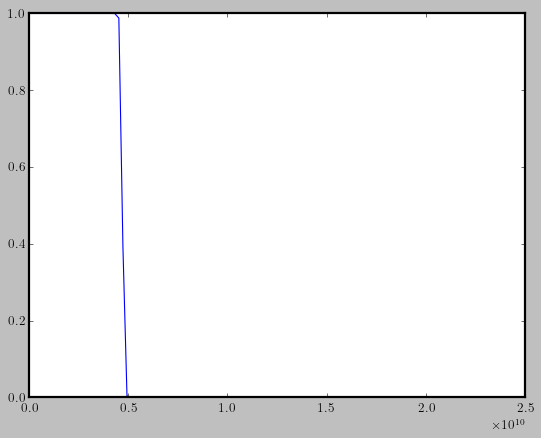

In [6]:
def get_f_k(k,Te,ne):
    
    #print('>>> get_FD_dist ... ')
    
    # Te : J
    # ne : 1/m^3
    
    E_K = (hbar*k)**2/(2*massElectronReduced) # J
    
    mu = get_mu(ne,Te) # J
    
    #print(E_K)
    
    exponent=(E_K-mu)/Te
        
    if exponent < 150 : 
        f_k = 1/(math.exp(exponent)+1) # unitless
    else : 
        f_k = 0
    
    if 0 : 
        print('exponent,f_k,Te/eV,ne,mu,E_K = ',
              "{:.3e}".format(exponent),
              "{:.3e}".format(f_k),
              "{:.3e}".format(Te/eV),
              "{:.3e}".format(ne),
              "{:.3e}".format(mu),
              "{:.3e}".format(E_K/eV))    
    
    return f_k # unitless

T = 0.03*eV
ne = 10**22*100**3
get_f_k(kmin_EAP,T,ne) 

#temp = [ T for T in np.arange(0.01,10,0.01)]
#f_k = [get_f_k(kmin_EAP,Te*eV,10**22*100**3)  for Te in temp]
#plt.plot(temp,f_k)

kvalue = [ k for k in np.arange(kmin_EAP,kBZ,(kBZ-kmin_EAP)/100)]
f_k = [get_f_k(k,T,ne)  for k in kvalue]
plt.plot(kvalue,f_k)

## get_OMEGA

omegaAO  (1/s) =  5548542.653501729
omegaLO1 (1/s) =  110564549791022.64
omegaLO2 (1/s) =  292517082890764.75


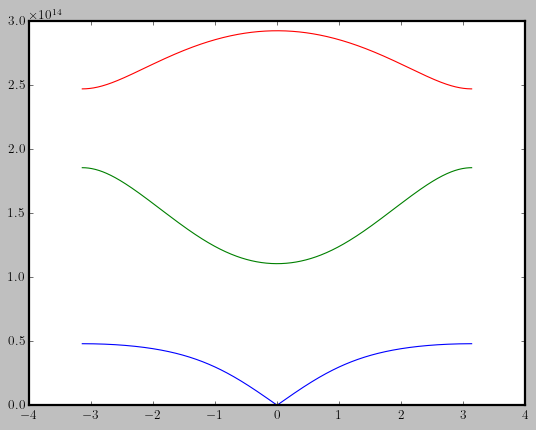

In [7]:
def get_OMEGA(ka,m):
    
    if 0 : print('>>> get_OMEGA ...')
    
    # Normal Vibrations and Their Dispersion in Syndiotactic Polystyrene
    # SHANTANU RASTOGI and V. D. GUPTA
    # J. MACKOMOL. SC1.-PHYS., B33(2), 129-141 (1994)
        
    alpha = -mPh*mCH*mCH2
    beta  = G*mCH2*(mCH+mPh)+2*K*mPh*(mCH+mCH2)
    gamma = (4*K**2*np.cos(ka/2)**2-2*K*(2*K+G))*mPh-2*G*K*(mCH+mCH2)
    delta = 4*G*K**2*(1-np.cos(ka/2)**2)
    
    p = -beta**2/(3*alpha**2)+gamma/alpha
    q = 2*beta**3/(27*alpha**3)-9*beta*gamma/(27*alpha**2)+delta/alpha
    
    argument = 1/3*np.arccos(3*q/(2*p)*np.sqrt(-3/p))+2*(m+1)*np.pi/3    
    zm = 2*np.sqrt(-p/3)*np.cos(argument)
    
    omega = np.sqrt(zm - beta/(3*alpha))
    
    #return omega*hbar/meV/2 # meV
    return omega # 1/s

omegaAO  = get_OMEGA(ka=0,m=0) # 1/s
omegaLO1 = get_OMEGA(ka=0,m=1) # 1/s
omegaLO2 = get_OMEGA(ka=0,m=2) # 1/s
    
print('omegaAO  (1/s) = ',omegaAO )
print('omegaLO1 (1/s) = ',omegaLO1)  
print('omegaLO2 (1/s) = ',omegaLO2)  

xdata    = [ ka for ka in np.arange(-np.pi,np.pi,0.01)]
ydata_m0 = [ get_OMEGA(ka=x,m=0) for x in xdata]
ydata_m1 = [ get_OMEGA(ka=x,m=1) for x in xdata]
ydata_m2 = [ get_OMEGA(ka=x,m=2) for x in xdata]

plt.plot(xdata,ydata_m0)
plt.plot(xdata,ydata_m1)
plt.plot(xdata,ydata_m2)

## get_report_omega

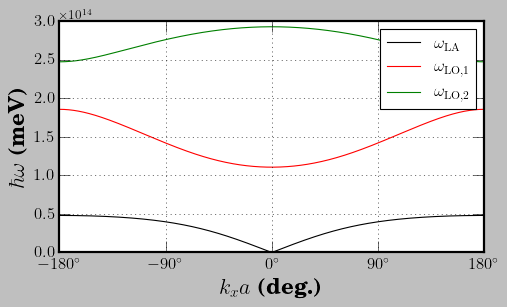

In [8]:
def get_report_omega(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.5,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$\omega_{\mathrm{LA}}$}'
    label2 = r'\textbf{$\omega_{\mathrm{LO,1}}$}'
    label3 = r'\textbf{$\omega_{\mathrm{LO,2}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 

    ax1.plot(xdata,ydata_m0,c='k',label=label1)
    ax1.plot(xdata,ydata_m1,c='r',label=label2)
    ax1.plot(xdata,ydata_m2,c='g',label=label3)

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{$k_x a$ (deg.)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\hbar \omega$ (meV)}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper right',numpoints=1)
    ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    plt.sca(ax1)
    plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
               [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'polystyrene_dispersion_relation'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_omega(exportFlag=0)

## get_EAP_rate

In [9]:
def get_EAP_rate(k,Ti,rho):
    
    #print('>>> get_EAP_rate ...')

    # Ti : J
    # rho : kg/m^3
    
    factor_1 = Upotential**2*Ti*massElectronReduced
    factor_2 = 2*np.pi*rho*cs**2*hbar**3*k
    factor_3 = k**2 + (massElectronReduced*cs/hbar)**2
    
    return factor_1/factor_2*factor_3
    
get_EAP_rate(kmin_EAP,Ti,rho)

284991351957.0703

## get_EAP_rate_avg

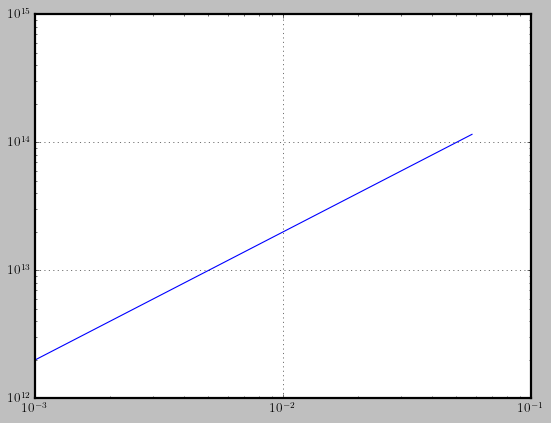

In [10]:
def get_EAP_rate_avg(Te,Ti,ne,rho):
    
    #print('>>> get_EAP_rate_avg ...')
    
    # Te : J
    # Ti : J
    # rho : kg/m^3
    # ne : 1/m^3
    
    #k = np.sqrt((3/2*Te)*2*massElectronReduced)/hbar
    
    V = (dCC*2)**3 # m^3
    
    g_k = 2*V/(8*np.pi**3) # m^3
    
    f_k = get_f_k(kmin_EAP,Te,ne)
    
    m = 2
    
    result1 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EAP_rate(k,Ti,rho) , kmin_EAP, kBZ)[0]

    result2 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m , kmin_EAP, kBZ)[0]
    
    residue = 10**-100
    
    EAP_rate_avg = result1/(result2+residue) # 1/s
    #EAP_rate_avg = result2 # 1/s
    
    if 0 :
        print('EAP_rate_avg = ',"{:.3e}".format(EAP_rate_avg),
              ', Te (eV) = ',"{:.3e}".format(Te/eV))    
    
    return EAP_rate_avg

    
T = 0.01*eV
ne = 10**22*100**3
get_EAP_rate_avg(T,T,ne,rho)
#get_EAP_rate_avg(Te,Ti,10**22*100**3,rho)

#temp = [ T for T in np.arange(0.01,100,0.01)]

temp      = [ T for T in np.arange(0.001,Tc/eV,0.0001)]
collFreq2 = [get_EAP_rate_avg(T*eV,T*eV,10**22*100**3,rho) for T in temp]

plt.loglog(temp,collFreq2)
plt.grid()

## get_EOP_rate

In [11]:
def get_EOP_rate(k,omega_LO,Ti,flag_emit,flag_absrob):
    
    #print('>>> get_EOP_rate ...')
    
    # omega_LO : 1/s
    # Ti : J

    factor1 = eCharge**2*massElectronReduced*omega_LO/(hbar**2*k)/(4*np.pi)
    factor2 = (1/varepsilon_infty - 1/varepsilon_0)/vacuumPermittivity    
    g_LO    = 1/(math.exp(hbar*omega_LO/Ti)-1)
    
    energy_LO  = hbar*omega_LO # J
    energy_ele = (hbar*k)**2/(2*massElectronReduced) # J
        
    if (flag_emit==1) and (flag_absrob==0) :
        inside = max(1 - energy_LO/energy_ele,0)
        ln     = np.log((1 + inside**0.5)/(1 - inside**0.5))
        rate   = factor1*factor2*(g_LO+1)*ln
        
        
    if (flag_emit==0) and (flag_absrob==1) :
        inside = 1 + energy_LO/energy_ele
        ln     = np.log((inside**0.5 + 1)/(inside**0.5 - 1))
        rate   = factor1*factor2*g_LO*ln
        
    if 0 :
        #print('factor1 = ',factor1)
        #print('factor2 = ',factor2)
        print('factor1*factor2 = ',"{:.3e}".format(factor1*factor2))
        print('g_LO = ',g_LO)
        #print('hbar*omega_LO/eV = ',hbar*omega_LO/eV)
        #print('energy_LO/eV = ',"{:.3e}".format(energy_LO/eV))
        #print('energy_ele/eV = ',"{:.3e}".format(energy_ele/eV))    
        #print('Ti/eV = ',Ti/eV)
        print('inside = ',"{:.3e}".format(inside))
        print('energy_LO/energy_ele = ',"{:.3e}".format(energy_LO/energy_ele))  
        print('ln = ',"{:.3e}".format(ln)) 
        print('rate = ',"{:.3e}".format(rate))     
        print()
            
    return rate # 1/s

T = 0.02*eV

EOP_emit1 = get_EOP_rate(kmin_EOP_emit1,omega_LO1,Ti,1,0)
EOP_emit2 = get_EOP_rate(kmin_EOP_emit2,omega_LO2,Ti,1,0)

#EOP_absrob1 = get_EOP_rate(kmin_EOP_absrob,omega_LO1,Ti,0,1)
#EOP_absrob2 = get_EOP_rate(kmin_EOP_absrob,omega_LO2,Ti,0,1)

#print(get_EOP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho))

## get_EOP_rate_avg

In [12]:
def get_EOP_rate_avg(Te,Ti,ne,rho):
    
    #print('>>> get_EAP_rate_avg ...')
    
    # Te : J
    # Ti : J
    # rho : kg/m^3
    # ne : 1/m^3
    
    V = (dCC*2)**3 # m^3
    
    g_k = 2*V/(8*np.pi**3) # m^3
    
    m = 2
    
    result1 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO1,Ti,1,0) ,    kmin_EOP_emit1, kBZ)
    result2 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_emit1, kBZ)
    
    result3 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO2,Ti,1,0) ,    kmin_EOP_emit2, kBZ)
    result4 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_emit2, kBZ)
    
    result5 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO1,Ti,0,1) ,    kmin_EOP_absrob, kBZ)
    result6 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_absrob, kBZ)
    
    result7 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m * \
                             get_EOP_rate(k,omega_LO2,Ti,0,1) ,    kmin_EOP_absrob, kBZ)
    result8 = integrate.quad(lambda k: g_k * get_f_k(k,Te,ne)*k**m,kmin_EOP_absrob, kBZ)
    
    residue = 10**-100
    
    EOP_rate_emit1 = result1[0]/(result2[0]+residue)
    EOP_rate_emit2 = result3[0]/(result4[0]+residue)
    EOP_rate_absorb1 = result5[0]/(result6[0]+residue)
    EOP_rate_absorb2 = result7[0]/(result8[0]+residue)   
    
    EOP_rate = EOP_rate_emit1*1   + \
               EOP_rate_emit2*1   + \
               EOP_rate_absorb1*1 + \
               EOP_rate_absorb2*1
    
    if 0 : 
        print('EOP_rate_emit1   = ',"{:.3e}".format(EOP_rate_emit1))
        print('EOP_rate_emit2   = ',"{:.3e}".format(EOP_rate_emit2))
        print('EOP_rate_absorb1 = ',"{:.3e}".format(EOP_rate_absorb1))    
        print('EOP_rate_absorb2 = ',"{:.3e}".format(EOP_rate_absorb2))
        
        print('result2[0] = ',"{:.3e}".format(result2[0]))        
        print('result4[0] = ',"{:.3e}".format(result4[0])) 
        print('result6[0] = ',"{:.3e}".format(result6[0]))                
    
    return EOP_rate
    
T = 0.058    
EAP_1 = get_EAP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho)
EOP_1 = get_EOP_rate_avg(T*eV,T*eV,1*10**22*100**3,rho)

print(EAP_1,EOP_1,EOP_1/EAP_1)

if 0 : 
    temp0     = np.array([ T for T in np.arange(0.001,Tc/eV,0.0001)])
    collFreq2 = np.array([ get_EAP_rate_avg(T*eV,T*eV,3*10**22*100**3,rho) for T in temp0 ])
    collFreq3 = np.array([ get_EOP_rate_avg(T*eV,T*eV,3*10**22*100**3,rho) for T in temp0 ])

    plt.loglog(temp0,collFreq2)
    plt.loglog(temp0,collFreq3)
    plt.grid()

115353635880403.2 2601626157159467.0 22.55348205804966


## get_lambda_DH

In [13]:
def get_lambda_DH(Te,Ti,ne,ni):
        
    # Te : J
    # Ti : J  
    # ne : 1/m^3
    # ni : 1/m^3
    
    E_Fermi = get_E_Fermi(ne) # J    
    T_Fermi = E_Fermi*2/3     # J
    
    Te_erg = Te*J_to_erg      # erg
    Ti_erg = Ti*J_to_erg      # erg
    Tf_erg = T_Fermi*J_to_erg # erg
    
    ne_gcc = ne/gcm3_to_kgm3  # g/cm^3
    ni_gcc = ni/gcm3_to_kgm3  # g/cm^3
        
    part1 = 4*np.pi*ne_gcc*eCharge_ESU**2/np.sqrt(Te_erg**2+Tf_erg**2)
    part2 = 4*np.pi*ni_gcc*eCharge_ESU**2*Z_CH**2/Ti_erg
    
    lambda_DH_cm = (part1 + part2)**(-1/2)     # cm
    lambda_DH    = (part1 + part2)**(-1/2)/100 # m    
    
    if 0 : 
        print(' >>> get_lambda_DH ... ')    
        print('E_Fermi/eV = ',"{:.3e}".format(E_Fermi/eV))
        print('T_Fermi/eV = ',"{:.3e}".format(T_Fermi/eV))    
        print('part1 = ',"{:.3e}".format(part1))
        print('part2 = ',"{:.3e}".format(part2))    
        print('lambda_DH (m) = ',"{:.3e}".format(lambda_DH)) 
    
    return lambda_DH # m
    
get_lambda_DH(Te,Ti,10**22*100**3,n_a_CH)    

1.6614268764957574e-14

## get_R_cloest

In [14]:
def get_R_cloest(Te,Ti,ne,ni):
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni) # m
    
    w = lambertw(2*Z_CH*eCharge**2/(lambda_DH*Te)) # unitless
    
    R_cloest = lambda_DH*np.real(w) # m
    
    if 0 :
        print('>>> get_R_cloest ... ')    
        print('lambda_DH (m) = ',lambda_DH)
        print('w, np.real(w) = ',w,np.real(w))
        print('R_cloest  (m) = ',R_cloest)
    
    return R_cloest # m
    
get_R_cloest(Te,Ti,10**22*100**3,n_a_CH)    

8.936200869780325e-17

## get_R_Broglie

In [15]:
def get_R_Broglie(Te):    
    
    R_Broglie = hbar*(2*np.pi)/np.sqrt(massElectron*Te) # m
    
    if 0 : 
        print(' >>> get_R_Broglie ... ')    
        print('R_Broglie = ',R_Broglie)
    
    return R_Broglie # m
    
get_R_Broglie(Te)    

1.0976946109186968e-08

## get_theta

In [16]:
def get_theta(b,bmax,Te,Ti,ne,ni):
    
    print(' >>> get_theta ... ')
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni)
    
    R_cloest = get_R_cloest(Te,Ti,ne,ni)
    
    theta = integrate.quad(lambda r:r**(-2)*(1-2/Te*Z_CH*eCharge**2/r*math.exp(-r/lambda_DH)-(b/r)**2)**(-1/2),R_cloest,bmax) 
    
    print(theta)
    
#get_theta(0,1.9964727358293832e-10,Te,Ti,10**22*100**3,n_a_CH)   

## get_Coulomb_Log

In [17]:
def get_Coulomb_Log(Te,Ti,ne,ni):
         
    R_cloest = get_R_cloest(Te,Ti,ne,ni)
    
    R_Broglie = get_R_Broglie(Te)
    
    lambda_DH = get_lambda_DH(Te,Ti,ne,ni)
    
    ai = (3/(4*np.pi*ni))**(1/3) # m
    
    bmin = 0.5 * max(R_cloest, R_Broglie) # m
        
    bmax = np.sqrt(lambda_DH**2+ai**2) # m
    
    Coulomb_Log = max(1/2*np.log(1+bmax**2/bmin**2),1)
        
    if 0 : 
        print('>>> get_Coulomb_Log ... ')        
        print('R_cloest  (m) = ',R_cloest)
        print('R_Broglie (m) = ',R_Broglie)
        print('bmin (m)      = ',bmin) 
        print('lambda_DH (m) = ',lambda_DH)
        print('ai (m)        = ',ai) 
        print('bmax (m)      = ',bmax)
        print('Coulomb_Log   = ',Coulomb_Log)
        
    return Coulomb_Log
    
get_Coulomb_Log(Te,Ti,10**22*100**3,n_a_CH)     

1

## get_Zeff

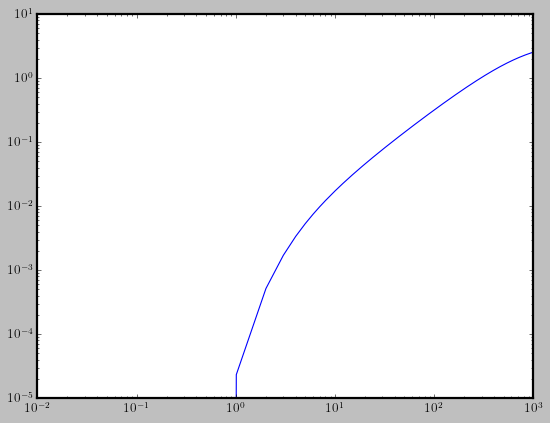

In [18]:
def get_Zeff(ni,Te):
    
    # ni : 1/m^3
    # T : J
    
    # Phys. Plasmas 23, 042704 (2016); https://doi.org/10.1063/1.4945753
    # ni is the ion density
    
    T = Te/eV # eV
    
    a0 = 87.222
    a1 = 10.866
    a2 = -28.412
    a3 = 17.915
    a4 = -2.422
    a5 = 0.595
    a6 = -2.369*10**-2
    
    ai = (3/(4*np.pi*ni))**(1/3) # m
    
    Bohr_radius = 4*np.pi*vacuumPermittivity*hbar**2/(massElectron*eCharge**2) # m
    
    r0 = ai/Bohr_radius # no unit
    
    gamma0 = 1/(r0*T) # 1/eV
    
    fz = a1 + a2*T*((1+np.sqrt(3*gamma0))**(1/4)-1) + a3*T**0.9 + \
        (a4/r0 + a5/r0**2 + a6/r0**3)*T
    
    h = hbar*2*np.pi # J/K
    
    DB_wavelength = h/np.sqrt(massElectron*Te) # m
    
    RHS = a0/(ni*DB_wavelength**3)*math.exp(-fz/T)
    
    coeff = [1,RHS,-RHS]
    sol   = np.roots(coeff) 
    
    xi = max(sol)
    xi_Jack = (-RHS+np.sqrt(RHS**2+4*RHS))/2
    
    Zeff = xi*Zmax_CH
    
    if 0 : 
        print('>>> get_Zeff ...')
        print('Bohr_radius (m) = ',Bohr_radius)
        print('ai (m) = ',ai)
        print('a0 = ',a0)  
        print('gamma0 = ',gamma0)      
        print('fz = ',fz)
        print('xi = ',xi)
        print('xi_jack = ',xi_Jack)
        print('Zeff = ',Zeff)
        print('DB_wavelength (m) = ',DB_wavelength)  
        print('ni*DB_wavelength**3 = ',ni*DB_wavelength**3)
        print('a0/(ni*DB_wavelength**3) = ',a0/(ni*DB_wavelength**3))
        print('math.exp(-fz/T) = ',math.exp(-fz/T))
        print('sol = ',sol)
        
    return Zeff
    
get_Zeff(n_a_CH,1000*eV)  

xdata = [ne for ne in np.arange(0.01,1000,1)]
ydata = [get_Zeff(n_a_CH,T*eV)for T in xdata ]
plt.loglog(xdata,ydata)

## get_vc_neutral

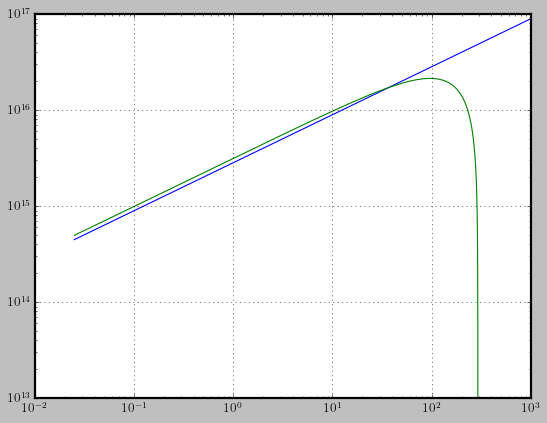

In [19]:
def get_vc_neutral(Te,ni,ne,mode):
    
    sigma = np.pi*(dCC)**2 # m^2
    
    if mode == 0 : 
        n0 = ni - ne
        
    if mode == 1 :     
        Z_eff = get_Zeff(ni,Te)
        ne_eff = ni*Z_eff
        n0 = ni - min(ne_eff,ni)
    
    vc_neutral = n0*sigma*np.sqrt(Te/massElectron) # 1/s
    
    if 0 : 
        print('>>> get_vc_neutral ... ')
        print('vc_neutral = ',"{:.3e}".format(vc_neutral))
    
    return vc_neutral
    
#get_vc_neutral(1*eV,n_a_CH,0.025*eV,0.) 

temp4 = [ T for T in np.arange(0.025,1000,1)]
collFreq4_mode0 = [get_vc_neutral(T*eV,n_a_CH,1*10**22*100**3,0) for T in temp4]
collFreq4_mode1 = [get_vc_neutral(T*eV,n_a_CH,1*10**22*100**3,1) for T in temp4]

plt.loglog(temp4,collFreq4_mode0)
plt.loglog(temp4,collFreq4_mode1)
plt.grid()

## get_FD_integral (testing purposes)

In [20]:
def get_FD_integral(x):
        
    FD_integral = integrate.quad(lambda t:t**0.5/(1+math.exp(t-x)),0,100)[0]
    
    if 0 : 
        print(' >>> get_FD_integral ... ')
        print(' FD_integral ',FD_integral)
    
    return FD_integral
    
x = 1
get_FD_integral(x)    

1.396375280666549

## get_vc_ion

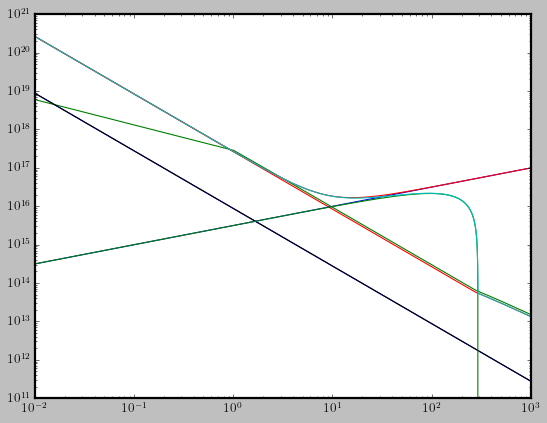

In [21]:
def get_vc_ion(Te,Ti,ne,ni,degeneracy):
    
    Z_eff = ni/ne
    
    #Z_eff = get_Zeff(ni,Te)
    
    ne_gcc = ne/100**3 # g/cm^3
    
    me_cgs = massElectron*1000 # g
    
    Te_erg = Te*J_to_erg # erg
    
    Te_eV = Te/eV # eV
    
    Coulomb_Log = get_Coulomb_Log(Te,Ti,ne,ni) # unitless
    
    mu = get_mu(ne,Te) # J
    
    x = mu/Te # unitless
    
    FD_integral = get_FD_integral(x)+10**(-150)
    
    part1 = 2*np.sqrt(2)*np.pi/3
    
    part2 = Z_eff*eCharge_ESU**4*ne_gcc/np.sqrt(me_cgs)/Te_erg**1.5
    
    part3 = 1/(1+math.exp(-x))/FD_integral
    
    vc_ion = part1*part2*Coulomb_Log*part3**degeneracy
            
    Zlnlambda = 10
    # Ref[NRL : all quantities in CGS except Te in eV]
    vei_NRL = 2.91*10**-6*ne_gcc*Zlnlambda/(Te_eV**1.5) # 1/s with unit [Te] in eV    
    
    vei_WOO = math.sqrt(2)*ne*eCharge**4*Zlnlambda/ \
               (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*Te**1.5)    
    
    if degeneracy == 2 : vc_ion = vei_NRL
    if degeneracy == 3 : vc_ion = vei_WOO

    if 0 : 
        print('>>>> get_vc_ion ...')
        print('part1 = ',part1)    
        print('part2 = ',part2)
        print('part3 = ',part3)    
        print('Coulomb_Log = ',Coulomb_Log)   
        print('mu = ',mu)  
        print('FD_integral = ',FD_integral)   
        print('Te/eV = ',Te/eV)
        print('degeneracy = ',degeneracy)
        print('vei = ',vei)
        print('vc_ion = ',vc_ion)        
        
    return vc_ion
    
#get_vc_ion(Te,Ti,10**22*100**3,n_a_CH,0) 

NE_IN = 3*10**20*100**3

if 1 : 
    temp5 = [ T for T in np.arange(0.01,1000,1)]
    collFreq5   = np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,0) for T in temp5])
    collFreq5QM = np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,1) for T in temp5])
    collFreq5NRL= np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,2) for T in temp5])
    collFreq5WOO= np.array([get_vc_ion(T*eV,T*eV,NE_IN,n_a_CH,3) for T in temp5])
    
    # get_vc_neutral(Te,ni,ne)
    collFreq4_mode0 = np.array([get_vc_neutral(T*eV,n_a_CH,NE_IN,0) for T in temp5])
    collFreq4_mode1 = np.array([get_vc_neutral(T*eV,n_a_CH,NE_IN,1) for T in temp5])    

    plt.loglog(temp5,collFreq5,   c='r')
    plt.loglog(temp5,collFreq5QM, c='g')
    plt.loglog(temp5,collFreq5NRL,c='b')
    plt.loglog(temp5,collFreq5WOO,c='k')
    
    plt.loglog(temp5,collFreq4_mode0)
    plt.loglog(temp5,collFreq4_mode1)    
    plt.loglog(temp5,collFreq4_mode0[:]+collFreq5[:]) 
    plt.loglog(temp5,collFreq4_mode1[:]+collFreq5[:])     

## get_vc_new

C:\Users\nickd\AppData\Local\Temp\ipykernel_2644\3534035623.py:31: RuntimeWarning: divide by zero encountered in scalar divide
  vc_new = 1/(1/vc_neutral+1/vc_ion)


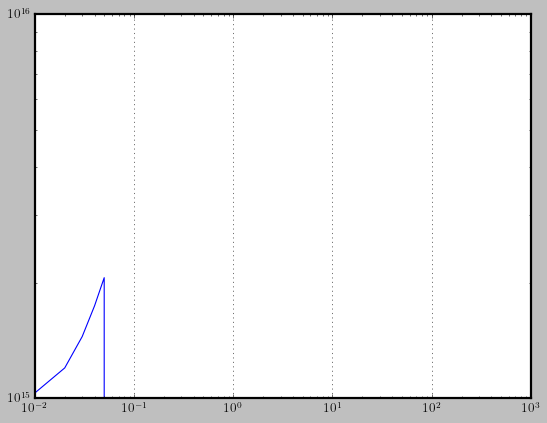

In [48]:
def get_vc_new(Te,Ti,ne,ni,rho):
    
    if 0 : 
        print('Te/eV = ',"{:.3e}".format(Te/eV))
        print('Ti/eV = ',"{:.3e}".format(Ti/eV))
        print('ne    = ',"{:.3e}".format(ne))
        print('ni    = ',"{:.3e}".format(ni))        
        print('rho   = ',"{:.3e}".format(rho))           
        
    vc_neutral = get_vc_neutral(Te,ni,ne,0)
    
    degeneracy = 1
    
    vc_ion = get_vc_ion(Te,Ti,ne,ni,degeneracy)
    
    XPS = (np.tanh(-(Te-Tc))+1)/2
    
    XAM = (np.tanh(+(Te-Tc))+1)/2
    
    ve = math.sqrt(1.5*Te/massElectron) # m/s
    vmpf = ve*ni**(1/3) # 1/s    
    
    if Ti<Tc : 
        EAP_rate_avg = get_EAP_rate_avg(Te,Ti,ne,rho)
        EOP_rate_avg = get_EOP_rate_avg(Te,Ti,ne,rho)        
        vc_new = (EAP_rate_avg + EOP_rate_avg)*1
        
    #if (Te>=Tc) and (Te<eV) : vc_new = vc_neutral
    if (Ti>=Tc) : 
        #vc_new = vc_neutral+vc_ion
        vc_new = 1/(1/vc_neutral+1/vc_ion)
        #vc_new = 1/(1/vmpf+1/vc_ion)
    
    if 0 : 
        print('>>> get_vc_new ... ')     
        print('EAP_rate_avg (1/s) = ',"{:.3e}".format(EAP_rate_avg))
        print('EOP_rate_avg (1/s) = ',"{:.3e}".format(EOP_rate_avg)) 
        print('vc_neutral (1/s)   = ',"{:.3e}".format(vc_neutral))
        print('vc_ion (1/s)       = ',"{:.3e}".format(vc_ion))
        print('vc_new (1/s)       = ',"{:.3e}".format(vc_new))
    
    return vc_new
        
#get_vc_new(Te,Ti,3*10**22*100**3,n_a_CH,rho) 

temp6 = [ T for T in np.arange(0.01,1000,0.01)]
collFreq6  = [get_vc_new(T*eV,T*eV,3*10**22*100**3,n_a_CH,rho) for T in temp6]
plt.loglog(temp6,collFreq6)
plt.grid()

## get_vc

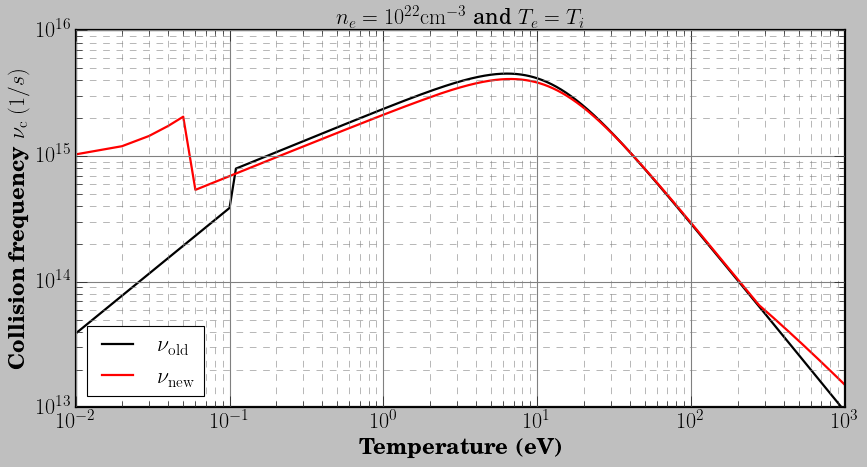

In [23]:
def get_vc(Te,Til,nfe,na,mode):
    
    # Te unit  : eV
    # Til unit : eV
    # nfe unit : 1/m^3
    # na unit  : 1/m^3
    
    if Til <= 0.1 : 
        vph0 = 10**14 # 1/s
        T0 = 300*kelvin_to_eV # eV
        vc = vph0*Til/T0 # 1/s
    
    if Til > 0.1 :
        Zlnlambda = 10
        # Ref[NRL : all quantities in CGS except Te in eV]
        vei_NRL = 2.91*10**-6*(nfe/100**3)*Zlnlambda/(Te**1.5) # 1/s with unit [Te] in eV
        # Ref[Spitzer]
        vei_WOO = math.sqrt(2)*nfe*eCharge**4*Zlnlambda/ \
              (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*(Te*eV)**1.5) # 1/s
        # Ref[Lee-More : An electron conductivity model for dense plasmas]
        ve = math.sqrt(1.5*Te*eV/massElectron) # m/s
        vmpf = ve*na**(1/3) # 1/s
        if mode==0 : vc = 1/(1/vmpf+1/vei_NRL) # 1/s
        if mode==1 : vc = 1/(1/vmpf+1/vei_WOO) # 1/s
        
    if Til > 1000:
        # Ref[Spitzer]
        vei = math.sqrt(2)*nfe*eCharge**4*Zlnlambda/ \
              (12*math.pi**1.5*vacuumPermittivity**2*math.sqrt(massElectron)*(Te*eV)**1.5)
        vc = vei

    return vc # 1/s

plot=1
if plot==1:
    
    ne_IN = 1*10**22*100**3
    temp = [ T for T in np.arange(0.01,1000,0.01) ]
    collFreq_NRL = [get_vc(T,T,ne_IN,n_a_CH,0) for T in temp]
    collFreq_WOO = [get_vc(T,T,ne_IN,n_a_CH,1) for T in temp]
         
    plt.figure(figsize=[11,6])
    
    #plt.loglog(temp,collFreq_NRL,lw=2,ls='dashed',   basex=10, c='red', label=r'$\nu_{\mathrm{old,NRL}}$')
    plt.loglog(temp,collFreq_WOO,lw=2,c='k',label=r'$\nu_{\mathrm{old}}$')
    #plt.loglog(temp0,collFreq2,lw=2, basex=10, c='b', label=r'$\nu_{LA}$')
    #plt.loglog(temp0,collFreq3,lw=2, basex=10, c='r', label=r'$\nu_{LO}$')
    #plt.loglog(temp0,collFreq2[:]+collFreq3[:],lw=1, basex=10, color='r',           label=r'$\nu_{LA}+\nu_{LO}$')
    
    #plt.loglog(temp4,collFreq4,lw=2, basex=10, color='purple', label=r'$\nu_{en}$') 
    #plt.loglog(temp5,collFreq5WOO,lw=2, basex=10, color='green', label=r'$\nu_{ei}$')     
    plt.loglog(temp6,collFreq6,lw=2,color='r',label=r'$\nu_{\mathrm{new}}$') 
  
    title = r'$n_{e} = 10^{22}\mathrm{cm^{-3}}$ and $T_{e} = T_{i}$'
    
    plt.legend(fontsize=20,loc='lower left')
    plt.title(title,fontsize=20)
    plt.xlabel(r'\textbf{Temperature (eV)}',fontsize=20)
    plt.ylabel(r'\textbf{Collision frequency $\nu_{\mathrm{c}}~(1/s)$}',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.tick_params(direction='in',right=True,top=True,length=10)
    plt.tick_params(which='minor',length=5,right=True,direction='in',top=True)
    plt.ylim([10**13,10**16])
    plt.xlim([0.01,1000])
    plt.grid(which='major', linestyle='-', linewidth='1', color='grey')
    plt.grid(which='minor', linestyle='--', linewidth='0.5', color='grey')
    
    plt.tight_layout()
    if 0 : 
        export_name = 'collisional_freq_new_V5'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 

# Heat Capacity

## get_cp_solid

In [24]:
def get_cp_solid(T):
    
    # T : K
    
    a1 = -0.098338
    a2 = -1.30958
    a3 = 6.5499
    a4 = -8.13656
 
    cp_solid_1 = math.exp(a1*np.log(T)**3 + a2*np.log(T)**2 + a3*np.log(T) + a4)    
    cp_solid_2 = 7.7551*10**5*T**(-2) + 0.53447*T - 41.58
    cp_molten  = 0.2653*T + 95.12
    
    if (T>=10) and (T<200)  : cp = cp_solid_1
        
    if (T>=200) and (T<373) : cp = cp_solid_2
        
    if (T>=373) and (T<1000) : cp = cp_molten      
    
    return cp

## get_cp_data_lowT

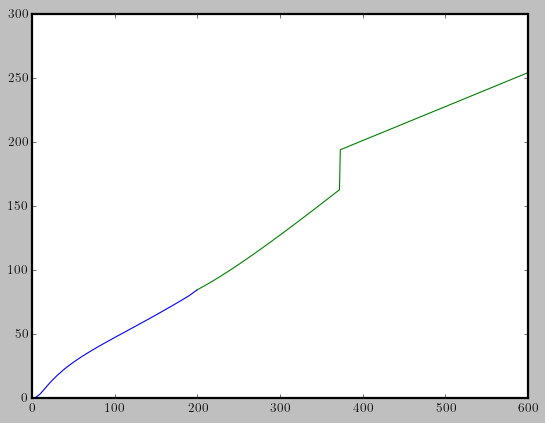

In [25]:
def get_cp_data_lowT():
    
    data =np.array([[0,0],
          [0.1,0.0000633],
          [0.2,0.000132],
          [0.3,0.000269],
          [0.4,0.000496],
          [0.5,0.000838],
          [0.6,0.00133],
          [0.7,0.00200],
          [0.8,0.00288],
          [0.9,0.00401],
          [1.0,0.00543],
          [1.2,0.00929],
          [1.4,0.01480],
          [1.6,0.02231],
          [1.8,0.03217],
          [2.0,0.04477],
          [3.0,0.1622],
          [4.0,0.4058],
          [5.0,0.8215],
          [10,3.33],
          [15,7.03],
          [20,10.77],
          [25,14.26],
          [30,17.47],
          [40,23.13],
          [50,28.01],
          [60,32.37],
          [70,36.38],
          [80,40.17],
          [90,43.81],
          [100,47.37],
          [120,54.38],
          [130,57.89],
          [140,61.43],
          [150,65.01],
          [160,68.65],
          [170,72.36],
          [180,76.14],
          [190,80.01],
          [200,84.70175]])
    
    return data # J/mol/K

cp_data_lowT = get_cp_data_lowT()
plt.plot(cp_data_lowT[:,0],cp_data_lowT[:,1])

temp = [ T for T in range(200,600,1)]
cp_solid = [ get_cp_solid(T) for T in temp ]
plt.plot(temp,cp_solid)

## func_T3_law

In [26]:
def func_T3_law(T,TD):
    # T : K
    # TD : K
    gas_constant = mole*kB # J/mole/K    
    return 12*np.pi**4/5*gas_constant*(T/TD)**3

## get_T_Debye

T_Debye (K) =  66.87350842025788
T_Debye (meV) =  5.765658687402574


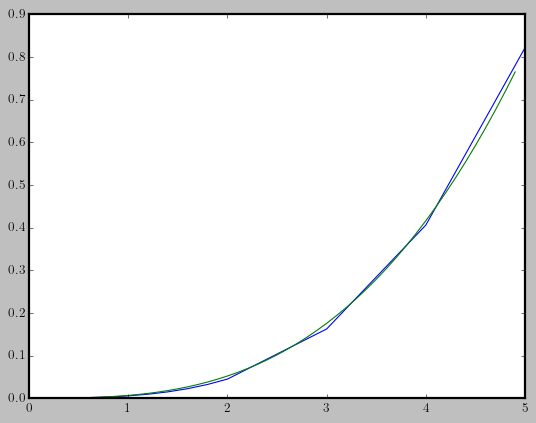

In [27]:
def get_T_Debye(cp_data_lowT):
    
    data = []
    for ele in cp_data_lowT:
        if ele[0]<10 : data.append(ele)
    data = np.array(data)
        
    gas_constant = mole*kB # J/mole/K
        
    xdata = data[:,0]
    ydata = data[:,1]
     
    popt, pcov = curve_fit(func_T3_law, xdata, ydata)
    T_Debye = popt[0]
    
    xdata_fit = [T for T in np.arange(0,5,0.1)]
    ydata_fit = func_T3_law(xdata_fit,T_Debye) 
    
    plt.plot(xdata,ydata)
    plt.plot(xdata_fit,ydata_fit) 
    
    print('T_Debye (K) = ',popt[0])
    print('T_Debye (meV) = ',popt[0]*kelvin_to_eV*1000)    
    
    return T_Debye

T_Debye = get_T_Debye(cp_data_lowT)

## get_Vexpansion

In [28]:
def get_Vexpansion(T):
    
    # molar volume of a repeat unit
    Vm = 92.8*10**-6 # m^3/mol 
    
    # volumetric coefficient
    ag = 2.37*10**-4
    ar = 5.74*10**-4 

    bulk_modulus = 3.58*10**9 # Pa
    
    Vexpansion = Vm*ag**2*bulk_modulus*T
    
    return Vexpansion

## get_Einstein_function

0


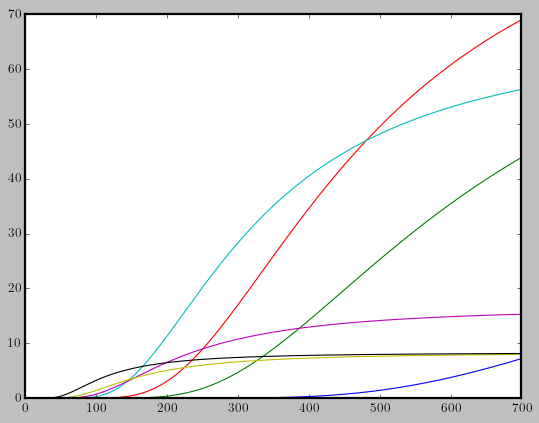

In [29]:
def get_Einstein_function(T,theta,N):
    
    R = 8.3145 # J/mole/K  
       
    if theta/T > 200 : 
        Einstein_function = 0
    else : 
        part1 = (theta/T)**2*math.exp(theta/T)
        part2 = (math.exp(theta/T) - 1)**2        
        Einstein_function = N*R*part1/part2
    
    return Einstein_function

print(get_Einstein_function(1,350,1))

if 1 :     
    temp = [ T for T in range(1,700,1)]
    plt.plot(temp,[get_Einstein_function(T,4000,8) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,2000,10) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,1500,12) for T in temp])      
    plt.plot(temp,[get_Einstein_function(T,1000,8) for T in temp])    
    plt.plot(temp,[get_Einstein_function(T,700,2) for T in temp])
    plt.plot(temp,[get_Einstein_function(T,500,1) for T in temp])
    plt.plot(temp,[get_Einstein_function(T,350,1) for T in temp])

## get_cp_group

74.9506385416552


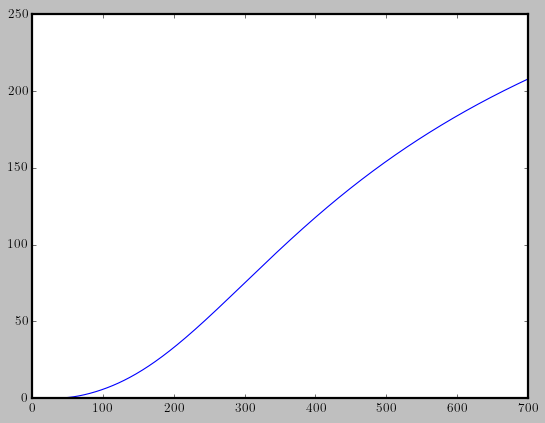

In [30]:
def get_cp_group(T):
    
    cp_group = get_Einstein_function(T,4000,8) +\
               get_Einstein_function(T,2000,10) +\
               get_Einstein_function(T,1500,12) +\
               get_Einstein_function(T,1000,8) +\
               get_Einstein_function(T,700,2) +\
               get_Einstein_function(T,500,1) +\
               get_Einstein_function(T,350,1)
    
    dimension = 1
    return cp_group*dimension # J/mol/K

print(get_cp_group(300))

if 1 :
    temp = [ T for T in range(1,700,1)]
    cp_group = [ get_cp_group(T) for T in temp ]
    plt.plot(temp,cp_group)

## get_cp_skeletal

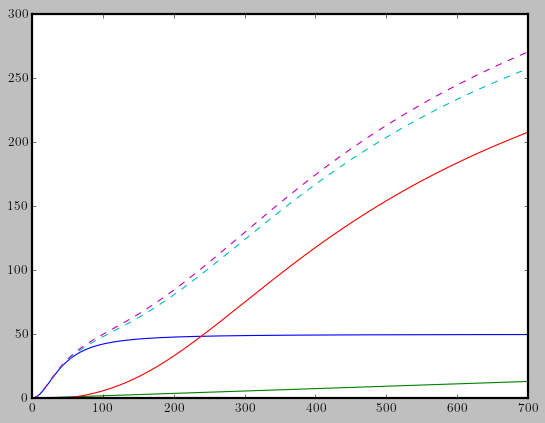

In [31]:
def get_cp_skeletal(T):
    
    R = 8.3145 # J/mole/K
    
    #CT = 6 R [ (T/42.5)^2 / (1 + (T/42.5)^2)]    
    #CP - CV = -T (dV/dT)2P / (dV/dP)2T = Vα2BT
    
    cp_skeletal = 6 * R * ((T/42.5)**2 / (1 + (T/42.5)**2))
    
    return cp_skeletal

if 1 :
    temp = np.array([ T for T in range(1,700,1)])
    cp_skeletal = np.array([ get_cp_skeletal(T) for T in temp ])    
    plt.plot(temp,cp_skeletal)
    
    Vexpansion = np.array([ get_Vexpansion(T) for T in temp ])
    plt.plot(temp,Vexpansion) 
    
    cp_group = np.array([ get_cp_group(T) for T in temp ])
    plt.plot(temp,cp_group)
    
    temp2 = [ T for T in range(200,700,1)]
    cp_solid = np.array([ get_cp_solid(T) for T in temp2 ])

    cp_Debye = [ func_T3_law(T,T_Debye) for T in temp]    
    
    plt.plot(temp,cp_skeletal+cp_group,ls='dashed') 
    plt.plot(temp,cp_skeletal+cp_group+Vexpansion,ls='dashed')     

## get_report_cp

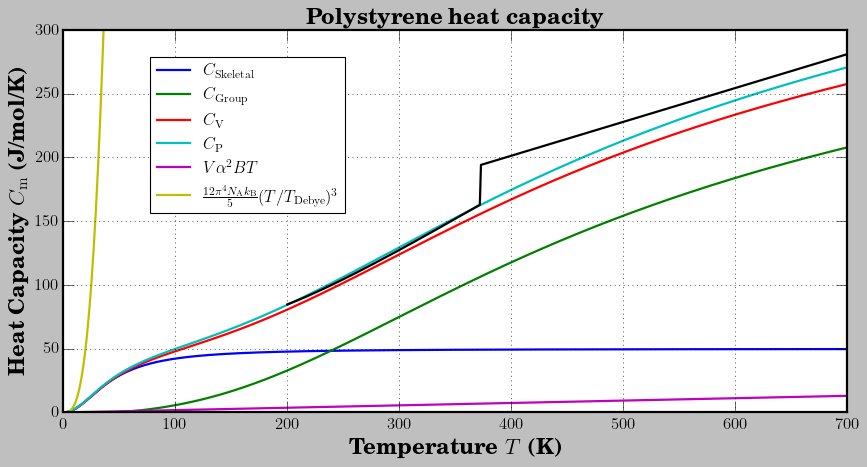

In [32]:
def get_report_cp(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[11,6])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$C_{\mathrm{Skeletal}}$}'
    label2 = r'\textbf{$C_{\mathrm{Group}}$}'
    label3 = r'\textbf{$C_{\mathrm{V}}$}'
    label4 = r'\textbf{$C_{\mathrm{P}}$}'
    label5 = r'\textbf{$V\alpha^2BT$}'
    label6 = r'\textbf{Exp. data}' 
    label7 = r'\textbf{$\frac{12\pi^4N_{\mathrm{A}}k_{\mathrm{B}}}{5}(T/T_{\mathrm{Debye}})^3$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    yfactor = 1#1/mole/kelvin_to_eV/eV

    ax1.plot(temp,cp_skeletal*yfactor,lw=2,label=label1)    
    ax1.plot(temp,cp_group*yfactor,lw=2,label=label2)    
    ax1.plot(temp,(cp_skeletal+cp_group)*yfactor,lw=2,label=label3)
    ax1.plot(temp,(cp_skeletal+cp_group+Vexpansion)*yfactor,lw=2,label=label4)
    ax1.plot(temp,Vexpansion*yfactor,lw=2,label=label5) 
    
    #ax1.plot(cp_data_lowT[:,0],cp_data_lowT[:,1],lw=2,c='k')        
    ax1.plot(temp2,cp_solid,lw=2,c='k')    # EXPERIMENTAL DATA!!! exp_data_CH
    ax1.plot(temp,cp_Debye,lw=2,label=label7)     
     
    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Temperature $T$ (K)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Heat Capacity $C_{\mathrm{m}}$ (J/mol/K)}',fontsize=fs) 
    #ax1.set_ylabel(r'\textbf{Heat Capacity $C_\mathrm{m}^\mathrm{J/mol/K}\times 0.12$}',fontsize=fs)
    ax1.set_title(r'\textbf{Polystyrene heat capacity}',fontsize=fs)      
    ax1.legend(fontsize=fs2,loc='upper left',bbox_to_anchor=[0.1,0.95],numpoints=1)
    ax1.set_ylim([0,300])
    ax1.grid()


    plt.tight_layout()
    if exportFlag : 
        export_name = 'polystyrene_heat_capacity'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_cp(exportFlag=0)

# Light Wave Propagation

## get_param

In [33]:
um = 10**-6 # m
nm = 10**-9 # m
ns = 10**-9 # s
ps = 10**-12 # s
fs = 10**-15 # s
eV = 1.6*10**-19 # J
kelvin_to_eV = 8.621738*10**-5 # eV 

lightSpeed = 299792458 # m/s
vacuumPermittivity = 8.854*10**-12 # C⋅V−1⋅m−1
epsilon0 = 8.854187817e-12 # vacuum permitivity [F/m] 1.e7_dp / (4*pi*c*c) 

# angular frequencies of laser
wavelength_355nm = 355*nm # m
wavelength_450nm = 450*nm # m

omega_351nm = 2*np.pi*(lightSpeed/wavelength_355nm) # 1/s
omega_355nm = 2*np.pi*(lightSpeed/wavelength_355nm) # 1/s
omega_450nm = 2*np.pi*(lightSpeed/wavelength_450nm) # 1/s

PlanckConstant = 6.62607015*10**-34 # J.s
hbar = PlanckConstant/(2*math.pi) # J.s

# input  laser intensity unit : W/m^2
# output electric field  unit : V/m
vacuumRefractiveIndex = 1
coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/vacuumRefractiveIndex)**0.5

eCharge = 1.602176634*10**-19 # C
massElectron = 9.10938356*10**-31 # kg
massElectronReduced = massElectron/2 # kg

eCharge_CGS = 4.80326*10**-10 # esu
massElectron_CGS = 9.10938356*10**-31*1000 # g

beam_radius = 430*um # m
beam_area   = np.pi*beam_radius**2 # m^2

probe_fluence   = 0.1*0.001*100**2 # J/m^2
probe_duration  = 20*fs # s
probe_intensity = probe_fluence/probe_duration # W/m^2

sigma2 = 7*10**8 # cm.s/J^2

# mass_density/total_ion_mass*Z_total [1/cm^3]
R_CH = 1.03*1000 # kg/m^3
Z_CH = 7 # no unit
A_CH = (12.011+1.008)*1.66053904e-27 # kg
n_vb_CH = Z_CH*R_CH/A_CH # [1/m^3]
Eg_CH   = 4.05*eV # [J]
n_a_CH  = 3*10**22*100**3 # 1/m^3
rho = 1*gcm3_to_kgm3 # kg/m^3

print('probe_intensity [W/m^2]  = ',"{:.2e}".format(probe_intensity))
print('probe_intensity/100**2   = ',"{:.2e}".format(probe_intensity/100**2),'[W/cm^2]')
print('Eg_CH   [J]              = ',Eg_CH)
print('rho_CH  [kg/m^3]         = ',R_CH)
print('n_vb_CH [1/m^3]          = ',"{:.3e}".format(n_vb_CH))
print('n_a_CH  [1/m^3]          = ',"{:.3e}".format(n_a_CH))

probe_intensity [W/m^2]  =  5.00e+13
probe_intensity/100**2   =  5.00e+09 [W/cm^2]
Eg_CH   [J]              =  6.48e-19
rho_CH  [kg/m^3]         =  1030.0
n_vb_CH [1/m^3]          =  3.335e+29
n_a_CH  [1/m^3]          =  3.000e+28


## get_data_pulse

In [34]:
def get_data_pulse(file_name):
    file_to_open = open(file_name,'r')
    pulse = []
    for line in file_to_open:
        row = line.split()
        tmp = []
        for ele in row:
            tmp.append(float(ele))
        pulse.append(tmp)
    pulse = np.array(pulse)
    pulse[:,1] = pulse[:,1]/beam_area*10**12 # change TW into W/m^2
    return pulse

file_name = 'pulse_1.dat'
pulse_1 = get_data_pulse(file_name)

# file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_2.dat'
# pulse_2 = get_data_pulse(file_name)

# file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_3.dat'
# pulse_3 = get_data_pulse(file_name)

# file_name = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/RIGEL_DATA/pulse_4.dat'
# pulse_4 = get_data_pulse(file_name)

pulse_1_Imax = max(pulse_1[:,1])
# pulse_2_Imax = max(pulse_2[:,1])
# pulse_3_Imax = max(pulse_3[:,1])
# pulse_4_Imax = max(pulse_4[:,1])

npos = list(pulse_1[:,1]).index(pulse_1_Imax)
pulse_1_Imax_TimePs = pulse_1[npos][0]*1000
print('pulse_1_Imax_TimePs = ',pulse_1_Imax_TimePs)

# npos = list(pulse_2[:,1]).index(pulse_2_Imax)
# pulse_2_Imax_TimePs = pulse_2[npos][0]*1000
# print('pulse_2_Imax_TimePs = ',pulse_2_Imax_TimePs)

# npos = list(pulse_3[:,1]).index(pulse_3_Imax)
# pulse_3_Imax_TimePs = pulse_3[npos][0]*1000
# print('pulse_3_Imax_TimePs = ',pulse_3_Imax_TimePs)

# npos = list(pulse_4[:,1]).index(pulse_4_Imax)
# pulse_4_Imax_TimePs = pulse_4[npos][0]*1000
# print('pulse_4_Imax_TimePs = ',pulse_4_Imax_TimePs)

print('pulse_1_Imax (W/cm^2) = ',"{:.3e}".format(pulse_1_Imax*100**-2))
# print('pulse_2_Imax (W/cm^2) = ',"{:.3e}".format(pulse_2_Imax*100**-2))
# print('pulse_3_Imax (W/cm^2) = ',"{:.3e}".format(pulse_3_Imax*100**-2))
# print('pulse_4_Imax (W/cm^2) = ',"{:.3e}".format(pulse_4_Imax*100**-2))

pulse_1_Imax_TimePs =  115.0
pulse_1_Imax (W/cm^2) =  8.917e+07


## get_report_pulse

Imax_1 (TW/cm^2) =  8.917497081839025e-05


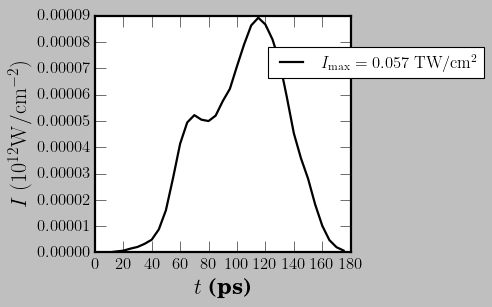

In [35]:
def get_report_pulse(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.5,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{$I_{\mathrm{max}}=0.057 ~\mathrm{TW/cm^2}$}'
    label2 = r'\textbf{$I_{\mathrm{max}}=0.12 ~\mathrm{TW/cm^2}$}'
    label3 = r'\textbf{$I_{\mathrm{max}}=0.54 ~\mathrm{TW/cm^2}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 

    unit_x = 1000
    unit_y = (100**-2)*(10**-12)
    ax1.plot(pulse_1[:,0]*unit_x,pulse_1[:,1]*unit_y,'-',c='k',lw=2,label=label1)
#     ax1.plot(pulse_2[:,0]*unit_x,pulse_2[:,1]*unit_y,'--',c='k',lw=2,label=label2)
#     ax1.plot(pulse_3[:,0]*unit_x,pulse_3[:,1]*unit_y,'-.',c='k',lw=2,label=label3)
    #ax1.plot(pulse_4[:,0]*unit_x,pulse_4[:,1]*unit_y)

    print('Imax_1 (TW/cm^2) = ',max(pulse_1[:,1]*unit_y))
#     print('Imax_2 (TW/cm^2) = ',max(pulse_2[:,1]*unit_y))
#     print('Imax_3 (TW/cm^2) = ',max(pulse_3[:,1]*unit_y))

    #ax1.set_xlim([10028,10034])
    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{$t$ (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$I ~(\mathrm{10^{12}W/cm^{-2}})$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='center',bbox_to_anchor=[1.1,0.8])

    plt.tight_layout()
    if exportFlag : 
        export_name = 'pulse_1_to_3_intensities'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report_pulse(exportFlag=0)              

## get_nc (critical density)

In [36]:
def get_nc(wavelength):
    
    # input wavelength unit : m
    # output nc unit : 1/m^3
    
    angular_freq = 2*math.pi*(lightSpeed/wavelength)
    ne_crit = vacuumPermittivity*massElectron*angular_freq**2/eCharge**2
    return ne_crit # (1/m^3)

## get_WPI

In [37]:
def Sumfunction(K1,K2,E1,E2,Nmax,x):
    summation = 0
    for n in range(0,Nmax+1):
        Z1 = math.pi**2*(2*math.modf(x+1)[1] - 2*x + n)
        Z2 = 2*K2*E2
        z = math.sqrt(Z1/Z2)
        summation += math.exp(-math.pi*n*(K1 - E1)/E2)*Phifunction(z)
    return summation
    
def Phifunction(z):
    integrand = lambda y: math.exp(y**2-z**2)
    phi = integrate.quad(integrand, 0, z)
    return phi[0]

def ellipK(x):
    integrand = lambda y: 1/math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def ellipE(x):
    integrand = lambda y: math.sqrt(1-x**2*math.sin(y)**2)
    output = integrate.quad(integrand, 0, math.pi/2)
    return output[0]

def check_idensity():
    x = 0.5
    
    identity_wrong = scipy.special.ellipk(x)*scipy.special.ellipe(math.sqrt(1-x**2)) + \
    scipy.special.ellipe(x)*scipy.special.ellipk(math.sqrt(1-x**2)) - \
    scipy.special.ellipk(x)*scipy.special.ellipk(math.sqrt(1-x**2))

    identity_correct = ellipK(x)*ellipE(math.sqrt(1-x**2)) + \
    ellipE(x)*ellipK(math.sqrt(1-x**2)) - ellipK(x)*ellipK(math.sqrt(1-x**2))

    print('x = ',x,', identity_correct = ',identity_correct,', identity_wrong = ',identity_wrong,)
    print('ellipE(x) = ',ellipE(x))
    print('ellipK(x) = ',ellipK(x))
    
check_idensity()    

def WPIfunction(laserI_IN,laserE,Nmax,omega_IN,bangGap):
    
    # laserI_IN unit : W/m^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # laserI unit : W/cm^2
    laserI = laserI_IN/100**2
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    elliptics = 0
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)
    
    return [WPI,WPI_appro]

def get_WPI(laserI,laserE,Nmax,omega_IN,bangGap):
    
    # laserI unit : W/cm^2
    # laserE unit : V/m
    # omega_IN unit : 1/s
    # bangGap  unit : J
    
    # definitions of gamma1 and gamma2 are different from Arnab
    gamma = omega_IN*math.sqrt(massElectronReduced*bangGap)/(eCharge*laserE)  
    gamma1 = gamma/(1+gamma**2)**0.5
    gamma2 = gamma1/gamma
    
    elliptics = 0
    if elliptics==0:
        K1 = scipy.special.ellipk(gamma1)
        K2 = scipy.special.ellipk(gamma2)
        E1 = scipy.special.ellipe(gamma1)
        E2 = scipy.special.ellipe(gamma2)
    elif elliptics==1:
        K1 = ellipk(gamma1)
        K2 = ellipk(gamma2)
        E1 = ellipe(gamma1)
        E2 = ellipe(gamma2)
    
    # L. V. Keldysh Eq.(38)
    bangGapEffective = 2*bangGap*E2/(math.pi*gamma1)
    x = bangGapEffective/(hbar*omega_IN)
    
    Qvalue = math.sqrt(math.pi/2/K2)*Sumfunction(K1,K2,E1,E2,Nmax,x)
    
    # Jack's WPI is about three times smaller than Arnab's WPI
    WPI = 2*omega_IN/(9*math.pi)*(omega_IN*massElectronReduced/(hbar*gamma1))**1.5*\
    Qvalue*math.exp(-math.pi*math.modf(x+1)[1]*(K1-E1)/E2)*10**-6 # 1/(s.cm^3)
    
    # laserI unit : J/(s.cm^2)
    # sigma2 unit : cm.s/J^2
    WPI_appro = sigma2*laserI**2 # 1/(s.cm^3)
    
    return WPI*100**3/2 # 1/(s.m^3)

laserI0 = 10000000000 # W/m^2
laserE1 = coef_laserI_eField*math.sqrt(laserI0) # V/m
laserE2 = math.sqrt(2*laserI0/(epsilon0*lightSpeed))  # V/m
W_PI , W_PI_appro = WPIfunction(laserI_IN=laserI0,laserE=laserE2,Nmax=50,
                                omega_IN=omega_355nm,bangGap=Eg_CH)
print()
print('laserI  [W/m^2] = ',laserI0)
print('laserE1 [V/m]   = ',laserE1)
print('laserE2 [V/m]   = ',laserE2)
print('laserE1/laserE2 = ',laserE1/laserE2,np.sqrt(2))
print('W_PI,W_PI_appro = ',W_PI , W_PI_appro,'[1/s/cm^3]')
print('W_PI/W_PI_appro = ',W_PI/W_PI_appro)

x =  0.5 , identity_correct =  1.5707963267948961 , identity_wrong =  0.8687815422231111
ellipE(x) =  1.4674622093394272
ellipK(x) =  1.6857503548125963

laserI  [W/m^2] =  10000000000
laserE1 [V/m]   =  2744952.840923973
laserE2 [V/m]   =  2744923.72749469
laserE1/laserE2 =  1.0000106062798726 1.4142135623730951
W_PI,W_PI_appro =  4.0160759500787345e+20 7e+20 [1/s/cm^3]
W_PI/W_PI_appro =  0.5737251357255335


## get_laserE

In [38]:
def get_laserE(laserI,RefractiveIndex):
    
    # input  laser intensity unit : W/m^2
    # output electric field  unit : V/m
    coef_laserI_eField = (2/lightSpeed/vacuumPermittivity/RefractiveIndex)**0.5
    
    return coef_laserI_eField*laserI**0.5 # V/m

## get_W1

In [39]:
def get_W1(laserE):
    
    # rate of one-photon absorption in the conduction band,
    # which evolves linearly with the laser intensity.
    # reference : L Barilleau et al 2016 J. Phys. D: Appl. Phys. 49 485103

    # input electric field  unit : V/m
    # output W1 unit : 1/s

    return 10**(-7)*laserE**2 # 1/s

## get_Ce

In [40]:
def get_Ce(n_fe):
    
    # input electron number density  unit : 1/m^3
    # output Ce unit : 1/m^3
    
    return 1.5*n_fe # 1/ m^3

## get_Ci

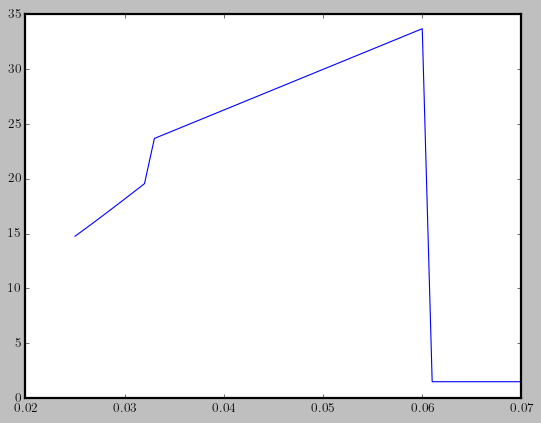

In [41]:
def get_Ci(n_a):    
    # input atomic number density  unit : 1/m^3
    # output Ci unit : 1/m^3    
    return 1.5*n_a # 1/ m^3

def get_Ci_new(n_a,Ti):
    
    # input n_a: 1/m^3
    # input Ti : J
    
    # T : K 
    T = Ti/eV/kelvin_to_eV
    
    #print(T)
    
    cp_solid_1 = 7.7551*10**5*T**(-2) + 0.53447*T - 41.58
    cp_solid_2 = 0.2653*T + 95.12
        
    if (T>=200) and (T<373)  : Ci = cp_solid_1*J_per_mole_per_K*n_a
        
    if (T>=373) and (T<700) : Ci = cp_solid_2*J_per_mole_per_K*n_a

    if (T>=700) : Ci = 1.5*n_a
    
    return Ci

if 1 :
    temp = [ T for T in np.arange(0.025,.07,.001)]
    Ci_new = np.array([ get_Ci_new(n_a_CH,T*eV) for T in temp ])
    plt.plot(temp,Ci_new/n_a_CH)

## get_G (V_c^{energy} energy relaxation rate)

1 / How long it takes for energy in excited state to initial state for electrons

In [42]:
def get_G(Ce,vc,Ti):
    
    # input collision frequency unit : 1/s
    # input Ce unit : 1/m^3 
    # output G unit : 1/m^3/s
    
    mS = (12+1)*8*amu
    mB = (12+1)*6*amu  
    mA = (12+1)*2*amu
    mCH = (12+1)/2*amu
    mC = 12*amu
    mH = 1*amu    
    
    if (Ti < 2.32*eV)  : mil = mH # (mS + mC + mH)/3
    if (Ti >= 2.32*eV) and (Ti < 2.43*eV) : mil = (mS+mB+mA)/3
    if (Ti >= 2.43*eV) and (Ti < 4.00*eV) : mil = mB
    if (Ti >= 4.00*eV) and (Ti < 8.00*eV) : mil = (mB+mA+mCH)/3
    if (Ti >= 8.00*eV) : mil = mCH
        
    me_to_mil = massElectron/mil
    
    #me_to_mil = 1/1836
    
    return Ce*vc*me_to_mil # 1/m^3/s

## get_n

In [43]:
def get_n(n_IN,omega_IN):
    
    # input n_IN : 1/m^3
    # input omega_IN : 1/s
    
    n_CGS = n_IN/100**3 # 1/cm^3
    
    omega_pe = np.sqrt(4*np.pi*n_CGS*eCharge_CGS**2/massElectron_CGS) # 1/s
    
    RefractiveIndex = np.sqrt(1-(omega_pe/omega_IN)**2) # unitless
    
    return RefractiveIndex # unitless

## get_JH

In [44]:
def get_JH(n_fe,vc,omega,laserE,RefractiveIndex):
    
    # input eCharge unit : Coulomb
    # input n_fe    unit : 1/m^3 
    # input vc      unit : 1/s
    # input massElectron unit : kg
    # input omega unit : 1/s
    # input laserE unit : V/m
    # input lightSpeed unit : m/s
    # input vacuumPermittivity unit : # C⋅V−1⋅m−1
    
    # output dUdt  unit : 1/m^3/s   
    # output sigma unit : 1/m
    
    dUdt  = eCharge**2*n_fe*vc/massElectron/(omega**2+vc**2)*laserE**2         # J/s/m^3
    #sigma = dUdt/(laserE**2)*2/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    sigma = dUdt/(laserE**2)/(lightSpeed*RefractiveIndex*vacuumPermittivity) # 1/m
    #sigma = vc/(RefractiveIndex*lightSpeed)
    return [dUdt,sigma]

## get_vr

In [45]:
def get_vr(ne,Te):
    
    # ne : 1/m^3
    # Te : J
    
    Te_eV = Te/eV      # eV
    ne_gcc = ne/100**3 # 1/cm^3
    
    tr = 1.8*10**26*Te_eV**4.5/ne_gcc**2 # s

    vr = 1/tr # 1/s
    
    return vr
    
print("{:.3e}".format(get_vr(4.5*10**19*100**3,10*eV))   )

3.558e+08


## get_vi

In [46]:
def get_vi(laserE,omega,Eg,vc):

    # input eCharge unit : Coulomb
    # input vc      unit : 1/s
    # input massElectron unit : kg
    # input omega unit : 1/s
    # input laserE unit : V/m
    # input lightSpeed unit : m/s
    # input vacuumPermittivity unit : # C⋅V−1⋅m−1
    
    vi  = eCharge**2*vc/massElectron/(omega**2+vc**2)*laserE**2/Eg_CH         # J/s
    
    return vi

laserE = get_laserE(laserI=5.7*10**10*100**2,RefractiveIndex=1)

print("{:.3e}".format(get_vi(laserE,omega_355nm,Eg_CH,10**15)))

6.406e+11


## get_main

In [ ]:
Thickness = 30 # um
Nz = int(Thickness*um/wavelength_355nm)
dz = wavelength_355nm # m
dt = dz/lightSpeed*10 # s

laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination
nc_355nm     = get_nc(wavelength_355nm) # (1/m^3)
nc_450nm     = get_nc(wavelength_450nm) # (1/m^3)

Ns_zone  = 6
Ns_edge  = 4
var_zone = np.zeros([Nz,Ns_zone])

print('Nz', Nz)
print('var_zone[0,0]', var_zone[0,0])
print('var_zone[0,0:2]', var_zone[0,0:2])

n_0 = 10**10*100**3 # 1/m^3 
n_1 = 0             # 1/m^3 
n_2 = 0             # 1/m^3 
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

var_zone[:,0] = n_0 # 1/m^3 
var_zone[:,1] = n_1 # 1/m^3 
var_zone[:,2] = n_2 # 1/m^3
var_zone[:,3] = Te  # J
var_zone[:,4] = Ti  # J

t_start_wall = timeCheck.time()
hist         = []

pulse_IN = pulse_1
pulse_IN_Imax_TimePs = pulse_1_Imax_TimePs

time         = 0                         # s
time_step    = 0
for time_step in range(pulse_IN.shape[0]*1):
    
    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ns   # s
    time_next    = pulse_IN[time_step+1,0]*ns # s
    ite_max      = int((time_next - time_current)/dt)
    
    ne_IN  = sum(var_zone[0,0:2])  # 1/m^3
    ne_OUT = sum(var_zone[-1,0:2]) # 1/m^3
    n_IN     = get_n(ne_IN,omega_355nm)  # unitless
    n_OUT    = get_n(ne_OUT,omega_355nm) # unitless 
    Te_IN    = var_zone[0,3]  # J
    Te_OUT   = var_zone[-1,3] # J 
    Ti_IN    = var_zone[0,4]  # J
    Ti_OUT   = var_zone[-1,4] # J     
    vc_IN    = get_vc_new(Te_IN,Ti_IN,ne_IN,n_a_CH,R_CH)   # 1/s
    vc_OUT   = get_vc_new(Te_OUT,Ti_OUT,ne_OUT,n_a_CH,R_CH)# 1/s    
    dU_IN, si_IN   = get_JH(ne_IN,vc_IN,omega_355nm,laserE,n_IN)
    dU_OUT, si_OUT = get_JH(ne_OUT,vc_OUT,omega_355nm,laserE,n_OUT) 
    Z_IN  = ne_IN/n_a_CH
    Z_OUT = ne_OUT/n_a_CH
    Z_QMD_IN  = get_Zeff(n_a_CH,Te_IN)
    Z_QMD_OUT = get_Zeff(n_a_CH,Te_OUT)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('Te_IN, Te_OUT = ',"{:.3e}".format(Te_IN/eV),"{:.3e}".format(Te_OUT/eV),'eV')
    print('Ti_IN, Ti_OUT = ',"{:.3e}".format(Ti_IN/eV),"{:.3e}".format(Ti_OUT/eV),'eV') 
    print('ne_IN, ne_OUT = ',"{:.3e}".format(ne_IN),"{:.3e}".format(ne_OUT),'1/m^3')
    print('vc_IN, vc_OUT = ',"{:.3e}".format(vc_IN),"{:.3e}".format(vc_OUT),'1/s')
    print('dU_IN, dU_OUT = ',"{:.3e}".format(dU_IN),"{:.3e}".format(dU_OUT),'J/s/m^3') 
    print('si_IN, si_OUT = ',"{:.3e}".format(si_IN),"{:.3e}".format(si_OUT),'1/m') 
    print('Z_IN,  Z_OUT  = ',"{:.3e}".format(Z_IN),"{:.3e}".format(Z_OUT)) 
    print('Z_QMD_IN,Z_QMD_OUT = ',"{:.3e}".format(Z_QMD_IN),"{:.3e}".format(Z_QMD_OUT))
    print('Te_max        = ',"{:.3e}".format(max(var_zone[:,3])/eV),'eV')
    print('Ti_max        = ',"{:.3e}".format(max(var_zone[:,4])/eV),'eV')    
    print('ite_max       = ',ite_max)    

    for ite in range(ite_max):
        
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = laserI_probe # W/m^2
        
        if 0 : 
            print()
            print('ite, time, n_fe_max, transimittance = ',
                  ite,
                  "{:.3e}".format(time),
                  "{:.3e}".format(n_fe_max),
                  "{:.3e}".format(laserI_probe/laserI_probe_INC),
                  "{:.3e}".format(laserI/laserI_INC))
            print('---')        

        for zone in range(1,Nz+1):
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            n_0 = var_zone[i_zone,0] # 1/m^3
            n_1 = var_zone[i_zone,1] # 1/m^3
            n_2 = var_zone[i_zone,2] # 1/m^3
            Te  = var_zone[i_zone,3] # J
            Ti  = var_zone[i_zone,4] # J  

            n_fe  = n_0 + n_1 + n_2          # 1/m^3
            beta  = (n_vb_CH - n_fe)/n_vb_CH # no unit
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            #vc_OLD  = get_vc(Te/eV,Ti/eV,n_fe,n_a_CH,1)               # 1/s
            vc      = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #vr      = get_vr(n_fe,Te) # 1/s
            #taur    = 1/vr # s
            #alpha   = get_vi(laserE,omega_355nm,Eg_CH,vc) # 1/s
            #####################################
            n       = get_n(n_fe,omega_355nm) # unitless  
            n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_355nm,Eg_CH) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s
            WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_355nm,laserE,n)
            dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_CH
            dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_CH
            laserI_new       = laserI       + dz * dIdz
            laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = laserI_probe_new         # W/m^2 

            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            var_zone[i_zone,0] = n_0_new # 1/m^3 
            var_zone[i_zone,1] = n_1_new # 1/m^3 
            var_zone[i_zone,2] = n_2_new # 1/m^3 

            #######################
            # Thermodynamics
            #######################
            #####################################
            #vc =  get_vc(Te,Ti,n_fe_new,n_a_CH,1) # 1/s 
            vc = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            print("Te",Te,"Ti",Ti, "n_fe", n_fe, "n_a_CH", n_a_CH, "R_CH", R_CH)
            #print('ite,vc = ',ite,vc)
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_355nm,laserE,n)
            Ce = get_Ce(n_fe_new) # 1/m^3
            Ci = get_Ci_new(n_a_CH,Ti)   # 1/m^3 
            G  = get_G(Ce,vc,Ti)     # 1/m^3/s
            #if Te <  Tc : G  = get_G(Ce,vc,'solid')     # 1/m^3/s
            #if Te >= Tc : G  = get_G(Ce,vc,'plasma')    # 1/m^3/s
            Qi = G*(Te-Ti)                             # J/s/m^3
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3            
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV     

            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            laserI_probe = laserI_probe_new

            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('Qe = ',Qe)
                break 

            if (laserI_new < 0) or (laserI_probe_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_355nm) or (n_fe_new > nc_450nm) :
                print('negative n_fe exceed nc detected, STOP')
                break             

            #print(zone,laserI/laserI_INC)
            #print(zone,"{:.3e}".format(laserI_probe),"{:.3e}".format(laserI_probe_INC))
            #print(zone,laserI,laserI_new,laserI_probe,laserI_probe_new)
            #print(zone,"{:.3e}".format(n_0_new),"{:.3e}".format(n_1_new),"{:.3e}".format(n_2_new),
            #      ' : ',"{:.3e}".format(n_0),"{:.3e}".format(n_1),"{:.3e}".format(n_2))
            #print(zone,time,Te_new,Ti_new,' : ',Te,Ti)
            #print(zone,"{:.3e}".format(zp),"{:.3e}".format(time))
            
        time = time + dt
                    
    sol = [ne_IN,#0
           ne_OUT,#1
           n_IN,#2
           n_OUT,#3
           Te_IN,#4
           Te_OUT,#5
           vc_IN,#6
           vc_OUT,#7
           dU_IN,#8
           dU_OUT,#9
           si_IN,#10
           si_OUT,#11
           Ti_IN,#12
           Ti_OUT,#13 
           Z_IN,#14
           Z_OUT,#15
           Z_QMD_IN,#16
           Z_QMD_OUT#17           
          ]
        
    hist.append([time,#0
                 laserI_probe/laserI_probe_INC,#1
                 laserI/laserI_INC,#2
                 var_zone,#3
                 var_edge,#4
                 sol#5
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',
          "{:.3e}".format(time_current/ps-pulse_IN_Imax_TimePs),
          "{:.3e}".format(laserI_probe/laserI_probe_INC),
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)    

Nz 84
var_zone[0,0] 0.0
var_zone[0,0:2] [0. 0.]
time_step    =  0
time         =  0.000e+00  ps
time_current =  0.000e+00  ps
time_next    =  5.000e+00  ps
dt           =  1.184e-14  s
Te_IN, Te_OUT =  2.500e-02 2.500e-02 eV
Ti_IN, Ti_OUT =  2.500e-02 2.500e-02 eV
ne_IN, ne_OUT =  1.000e+16 1.000e+16 1/m^3
vc_IN, vc_OUT =  1.486e+15 1.486e+15 1/s
dU_IN, dU_OUT =  5.924e+09 5.924e+09 J/s/m^3
si_IN, si_OUT =  5.196e-06 5.196e-06 1/m
Z_IN,  Z_OUT  =  3.333e-13 3.333e-13
Z_QMD_IN,Z_QMD_OUT =  1.183e-97 1.183e-97
Te_max        =  2.500e-02 eV
Ti_max        =  2.500e-02 eV
ite_max       =  422
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH

Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000000000000004e-21 Ti 4.0000000000000004e-21 n_fe 1e+16 n_a_CH 30000000000000000000000000000 R_CH

Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0000476804135246e-21 Ti 4.0000000000000004e-21 n_fe 9999881623058452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0


Te 4.000094900943351e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000094900943351e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000094900943351e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490094335e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490094335e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490094335e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490094335e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490094335e-21 Ti 4.0000000000000004e-21 n_fe 9999763247518666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00009490

Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0001416660228664e-21 Ti 4.0000000000000004e-21 n_fe 9999644873380630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0


Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000187980042769e-21 Ti 4.0000000000000004e-21 n_fe 9999526500644322.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000233847351465e-21 Ti 4.0000000000000004e-21 n_fe 9999408129309726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0002792722554834e-21 Ti 4.0000000000000004e-21 n_fe 9999289759376830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0


Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019878e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000324259019874e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019874e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000324259019874e-21 Ti 4.0000000000000004e-21 n_fe 9999171390845614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0003688118686246e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0003688118686246e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0003688118686246e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0003688118686246e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0003688118686246e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000368811868621e-21 Ti 4.0000000000000004e-21 n_fe 9999053023716062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00041293498501e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004129349850094e-21 Ti 4.0000000000000004e-21 n_fe 9998934657988158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000412934

Te 4.000456632512046e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000456632512046e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000456632512046e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004566325120455e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004566325120455e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004566325120455e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004566325120455e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000456632512045e-21 Ti 4.0000000000000004e-21 n_fe 9998816293661884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.000499908552822e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000499908552822e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000499908552822e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000499908552822e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004999085528214e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004999085528214e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004999085528214e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0004999085528214e-21 Ti 4.0000000000000004e-21 n_fe 9998697930737224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.000542767170914e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170914e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170914e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170913e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170913e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170912e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170912e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000542767170912e-21 Ti 4.0000000000000004e-21 n_fe 9998579569214164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0005852123907556e-21 Ti 4.0000000000000004e-21 n_fe 9998461209092680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0


Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000627248198016e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.00062724819801e-21 Ti 4.0000000000000004e-21 n_fe 9998342850372764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539974e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539974e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539974e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539974e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539974e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0006688785399735e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0006688785399735e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000668878539968e-21 Ti 4.0000000000000004e-21 n_fe 9998224493054396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000710107325881e-21 Ti 4.0000000000000004e-21 n_fe 9998106137137558.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000750938427344e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000750938427344e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000750938427344e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000750938427344e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000750938427343e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000750938427343e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0007509384273426e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0007509384273426e-21 Ti 4.0000000000000004e-21 n_fe 9997987782622234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000791375678657e-21 Ti 4.0000000000000004e-21 n_fe 9997869429508408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000831422877189e-21 Ti 4.0000000000000004e-21 n_fe 9997751077796064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783725e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000871083783717e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783717e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783717e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783717e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783717e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783716e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783715e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000871083783715e-21 Ti 4.0000000000000004e-21 n_fe 9997632727485184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000910362122812e-21 Ti 4.0000000000000004e-21 n_fe 9997514378575752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000

Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009492615831405e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00094926158314e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000949261583139e-21 Ti 4.0000000000000004e-21 n_fe 9997396031067752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.000987785817843e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000987785817843e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.000987785817843e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009877858178425e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009877858178425e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009877858178425e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009877858178425e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0009877858178425e-21 Ti 4.0000000000000004e-21 n_fe 9997277684961168.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.001025938444863e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444862e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444862e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444862e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444861e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444861e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444861e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001025938444861e-21 Ti 4.0000000000000004e-21 n_fe 9997159340255982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.0010637230472915e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0010637230472915e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001063723047291e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001063723047291e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00106372304729e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001063723047289e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001063723047289e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001063723047289e-21 Ti 4.0000000000000004e-21 n_fe 9997040996952178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001101143173689e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001101143173688e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001101143173687e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001101143173687e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001101143173687e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011011431736865e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011011431736865e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011011431736865e-21 Ti 4.0000000000000004e-21 n_fe 9996922655049740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.001138202338443e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001138202338443e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011382023384424e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011382023384424e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011382023384424e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011382023384424e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001138202338442e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001138202338442e-21 Ti 4.0000000000000004e-21 n_fe 9996804314548650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0011749040220706e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0011749040220706e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00117490402207e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00117490402207e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00117490402207e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00117490402207e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001174904022069e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001174904022069e-21 Ti 4.0000000000000004e-21 n_fe 9996685975448890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00117

Te 4.001211251671559e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001211251671559e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001211251671558e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001211251671558e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001211251671558e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001211251671558e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0012112516715575e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0012112516715575e-21 Ti 4.0000000000000004e-21 n_fe 9996567637750446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0012472487006825e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700682e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700682e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700682e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700682e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700681e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001247248700681e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00124724870068e-21 Ti 4.0000000000000004e-21 n_fe 9996449301453302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.001282898490328e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001282898490328e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0012828984903275e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0012828984903275e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001282898490327e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001282898490327e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001282898490326e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001282898490326e-21 Ti 4.0000000000000004e-21 n_fe 9996330966557440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0013182043888015e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001318204388801e-21 Ti 4.0000000000000004e-21 n_fe 9996212633062844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001353169712149e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001353169712149e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001353169712148e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001353169712148e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001353169712148e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001353169712148e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013531697121474e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013531697121474e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.001353169712131e-21 Ti 4.0000000000000004e-21 n_fe 9996094300969496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013877977444616e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013877977444616e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013877977444616e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013877977444616e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0013877977444616e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001387797744461e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001387797744461e-21 Ti 4.0000000000000004e-21 n_fe 9995975970277382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.001422091738193e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738193e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738192e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738192e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738192e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738192e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014220917381914e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014220917381914e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.001422091738179e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738178e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001422091738177e-21 Ti 4.0000000000000004e-21 n_fe 9995857640986484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.001456054914441e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001456054914441e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014560549144405e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014560549144405e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014560549144405e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00145605491444e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00145605491444e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00145605491444e-21 Ti 4.0000000000000004e-21 n_fe 9995739313096786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.001489690463304e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001489690463304e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001489690463303e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001489690463303e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001489690463303e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014896904633025e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014896904633025e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0014896904633025e-21 Ti 4.0000000000000004e-21 n_fe 9995620986608268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.001523001544105e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001523001544105e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0015230015441046e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0015230015441046e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001523001544104e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001523001544104e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001523001544103e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001523001544102e-21 Ti 4.0000000000000004e-21 n_fe 9995502661520918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0015559912857276e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285727e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285727e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285726e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285726e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285726e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285726e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001555991285726e-21 Ti 4.0000000000000004e-21 n_fe 9995384337834718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001588662786913e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001588662786913e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001588662786913e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001588662786912e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0015886627869115e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0015886627869115e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0015886627869115e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001588662786911e-21 Ti 4.0000000000000004e-21 n_fe 9995266015549648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.001621019116537e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001621019116536e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001621019116536e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001621019116536e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001621019116536e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0016210191165355e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0016210191165355e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0016210191165355e-21 Ti 4.0000000000000004e-21 n_fe 9995147694665698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0016530633139065e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0016530633139065e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313906e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313906e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313905e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313905e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313905e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313905e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313888e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001653063313887e-21 Ti 4.0000000000000004e-21 n_fe 9995029375182846.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.0016847983890176e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389017e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389017e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389016e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389016e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389016e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389015e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001684798389015e-21 Ti 4.0000000000000004e-21 n_fe 9994911057101076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001716227322911e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0017162273229104e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0017162273229104e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0017162273229104e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00171622732291e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00171622732291e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001716227322909e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001716227322909e-21 Ti 4.0000000000000004e-21 n_fe 9994792740420374.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001747353067855e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067855e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067855e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067855e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067854e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067854e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067854e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001747353067854e-21 Ti 4.0000000000000004e-21 n_fe 9994674425140724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.00177817854768e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00177817854768e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00177817854768e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778178547679e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778178547679e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778178547679e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778178547679e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778178547679e-21 Ti 4.0000000000000004e-21 n_fe 9994556111262104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001778

Te 4.001808706658029e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658029e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658029e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658028e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658027e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658027e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001808706658027e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018087066580266e-21 Ti 4.0000000000000004e-21 n_fe 9994437798784502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001838940266657e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001838940266656e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001838940266656e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001838940266656e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001838940266656e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018389402666554e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018389402666554e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018389402666554e-21 Ti 4.0000000000000004e-21 n_fe 9994319487707898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.001868882213668e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213668e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213667e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213666e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213666e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213666e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213666e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213666e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.001868882213649e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213649e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213649e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213649e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213648e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001868882213647e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018688822136466e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018688822136466e-21 Ti 4.0000000000000004e-21 n_fe 9994201178032280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00189853531178e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00189853531178e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018985353117795e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018985353117795e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0018985353117795e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001898535311779e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001898535311778e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001898535311777e-21 Ti 4.0000000000000004e-21 n_fe 9994082869757628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001927902346654e-21 Ti 4.0000000000000004e-21 n_fe 9993964562883928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001

Te 4.0019569860770646e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077064e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077064e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077064e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077063e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077063e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077062e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001956986077062e-21 Ti 4.0000000000000004e-21 n_fe 9993846257411162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0019857892351875e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0019857892351875e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0019857892351875e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001985789235187e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001985789235186e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001985789235185e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001985789235185e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.001985789235185e-21 Ti 4.0000000000000004e-21 n_fe 9993727953339312.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002014314526899e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002014314526898e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020143145268976e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020143145268976e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020143145268976e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002014314526897e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002014314526897e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002014314526897e-21 Ti 4.0000000000000004e-21 n_fe 9993609650668364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002042564631965e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002042564631964e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002042564631963e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002042564631963e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002042564631963e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020425646319624e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020425646319624e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020425646319624e-21 Ti 4.0000000000000004e-21 n_fe 9993491349398300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002070542204348e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204347e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204347e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020705422043464e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204346e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204345e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204345e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002070542204345e-21 Ti 4.0000000000000004e-21 n_fe 9993373049529102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002098249872409e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002098249872409e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002098249872409e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020982498724085e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020982498724085e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020982498724085e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0020982498724085e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002098249872408e-21 Ti 4.0000000000000004e-21 n_fe 9993254751060756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.00212569023919e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00212569023919e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00212569023919e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00212569023919e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0021256902391896e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002125690239189e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002125690239189e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002125690239189e-21 Ti 4.0000000000000004e-21 n_fe 9993136453993244.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002125

Te 4.002152865882637e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0021528658826364e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0021528658826364e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002152865882636e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002152865882636e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002152865882636e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002152865882636e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002152865882635e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.002152865882612e-21 Ti 4.0000000000000004e-21 n_fe 9993018158326552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355853e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355853e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355853e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355852e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355852e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355851e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355851e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.00217977935583e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0021797793558294e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355829e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355828e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002179779355828e-21 Ti 4.0000000000000004e-21 n_fe 9992899864060656.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187327e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187327e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187327e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002206433187308e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187307e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187307e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187307e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187306e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187306e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002206433187306e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022064331873056e-21 Ti 4.0000000000000004e-21 n_fe 9992781571195548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002232829881168e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002232829881167e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022328298811664e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022328298811664e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002232829881166e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002232829881165e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002232829881164e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022328298811634e-21 Ti 4.0000000000000004e-21 n_fe 9992663279731208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002258971917382e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002258971917382e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002258971917382e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002258971917382e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022589719173816e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022589719173816e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022589719173816e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002258971917381e-21 Ti 4.0000000000000004e-21 n_fe 9992544989667618.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002284861752039e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752039e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752038e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752038e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752038e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752038e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002284861752038e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0022848617520376e-21 Ti 4.0000000000000004e-21 n_fe 9992426701004764.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002310501817533e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817533e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817533e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817533e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817532e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817532e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817532e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002310501817532e-21 Ti 4.0000000000000004e-21 n_fe 9992308413742626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.00233589452282e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00233589452282e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00233589452282e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00233589452282e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002335894522819e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002335894522819e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002335894522819e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002335894522819e-21 Ti 4.0000000000000004e-21 n_fe 9992190127881192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0023358

Te 4.002361042253638e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253638e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253638e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253637e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253636e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253636e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002361042253636e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0023610422536356e-21 Ti 4.0000000000000004e-21 n_fe 9992071843420442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002385947372727e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372727e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0023859473727265e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372726e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372726e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372726e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372726e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002385947372725e-21 Ti 4.0000000000000004e-21 n_fe 9991953560360360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002410612220048e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220048e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0024106122200476e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0024106122200476e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220047e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220047e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220047e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220047e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.002410612220026e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002410612220025e-21 Ti 4.0000000000000004e-21 n_fe 9991835278700930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002435039112982e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002435039112982e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002435039112981e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002435039112981e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002435039112981e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00243503911298e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0024350391129794e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002435039112979e-21 Ti 4.0000000000000004e-21 n_fe 9991716998442136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346636e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346635e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002459230346635e-21 Ti 4.0000000000000004e-21 n_fe 9991598719583960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002483188193929e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193929e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0024831881939286e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193928e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193928e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193928e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193927e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002483188193927e-21 Ti 4.0000000000000004e-21 n_fe 9991480442126386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002506914905887e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002506914905886e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002506914905886e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002506914905886e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025069149058855e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025069149058855e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002506914905885e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002506914905884e-21 Ti 4.0000000000000004e-21 n_fe 9991362166069398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0025304127118436e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711843e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711843e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711843e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711842e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711842e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002530412711841e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025304127118406e-21 Ti 4.0000000000000004e-21 n_fe 9991243891412980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0025536838196355e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819635e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002553683819634e-21 Ti 4.0000000000000004e-21 n_fe 9991125618157112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00257673041582e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002576730415819e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0025767304158185e-21 Ti 4.0000000000000004e-21 n_fe 9991007346301780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.0025995546658736e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665873e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665872e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665872e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665872e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665872e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665872e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002599554665871e-21 Ti 4.0000000000000004e-21 n_fe 9990889075846968.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0026221587143824e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002622158714382e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002622158714382e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002622158714382e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002622158714381e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002622158714381e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00262215871438e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026221587143794e-21 Ti 4.0000000000000004e-21 n_fe 9990770806792660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002644544685285e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685285e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685285e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685285e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026445446852846e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685284e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685284e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002644544685284e-21 Ti 4.0000000000000004e-21 n_fe 9990652539138836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002666714682015e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002666714682015e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026667146820154e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026667146820154e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002666714682015e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002666714682014e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002666714682014e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002666714682014e-21 Ti 4.0000000000000004e-21 n_fe 9990534272885482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.002688670787743e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026886707877426e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026886707877426e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0026886707877426e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002688670787742e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002688670787741e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002688670787741e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002688670787741e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0026886707877215e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002688670787721e-21 Ti 4.0000000000000004e-21 n_fe 9990416008032582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065563e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065562e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065562e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027104150655615e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027104150655615e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065561e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0027104150655404e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027104150655404e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027104150655404e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00271041506554e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065539e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065538e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065538e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002710415065538e-21 Ti 4.0000000000000004e-21 n_fe 9990297744580118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.002731949558641e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00273194955864e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002731949558639e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027319495586385e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002731949558638e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002731949558638e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002731949558638e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002731949558637e-21 Ti 4.0000000000000004e-21 n_fe 9990179482528074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002753276290504e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002753276290504e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002753276290504e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002753276290503e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002753276290502e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027532762905016e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027532762905016e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027532762905016e-21 Ti 4.0000000000000004e-21 n_fe 9990061221876432.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0027743972651365e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027743972651365e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002774397265136e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002774397265135e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002774397265135e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002774397265134e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027743972651335e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002774397265133e-21 Ti 4.0000000000000004e-21 n_fe 9989942962625176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002795314467197e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467197e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467197e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467196e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467195e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467195e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002795314467195e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0027953144671945e-21 Ti 4.0000000000000004e-21 n_fe 9989824704774290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.002816029862208e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862208e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862208e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0028160298622075e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862207e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862207e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862207e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002816029862206e-21 Ti 4.0000000000000004e-21 n_fe 9989706448323758.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0028365453967625e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0028365453967625e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0028365453967625e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002836545396762e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002836545396761e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002836545396761e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002836545396761e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00283654539676e-21 Ti 4.0000000000000004e-21 n_fe 9989588193273562.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0028568629986665e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998666e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998666e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998665e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998665e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998664e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998664e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002856862998664e-21 Ti 4.0000000000000004e-21 n_fe 9989469939623686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0028769845771404e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00287698457714e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00287698457714e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00287698457714e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00287698457714e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002876984577139e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002876984577138e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002876984577138e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002876

Te 4.002876984577111e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00287698457711e-21 Ti 4.0000000000000004e-21 n_fe 9989351687374114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00289691202301e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912023009e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912023009e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912023008e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912023008e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0028969120230075e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0028

Te 4.002896912022983e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002896912022982e-21 Ti 4.0000000000000004e-21 n_fe 9989233436524830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002

Te 4.002916647208837e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002916647208837e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029166472088366e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029166472088366e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029166472088366e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002916647208836e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002916647208835e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002916647208834e-21 Ti 4.0000000000000004e-21 n_fe 9989115187075816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.002936191989192e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002936191989192e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002936191989192e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002936191989191e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002936191989191e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029361919891906e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00293619198919e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00293619198919e-21 Ti 4.0000000000000004e-21 n_fe 9988996939027058.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029

Te 4.002955548200718e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029555482007176e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029555482007176e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002955548200717e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002955548200716e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002955548200715e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029555482007145e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029555482007145e-21 Ti 4.0000000000000004e-21 n_fe 9988878692378536.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.002974717662344e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002974717662344e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002974717662343e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029747176623425e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029747176623425e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002974717662342e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002974717662342e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002974717662342e-21 Ti 4.0000000000000004e-21 n_fe 9988760447130234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.002993702175479e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175478e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175477e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175477e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175477e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175477e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.002993702175477e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0029937021754765e-21 Ti 4.0000000000000004e-21 n_fe 9988642203282134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00301250352415e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00301250352415e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00301250352415e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00301250352415e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524149e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524148e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524148e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524148e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0030125

Te 4.0030125035241226e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524122e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003012503524121e-21 Ti 4.0000000000000004e-21 n_fe 9988523960834222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00303112347519e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003031123475189e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003031123475189e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0030311234751886e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0030311234751886e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0030311234751585e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003031123475158e-21 Ti 4.0000000000000004e-21 n_fe 9988405719786484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003049563778394e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003049563778393e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003049563778393e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003049563778392e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003049563778392e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0030495637783914e-21 Ti 4.0000000000000004e-21 n_fe 9988287480138898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0030678261666845e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166684e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166684e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166683e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166683e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166683e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166683e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003067826166682e-21 Ti 4.0000000000000004e-21 n_fe 9988169241891452.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003085912356279e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356278e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356278e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356278e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356278e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0030859123562774e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356277e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003085912356277e-21 Ti 4.0000000000000004e-21 n_fe 9988051005044124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0031038240468395e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031038240468395e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031038240468395e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003103824046839e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003103824046838e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003103824046838e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003103824046838e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003103824046838e-21 Ti 4.0000000000000004e-21 n_fe 9987932769596904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003121562921645e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921645e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921644e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921643e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921643e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921643e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921643e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921643e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.0031215629216185e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921618e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921617e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921616e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031215629216155e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003121562921615e-21 Ti 4.0000000000000004e-21 n_fe 9987814535549770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647741e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00313913064774e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0031391306477145e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647714e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647713e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647713e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647712e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647712e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647712e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003139130647712e-21 Ti 4.0000000000000004e-21 n_fe 9987696302902706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0031565288760706e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031565288760706e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031565288760706e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00315652887607e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00315652887607e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00315652887607e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003156528876069e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003156528876068e-21 Ti 4.0000000000000004e-21 n_fe 9987578071655700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003173759241734e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003173759241734e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003173759241733e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003173759241733e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003173759241733e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003173759241732e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031737592417314e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031737592417314e-21 Ti 4.0000000000000004e-21 n_fe 9987459841808730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003190823363988e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003190823363988e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003190823363987e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031908233639865e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031908233639865e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0031908233639865e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003190823363986e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003190823363986e-21 Ti 4.0000000000000004e-21 n_fe 9987341613361782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0032077228465e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032077228465e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032077228465e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003207722846499e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003207722846498e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003207722846498e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003207722846498e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032077228464976e-21 Ti 4.0000000000000004e-21 n_fe 9987223386314840.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00320772

Te 4.0032244592774715e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032244592774715e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032244592774715e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032244592774715e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003224459277471e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00322445927747e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00322445927747e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00322445927747e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0032244592774414e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003224459277441e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00322445927744e-21 Ti 4.0000000000000004e-21 n_fe 9987105160667886.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032410342297956e-21 Ti 4.0000000000000004e-21 n_fe 9986986936420906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003241034229795e-21 Ti 4.0000000000000004e-21 n_fe 9986986936420906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003241034229795e-21 Ti 4.0000000000000004e-21 n_fe 9986986936420906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003241034229794e-21 Ti 4.0000000000000004e-21 n_fe 9986986936420906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003241034229794e-21 Ti 4.0000000000000004e-21 n_fe 9986986936420906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0032574492611914e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032574492611914e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261191e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261191e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325744926119e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325744926119e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325744926119e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325744926119e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325

Te 4.003257449261161e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261161e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261161e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261161e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261161e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032574492611606e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00325744926116e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003257449261159e-21 Ti 4.0000000000000004e-21 n_fe 9986868713573880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003273705914335e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914334e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914334e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914334e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914333e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0032737059143326e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914332e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003273705914332e-21 Ti 4.0000000000000004e-21 n_fe 9986750492126794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0032898057171105e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00328980571711e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00328980571711e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00328980571711e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003289805717109e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003289805717109e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003289805717109e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003289805717108e-21 Ti 4.0000000000000004e-21 n_fe 9986632272079628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00328

Te 4.003305750182568e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182567e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033057501825665e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182566e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182565e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182565e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182565e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003305750182564e-21 Ti 4.0000000000000004e-21 n_fe 9986514053432370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003321540809219e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809219e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809218e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809217e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033215408092164e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809216e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809215e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003321540809215e-21 Ti 4.0000000000000004e-21 n_fe 9986395836185000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003337179081102e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003337179081102e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003337179081101e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033371790811005e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033371790811005e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033371790811e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003337179081099e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003337179081098e-21 Ti 4.0000000000000004e-21 n_fe 9986277620337502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003352666467955e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679545e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679545e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679545e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679545e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467954e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467953e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467953e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.003352666467925e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679244e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679244e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679244e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033526664679244e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467924e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467923e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003352666467922e-21 Ti 4.0000000000000004e-21 n_fe 9986159405889860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.003368004425318e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033680044253175e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003368004425317e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003368004425317e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003368004425316e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003368004425315e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033680044253145e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003368004425314e-21 Ti 4.0000000000000004e-21 n_fe 9986041192842056.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0033831943947584e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033831943947584e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003383194394758e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003383194394757e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003383194394756e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033831943947554e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033831943947554e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003383194394755e-21 Ti 4.0000000000000004e-21 n_fe 9985922981194078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.003398237803898e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003398237803897e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003398237803896e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003398237803896e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003398237803896e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033982378038955e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033982378038955e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0033982378038955e-21 Ti 4.0000000000000004e-21 n_fe 9985804770945904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003413136066577e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003413136066576e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034131360665756e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034131360665756e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003413136066575e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003413136066575e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003413136066575e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003413136066574e-21 Ti 4.0000000000000004e-21 n_fe 9985686562097518.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003427890583016e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003427890583015e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034278905830146e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034278905830146e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034278905830146e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003427890583014e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003427890583013e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003427890583013e-21 Ti 4.0000000000000004e-21 n_fe 9985568354648908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003442502739939e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034425027399385e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034425027399385e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034425027399385e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003442502739938e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003442502739937e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003442502739936e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034425027399355e-21 Ti 4.0000000000000004e-21 n_fe 9985450148600054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.003456973910682e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003456973910681e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003456973910681e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003456973910681e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034569739106804e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00345697391068e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00345697391068e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003456973910679e-21 Ti 4.0000000000000004e-21 n_fe 9985331943950942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034

Te 4.003471305455359e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003471305455359e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034713054553586e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003471305455358e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003471305455357e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003471305455356e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034713054553556e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034713054553556e-21 Ti 4.0000000000000004e-21 n_fe 9985213740701552.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003485498720946e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720946e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720946e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720945e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720944e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034854987209434e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720943e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003485498720942e-21 Ti 4.0000000000000004e-21 n_fe 9985095538851866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0034995550414304e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034995550414304e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0034995550414304e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00349955504143e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003499555041429e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003499555041429e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003499555041428e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003499555041427e-21 Ti 4.0000000000000004e-21 n_fe 9984977338401874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003513475737957e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737956e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737956e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737956e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737956e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737956e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035134757379555e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003513475737955e-21 Ti 4.0000000000000004e-21 n_fe 9984859139351554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0035272621189015e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189015e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189015e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003527262118901e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035272621189e-21 Ti 4.0000000000000004e-21 n_fe 9984740941700890.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00352726

Te 4.003540915480025e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003540915480024e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154800236e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te

Te 4.003540915479993e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003540915479992e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003540915479991e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035409154799905e-21 Ti 4.0000000000000004e-21 n_fe 9984622745449868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104609e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104608e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104608e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104607e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0035544371045725e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104572e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003554437104571e-21 Ti 4.0000000000000004e-21 n_fe 9984504550598468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035678282635396e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263539e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263539e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263538e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263537e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003567828263512e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263511e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00356782826351e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035678282635095e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035678282635095e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263509e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263508e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003567828263507e-21 Ti 4.0000000000000004e-21 n_fe 9984386357146678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00358109021543e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215429e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215429e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215428e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035810902154274e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215427e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215426e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003581090215426e-21 Ti 4.0000000000000004e-21 n_fe 9984268165094478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.0035942242068445e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003594224206844e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003594224206843e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003594224206842e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003594224206842e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003594224206842e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035942242068415e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0035942242068415e-21 Ti 4.0000000000000004e-21 n_fe 9984149974441852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0036072314722194e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003607231472219e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003607231472218e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003607231472217e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036072314722164e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036072314722164e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003607231472216e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003607231472215e-21 Ti 4.0000000000000004e-21 n_fe 9984031785188782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003620113234131e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003620113234131e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003620113234131e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00362011323413e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036201132341296e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036201132341296e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036201132341296e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003620113234129e-21 Ti 4.0000000000000004e-21 n_fe 9983913597335256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0036328707033544e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036328707033544e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036328707033544e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003632870703354e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003632870703353e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003632870703353e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003632870703353e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003632870703352e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0036328707033205e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00363287070332e-21 Ti 4.0000000000000004e-21 n_fe 9983795410881252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078993e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078992e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078992e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036455050789914e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078991e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00364550507899e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003645505078957e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078956e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078955e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036455050789546e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078954e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003645505078953e-21 Ti 4.0000000000000004e-21 n_fe 9983677225826756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548579e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548578e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003658017548548e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548547e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548547e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036580175485465e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548546e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548545e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548544e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003658017548544e-21 Ti 4.0000000000000004e-21 n_fe 9983559042171750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00367040928816e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00367040928816e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036704092881594e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003670409288159e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003670409288158e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003670409288157e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036704092881564e-21 Ti 4.0000000000000004e-21 n_fe 9983440859916222.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462591e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003682681462563e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462562e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462561e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036826814625605e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00368268146256e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462559e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462559e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003682681462558e-21 Ti 4.0000000000000004e-21 n_fe 9983322679060150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003694835225233e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003694835225233e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003694835225232e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003694835225231e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036948352252304e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00369483522523e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00369483522523e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003694835225229e-21 Ti 4.0000000000000004e-21 n_fe 9983204499603520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0036

Te 4.0037068717185624e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003706871718562e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003706871718562e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003706871718561e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003706871718561e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00370687171856e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037068717185594e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003706871718559e-21 Ti 4.0000000000000004e-21 n_fe 9983086321546316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003718792073926e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003718792073925e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037187920739245e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003718792073924e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003718792073923e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003718792073923e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003718792073922e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037187920739215e-21 Ti 4.0000000000000004e-21 n_fe 9982968144888520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003730597411763e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003730597411763e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037305974117625e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003730597411762e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003730597411761e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00373059741176e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00373059741176e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00373059741176e-21 Ti 4.0000000000000004e-21 n_fe 9982849969630116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00373

Te 4.003742288841716e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841715e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037422888417146e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841714e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841714e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841714e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841713e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003742288841712e-21 Ti 4.0000000000000004e-21 n_fe 9982731795771086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0037538674627155e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037538674627155e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003753867462715e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003753867462714e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003753867462714e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003753867462713e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037538674627125e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003753867462712e-21 Ti 4.0000000000000004e-21 n_fe 9982613623311416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003765334363119e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363119e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363118e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363117e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037653343631166e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363116e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363115e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003765334363114e-21 Ti 4.0000000000000004e-21 n_fe 9982495452251088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0037766906207615e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003776690620761e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003776690620761e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00377669062076e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00377669062076e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00377669062076e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003776690620759e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037766906207585e-21 Ti 4.0000000000000004e-21 n_fe 9982377282590084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037

Te 4.003787937303089e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003787937303088e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003787937303087e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003787937303087e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037879373030864e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037879373030864e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037879373030864e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003787937303086e-21 Ti 4.0000000000000004e-21 n_fe 9982259114328392.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.003799075467261e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00379907546726e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003799075467259e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0037

Te 4.00379907546722e-21 Ti 4.0000000000000004e-21 n_fe 9982140947465992.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038101061602264e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160226e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160225e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160224e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038101061602234e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160223e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160223e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003810106160192e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160191e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00381010616019e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00381010616019e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038101061601895e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160189e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160188e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003810106160187e-21 Ti 4.0000000000000004e-21 n_fe 9982022782002866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038

Te 4.003821030418812e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003821030418812e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003821030418811e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00382103041881e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038210304188096e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038210304188096e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003821030418809e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003821030418808e-21 Ti 4.0000000000000004e-21 n_fe 9981904617939002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00383184926994e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038318492699395e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003831849269939e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003831849269938e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003831849269938e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003831849269937e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038318492699364e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003831849269936e-21 Ti 4.0000000000000004e-21 n_fe 9981786455274378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003842563730522e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003842563730521e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038425637305205e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038425637305205e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00384256373052e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00384256373052e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00384256373052e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003842563730519e-21 Ti 4.0000000000000004e-21 n_fe 9981668294008982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038

Te 4.003853174807701e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807701e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807701e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807701e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038531748077004e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038531748077e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807699e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807699e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038

Te 4.0038531748076635e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807663e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807662e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003853174807661e-21 Ti 4.0000000000000004e-21 n_fe 9981550134142796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498909e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038636834989086e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498908e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498907e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0038636834988755e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498875e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498874e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498873e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038636834988725e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498872e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498872e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003863683498871e-21 Ti 4.0000000000000004e-21 n_fe 9981431975675802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00387409079191e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00387409079191e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038740907919094e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003874090791909e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003874090791908e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003874090791907e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003874090791906e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003874090791906e-21 Ti 4.0000000000000004e-21 n_fe 9981313818607984.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038

Te 4.003884397665052e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003884397665052e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003884397665051e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00388439766505e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038843976650496e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003884397665049e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003884397665049e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003884397665048e-21 Ti 4.0000000000000004e-21 n_fe 9981195662939328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.00389460508716e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003894605087159e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003894605087159e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038946050871586e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003894605087158e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003894605087157e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003894605087156e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0038946050871555e-21 Ti 4.0000000000000004e-21 n_fe 9981077508669814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003904714017719e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017718e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017717e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017717e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039047140177165e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017716e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017715e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003904714017714e-21 Ti 4.0000000000000004e-21 n_fe 9980959355799426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00391472540696e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406959e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406959e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406958e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039147254069576e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406957e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406956e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003914725406955e-21 Ti 4.0000000000000004e-21 n_fe 9980841204328150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003

Te 4.003924640195973e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039246401959725e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003924640195972e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003924640195972e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003924640195971e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00392464019597e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039246401959695e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039246401959695e-21 Ti 4.0000000000000004e-21 n_fe 9980723054255966.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003934459316755e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316754e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316754e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316754e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039344593167535e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316753e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316753e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003934459316752e-21 Ti 4.0000000000000004e-21 n_fe 9980604905582860.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003944183692314e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039441836923136e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692313e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692312e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692312e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692312e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692312e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692312e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003944183692276e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692275e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039441836922744e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692274e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692273e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003944183692272e-21 Ti 4.0000000000000004e-21 n_fe 9980486758308814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039538142367496e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236749e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003953814236715e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236714e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039538142367135e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236713e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236712e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236712e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003953814236711e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039538142367105e-21 Ti 4.0000000000000004e-21 n_fe 9980368612433812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.003963351855321e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003963351855321e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00396335185532e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003963351855319e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039633518553186e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039633518553186e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003963351855318e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003963351855317e-21 Ti 4.0000000000000004e-21 n_fe 9980250467957836.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003972797444643e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039727974446424e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003972797444642e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003972797444641e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003972797444641e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00397279744464e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039727974446394e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003972797444639e-21 Ti 4.0000000000000004e-21 n_fe 9980132324880872.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.003982151892603e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003982151892602e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003982151892602e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003982151892601e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039821518926005e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039821518926e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003982151892599e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003982151892598e-21 Ti 4.0000000000000004e-21 n_fe 9980014183202902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039

Te 4.003991416078528e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078527e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078527e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0039914160785265e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078526e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078526e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078525e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.003991416078524e-21 Ti 4.0000000000000004e-21 n_fe 9979896042923910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004000590873282e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040005908732816e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040005908732816e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040005908732816e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004000590873281e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00400059087328e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004000590873279e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040005908732786e-21 Ti 4.0000000000000004e-21 n_fe 9979777904043880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00400967713932e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004009677139319e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004009677139318e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040096771393174e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040096771393174e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040096771393174e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040096771393174e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040096771393174e-21 Ti 4.0000000000000004e-21 n_fe 9979659766562794.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0040186757307885e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730788e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730788e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730788e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730787e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730786e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040186757307855e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730785e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004018675730749e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730748e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730747e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040186757307464e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730746e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004018675730745e-21 Ti 4.0000000000000004e-21 n_fe 9979541630480636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493588e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493587e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004027587493555e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493554e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493554e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040275874935535e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493553e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493552e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004027587493551e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040275874935505e-21 Ti 4.0000000000000004e-21 n_fe 9979423495797390.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004036413265421e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004036413265421e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040364132654205e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00403641326542e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004036413265419e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004036413265418e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040364132654175e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040364132654175e-21 Ti 4.0000000000000004e-21 n_fe 9979305362513036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004045153876018e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004045153876017e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004045153876016e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040451538760154e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040451538760154e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004045153876015e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004045153876014e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004045153876013e-21 Ti 4.0000000000000004e-21 n_fe 9979187230627564.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004053810147001e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810147e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810147e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810146999e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040538101469986e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810146998e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810146997e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004053810146996e-21 Ti 4.0000000000000004e-21 n_fe 9979069100140952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00405381

Te 4.004062382892093e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004062382892092e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004062382892091e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040623828920906e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00406238289209e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00406238289209e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004062382892089e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004062382892088e-21 Ti 4.0000000000000004e-21 n_fe 9978950971053186.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040

Te 4.0040708729171824e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004070872917182e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004070872917181e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00407087291718e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00407087291718e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040708729171794e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004070872917179e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004070872917178e-21 Ti 4.0000000000000004e-21 n_fe 9978832843364246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0040792810203825e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004079281020382e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004079281020381e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00407928102038e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040792810203795e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004079281020379e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004079281020378e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004079281020378e-21 Ti 4.0000000000000004e-21 n_fe 9978714717074120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004087607992085e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004087607992084e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004087607992084e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040876079920835e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004087607992083e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004087607992082e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004087607992081e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040876079920805e-21 Ti 4.0000000000000004e-21 n_fe 9978596592182788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004095854615083e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040958546150825e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004095854615082e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004095854615081e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00409585461508e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0040958546150795e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004095854615079e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004095854615079e-21 Ti 4.0000000000000004e-21 n_fe 9978478468690236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004104021664604e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004104021664603e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004104021664603e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041040216646025e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004104021664602e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004104021664601e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004104021664601e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041040216646e-21 Ti 4.0000000000000004e-21 n_fe 9978360346596446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041

Te 4.0041121099084005e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041121099084e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004112109908399e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004112109908399e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004112109908399e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004112109908399e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004112109908398e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041121099083975e-21 Ti 4.0000000000000004e-21 n_fe 9978242225901404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0041201201068155e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106815e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106815e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106815e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106815e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106814e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004120120106813e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041201201068125e-21 Ti 4.0000000000000004e-21 n_fe 9978124106605088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004128053012872e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012871e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00412805301287e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041280530128696e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012869e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012869e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012869e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012868e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004128053012833e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012832e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012831e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041280530128305e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041280530128305e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00412805301283e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012829e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004128053012829e-21 Ti 4.0000000000000004e-21 n_fe 9978005988707486.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004135909372274e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004135909372273e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004135909372272e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041359093722715e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041359093722715e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004135909372271e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00413590937227e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004135909372269e-21 Ti 4.0000000000000004e-21 n_fe 9977887872208580.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004143689923647e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004143689923646e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041436899236455e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004143689923645e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004143689923644e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004143689923643e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041436899236425e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041436899236425e-21 Ti 4.0000000000000004e-21 n_fe 9977769757108354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004151395398387e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004151395398387e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004151395398386e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004151395398385e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041513953983846e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041513953983846e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004151395398384e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004151395398383e-21 Ti 4.0000000000000004e-21 n_fe 9977651643406790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004159026520874e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004159026520873e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041590265208724e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004159026520872e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004159026520871e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004159026520871e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00415902652087e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004159026520869e-21 Ti 4.0000000000000004e-21 n_fe 9977533531103874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004166584008477e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004166584008476e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041665840084756e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004166584008475e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004166584008474e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004166584008473e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041665840084726e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041665840084726e-21 Ti 4.0000000000000004e-21 n_fe 9977415420199586.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004174068571673e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004174068571672e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004174068571672e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004174068571671e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004174068571671e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004174068571671e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041740685716706e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00417406857167e-21 Ti 4.0000000000000004e-21 n_fe 9977297310693910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0041814809140635e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004181480914063e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004181480914063e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004181480914063e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004181480914062e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004181480914061e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041814809140605e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00418148091406e-21 Ti 4.0000000000000004e-21 n_fe 9977179202586834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004188821732487e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732486e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732486e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732486e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732486e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732485e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041888217324844e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732484e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004188821732445e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041888217324445e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004188821732444e-21 Ti 4.0000000000000004e-21 n_fe 9977061095878336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041960917170315e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004196091717031e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00419609171703e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004196091717029e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041960917170285e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004196091716985e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004196091716984e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0041960917169834e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004196091716983e-21 Ti 4.0000000000000004e-21 n_fe 9976942990568404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00420329155114e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004203291551139e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042032915511385e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004203291551138e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004203291551092e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004203291551091e-21 Ti 4.0000000000000004e-21 n_fe 9976824886657016.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042104219116666e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004210421911666e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004210421911665e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004210421911664e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042104219116636e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004210421911663e-21 Ti 4.0000000000000004e-21 n_fe 9976706784144160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0042174834689305e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00421748346893e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004217483468929e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004217483468928e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042174834689275e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042174834689275e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042174834689275e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004217483468927e-21 Ti 4.0000000000000004e-21 n_fe 9976588683029820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004224476886787e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886787e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886786e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042244768867854e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886785e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886784e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886784e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004224476886784e-21 Ti 4.0000000000000004e-21 n_fe 9976470583313974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004231402822686e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822686e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822686e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822685e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042314028226845e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822684e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822683e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004231402822683e-21 Ti 4.0000000000000004e-21 n_fe 9976352484996610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00423826192774e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927739e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042382619277386e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927738e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927738e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927738e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927738e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004238261927737e-21 Ti 4.0000000000000004e-21 n_fe 9976234388077710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0042450548467665e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042450548467665e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042450548467665e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004245054846766e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004245054846765e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004245054846764e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042450548467635e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042450548467635e-21 Ti 4.0000000000000004e-21 n_fe 9976116292557256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.004251782218377e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042517822183765e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218376e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218376e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218376e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218376e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218375e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218374e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004251782218337e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218337e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042517822183366e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218336e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218335e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004251782218334e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042517822183336e-21 Ti 4.0000000000000004e-21 n_fe 9975998198435236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042584446750175e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0042584446749754e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004258444674975e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004258444674974e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004258444674973e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004258444674973e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042584446749724e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042584446749724e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004258444674972e-21 Ti 4.0000000000000004e-21 n_fe 9975880105711630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004265042842984e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004265042842983e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042650428429826e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004265042842982e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004265042842981e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00426504284298e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042650428429796e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004265042842979e-21 Ti 4.0000000000000004e-21 n_fe 9975762014386422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0042715773426655e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342665e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342664e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342663e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342663e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042715773426625e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342662e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004271577342661e-21 Ti 4.0000000000000004e-21 n_fe 9975643924459594.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004278048788317e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788316e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788315e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788315e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042780487883146e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788314e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788313e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004278048788312e-21 Ti 4.0000000000000004e-21 n_fe 9975525835931134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004284457788353e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004284457788352e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004284457788352e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042844577883515e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004284457788351e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00428445778835e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004284457788349e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042844577883485e-21 Ti 4.0000000000000004e-21 n_fe 9975407748801020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004290804945292e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004290804945291e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042908049452905e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00429080494529e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00429080494529e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004290804945289e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004290804945288e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042908049452875e-21 Ti 4.0000000000000004e-21 n_fe 9975289663069238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0042970908558314e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004297090855831e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00429709085583e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00429709085583e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004297090855829e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0042970908558284e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004297090855828e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004297090855828e-21 Ti 4.0000000000000004e-21 n_fe 9975171578735772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004303316110913e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004303316110912e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004303316110912e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004303316110911e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004303316110911e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004303316110911e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043033161109105e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00430331611091e-21 Ti 4.0000000000000004e-21 n_fe 9975053495800604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004309481295807e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812958065e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812958065e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812958065e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812958065e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295806e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295805e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295804e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.004309481295768e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295768e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812957674e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295767e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295766e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004309481295765e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043094812957644e-21 Ti 4.0000000000000004e-21 n_fe 9974935414263718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990107e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0043155869900695e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990069e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990068e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990067e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043155869900665e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990066e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990065e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004315586990065e-21 Ti 4.0000000000000004e-21 n_fe 9974817334125098.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004321633767778e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004321633767777e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004321633767776e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004321633767776e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043216337677754e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043216337677754e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004321633767775e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004321633767774e-21 Ti 4.0000000000000004e-21 n_fe 9974699255384726.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004327622197392e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004327622197391e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00432762219739e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00432762219739e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043276221973896e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004327622197389e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004327622197388e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004327622197387e-21 Ti 4.0000000000000004e-21 n_fe 9974581178042588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043

Te 4.004333552841881e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00433355284188e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043335528418795e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004333552841879e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004333552841879e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004333552841878e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004333552841877e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043335528418765e-21 Ti 4.0000000000000004e-21 n_fe 9974463102098664.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004339426258817e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258816e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258815e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043394262588146e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258814e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258814e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258813e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004339426258812e-21 Ti 4.0000000000000004e-21 n_fe 9974345027552940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004345243000364e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043452430003634e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004345243000363e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004345243000362e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004345243000362e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004345243000361e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043452430003604e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00434524300036e-21 Ti 4.0000000000000004e-21 n_fe 9974226954405398.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0043510036133826e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004351003613382e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004351003613381e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00435100361338e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00435100361338e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043510036133796e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004351003613379e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004351003613378e-21 Ti 4.0000000000000004e-21 n_fe 9974108882656024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004356708639441e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00435670863944e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004356708639439e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004356708639439e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043567086394384e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004356708639438e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004356708639437e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004356708639436e-21 Ti 4.0000000000000004e-21 n_fe 9973990812304800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0043623586149045e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004362358614904e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004362358614904e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004362358614903e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004362358614902e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043623586149014e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004362358614901e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043623586149e-21 Ti 4.0000000000000004e-21 n_fe 9973872743351706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004367954070942e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004367954070941e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00436795407094e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043679540709395e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004367954070939e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004367954070938e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004367954070937e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043679540709365e-21 Ti 4.0000000000000004e-21 n_fe 9973754675796730.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004373495533613e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004373495533613e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004373495533612e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004373495533611e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043734955336106e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00437349553361e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004373495533609e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004373495533608e-21 Ti 4.0000000000000004e-21 n_fe 9973636609639854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004378983523891e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00437898352389e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004378983523889e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043789835238885e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043789835238885e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004378983523888e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004378983523887e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004378983523886e-21 Ti 4.0000000000000004e-21 n_fe 9973518544881062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004384418557712e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004384418557711e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00438441855771e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00438441855771e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043844185577096e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004384418557709e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004384418557708e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004384418557707e-21 Ti 4.0000000000000004e-21 n_fe 9973400481520338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043

Te 4.004389801146067e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004389801146066e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004389801146065e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043898011460644e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004389801146064e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004389801146063e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004389801146062e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043898011460614e-21 Ti 4.0000000000000004e-21 n_fe 9973282419557662.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0043951317949865e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794986e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794986e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794986e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794985e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794984e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0043951317949835e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004395131794983e-21 Ti 4.0000000000000004e-21 n_fe 9973164358993020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004400411005643e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004400411005642e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004400411005641e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004400411005641e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004400411005641e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004400411005641e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044004110056406e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00440041100564e-21 Ti 4.0000000000000004e-21 n_fe 9973046299826396.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004405639274345e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274344e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274344e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274344e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274344e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274343e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044056392743424e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004405639274342e-21 Ti 4.0000000000000004e-21 n_fe 9972928242057770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0044108170926436e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004410817092643e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004410817092642e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004410817092641e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044108170926406e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044108170926406e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044108170926406e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00441081709264e-21 Ti 4.0000000000000004e-21 n_fe 9972810185687132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004415944947323e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947322e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947321e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947321e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947321e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044159449473206e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00441594494732e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947319e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004415944947279e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947279e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044159449472785e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044159449472785e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947278e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947277e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004415944947276e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044159449472755e-21 Ti 4.0000000000000004e-21 n_fe 9972692130714460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004421023320445e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004421023320444e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004421023320444e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044210233204435e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004421023320443e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004421023320442e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004421023320441e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044210233204405e-21 Ti 4.0000000000000004e-21 n_fe 9972574077139738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0044260526895474e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689547e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689546e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689545e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689545e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044260526895444e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689544e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004426052689543e-21 Ti 4.0000000000000004e-21 n_fe 9972456024962952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0044310335274285e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527428e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527427e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527427e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527426e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044310335274255e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527425e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004431033527424e-21 Ti 4.0000000000000004e-21 n_fe 9972337974184082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004435966302352e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004435966302351e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00443596630235e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00443596630235e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044359663023495e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004435966302349e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004435966302348e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004435966302348e-21 Ti 4.0000000000000004e-21 n_fe 9972219924803114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044

Te 4.004440851478091e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004440851478091e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00444085147809e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044408514780896e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004440851478089e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004440851478089e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004440851478088e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004440851478087e-21 Ti 4.0000000000000004e-21 n_fe 9972101876820030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004445689513932e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004445689513931e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00444568951393e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044456895139295e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004445689513929e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004445689513928e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004445689513928e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004445689513928e-21 Ti 4.0000000000000004e-21 n_fe 9971983830234816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0044504808647054e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004450480864705e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004450480864705e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004450480864704e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004450480864703e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044504808647024e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044504808647024e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004450480864702e-21 Ti 4.0000000000000004e-21 n_fe 9971865785047454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0044552259809195e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980919e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980918e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980917e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044552259809165e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980916e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980915e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004455225980915e-21 Ti 4.0000000000000004e-21 n_fe 9971747741257924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004459925308668e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044599253086675e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308667e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308667e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308667e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308667e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308666e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004459925308665e-21 Ti 4.0000000000000004e-21 n_fe 9971629698866216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004464579289768e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044645792897675e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289767e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289766e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289766e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289766e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289766e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004464579289765e-21 Ti 4.0000000000000004e-21 n_fe 9971511657872308.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004469188361779e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361778e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361777e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044691883617765e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361776e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361776e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361776e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361776e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004469188361734e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361733e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361732e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044691883617314e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004469188361731e-21 Ti 4.0000000000000004e-21 n_fe 9971393618276184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044737529580326e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752958032e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752958031e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0044737529579844e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752957984e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752957983e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752957982e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044737529579814e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004473752957981e-21 Ti 4.0000000000000004e-21 n_fe 9971275580077832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044782735076765e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004478273507676e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0044782735076276e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004478273507627e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004478273507626e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004478273507625e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044782735076246e-21 Ti 4.0000000000000004e-21 n_fe 9971157543277230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435724e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435723e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044827504357226e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0044827504356865e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435686e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435685e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435684e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044827504356835e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435683e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435682e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004482750435681e-21 Ti 4.0000000000000004e-21 n_fe 9971039507874364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004487184163048e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044871841630475e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004487184163047e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004487184163047e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004487184163046e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004487184163045e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044871841630445e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004487184163044e-21 Ti 4.0000000000000004e-21 n_fe 9970921473869218.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004491575106582e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004491575106581e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044915751065806e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00449157510658e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004491575106579e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004491575106578e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044915751065776e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004491575106577e-21 Ti 4.0000000000000004e-21 n_fe 9970803441261776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0044959236790966e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679096e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679095e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679095e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679094e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0044959236790936e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679093e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004495923679092e-21 Ti 4.0000000000000004e-21 n_fe 9970685410052018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0045002302894405e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00450023028944e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004500230289439e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004500230289438e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045002302894374e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004500230289437e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004500230289436e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004500230289436e-21 Ti 4.0000000000000004e-21 n_fe 9970567380239930.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004504495342517e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004504495342516e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045044953425156e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004504495342515e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004504495342515e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004504495342514e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004504495342513e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045044953425126e-21 Ti 4.0000000000000004e-21 n_fe 9970449351825496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0045087192393225e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004508719239322e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004508719239321e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00450871923932e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00450871923932e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045087192393195e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004508719239319e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004508719239318e-21 Ti 4.0000000000000004e-21 n_fe 9970331324808698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004512902376981e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004512902376981e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00451290237698e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045129023769795e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004512902376979e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004512902376978e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004512902376977e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045129023769765e-21 Ti 4.0000000000000004e-21 n_fe 9970213299189520.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00451704514878e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004517045148779e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004517045148778e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045170451487775e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004517045148777e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004517045148776e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004517045148775e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045170451487745e-21 Ti 4.0000000000000004e-21 n_fe 9970095274967944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004521147944216e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045211479442154e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004521147944215e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004521147944214e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004521147944213e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004521147944213e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004521147944212e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045211479442116e-21 Ti 4.0000000000000004e-21 n_fe 9969977252143956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004525211149039e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149039e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149038e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045252111490374e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149037e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149037e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149036e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004525211149035e-21 Ti 4.0000000000000004e-21 n_fe 9969859230717538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0045292351452555e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045292351452555e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004529235145255e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004529235145254e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004529235145253e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004529235145253e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045292351452524e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004529235145252e-21 Ti 4.0000000000000004e-21 n_fe 9969741210688674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0045332203112125e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004533220311212e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004533220311211e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00453322031121e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045332203112095e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045332203112095e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045332203112095e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004533220311209e-21 Ti 4.0000000000000004e-21 n_fe 9969623192057346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004537167021569e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004537167021568e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045371670215674e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045371670215674e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045371670215674e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004537167021567e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004537167021566e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004537167021565e-21 Ti 4.0000000000000004e-21 n_fe 9969505174823542.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004541075647415e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045410756474145e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045410756474145e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045410756474145e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045410756474145e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004541075647414e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004541075647413e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004541075647412e-21 Ti 4.0000000000000004e-21 n_fe 9969387158987240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.004544946556224e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045449465562235e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556223e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556222e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556221e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556221e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556221e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045449465562205e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004544946556182e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556181e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045449465561806e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045449465561806e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00454494655618e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556179e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004544946556178e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045449465561776e-21 Ti 4.0000000000000004e-21 n_fe 9969269144548426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004548780111898e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004548780111897e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045487801118965e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004548780111896e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004548780111895e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004548780111894e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045487801118935e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004548780111893e-21 Ti 4.0000000000000004e-21 n_fe 9969151131507080.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0045525766749414e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004552576674941e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00455257667494e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004552576674939e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045525766749384e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004552576674938e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004552576674938e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004552576674937e-21 Ti 4.0000000000000004e-21 n_fe 9969033119863192.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004556336602277e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045563366022765e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004556336602276e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004556336602275e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004556336602274e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045563366022735e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004556336602273e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004556336602272e-21 Ti 4.0000000000000004e-21 n_fe 9968915109616740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004560060247415e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004560060247414e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004560060247413e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045600602474124e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004560060247412e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004560060247411e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00456006024741e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045600602474094e-21 Ti 4.0000000000000004e-21 n_fe 9968797100767710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004563747960435e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004563747960434e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045637479604335e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004563747960433e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004563747960432e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004563747960432e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004563747960431e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045637479604305e-21 Ti 4.0000000000000004e-21 n_fe 9968679093316084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0045674000880725e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004567400088072e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004567400088071e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00456740008807e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045674000880695e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004567400088069e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004567400088068e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004567400088067e-21 Ti 4.0000000000000004e-21 n_fe 9968561087261848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004571016973699e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973699e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973698e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973697e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045710169736966e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973696e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973695e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004571016973694e-21 Ti 4.0000000000000004e-21 n_fe 9968443082604982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004574598957368e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045745989573676e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045745989573676e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004574598957367e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004574598957366e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004574598957365e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004574598957365e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045745989573646e-21 Ti 4.0000000000000004e-21 n_fe 9968325079345472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004578146375863e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004578146375862e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045781463758616e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004578146375861e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00457814637586e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00457814637586e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004578146375859e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045781463758586e-21 Ti 4.0000000000000004e-21 n_fe 9968207077483300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004581659562709e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562709e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562708e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045816595627075e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562707e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562707e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562706e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004581659562705e-21 Ti 4.0000000000000004e-21 n_fe 9968089077018450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004585138848224e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004585138848223e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045851388482226e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004585138848222e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004585138848221e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00458513884822e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045851388482196e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004585138848219e-21 Ti 4.0000000000000004e-21 n_fe 9967971077950904.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004588584559532e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045885845595314e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004588584559531e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00458858455953e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004588584559529e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004588584559529e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004588584559528e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045885845595276e-21 Ti 4.0000000000000004e-21 n_fe 9967853080280648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0045919970206076e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020607e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020606e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020606e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020605e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045919970206046e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020604e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004591997020603e-21 Ti 4.0000000000000004e-21 n_fe 9967735084007666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004595376552281e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00459537655228e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045953765522795e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004595376552279e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004595376552278e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004595376552277e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004595376552277e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045953765522765e-21 Ti 4.0000000000000004e-21 n_fe 9967617089131940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00459872347232e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00459872347232e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00459872347232e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004598723472319e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004598723472318e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0045987234723174e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004598723472317e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004598723472316e-21 Ti 4.0000000000000004e-21 n_fe 9967499095653454.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00459

Te 4.004602038095387e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046020380953866e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004602038095386e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004602038095385e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004602038095384e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046020380953836e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004602038095383e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004602038095383e-21 Ti 4.0000000000000004e-21 n_fe 9967381103572188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0046053207331235e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004605320733123e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004605320733122e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004605320733121e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046053207331205e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00460532073312e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004605320733119e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004605320733118e-21 Ti 4.0000000000000004e-21 n_fe 9967263112888130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00460857169419e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046085716941894e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046085716941894e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046085716941894e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004608571694189e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004608571694188e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004608571694187e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046085716941864e-21 Ti 4.0000000000000004e-21 n_fe 9967145123601262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00461179128423e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284229e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046117912842286e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284228e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284228e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284228e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284227e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284226e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0046117912841865e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284186e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284185e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284184e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046117912841834e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284183e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284183e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004611791284182e-21 Ti 4.0000000000000004e-21 n_fe 9967027135711566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004614979805905e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004614979805905e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004614979805904e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004614979805903e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046149798059024e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004614979805902e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004614979805901e-21 Ti 4.0000000000000004e-21 n_fe 9966909149219026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559153e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004618137559115e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559114e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559114e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046181375591135e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559113e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559112e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004618137559111e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046181375591105e-21 Ti 4.0000000000000004e-21 n_fe 9966791164123628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004621264840697e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004621264840696e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004621264840695e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046212648406944e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004621264840694e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004621264840693e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004621264840692e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046212648406914e-21 Ti 4.0000000000000004e-21 n_fe 9966673180425352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004624361944681e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00462436194468e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046243619446796e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004624361944679e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004624361944678e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004624361944677e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046243619446766e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004624361944676e-21 Ti 4.0000000000000004e-21 n_fe 9966555198124184.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046274291622735e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004627429162273e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004627429162272e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004627429162271e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046274291622705e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00462742916227e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00462742916227e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004627429162269e-21 Ti 4.0000000000000004e-21 n_fe 9966437217220104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.00463046678185e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046304667818496e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004630466781849e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004630466781848e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004630466781848e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004630466781847e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046304667818465e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004630466781846e-21 Ti 4.0000000000000004e-21 n_fe 9966319237713100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046334750890216e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004633475089021e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004633475089021e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00463347508902e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004633475089019e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046334750890186e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004633475089018e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004633475089017e-21 Ti 4.0000000000000004e-21 n_fe 9966201259603152.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004636454366647e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004636454366646e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046364543666456e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004636454366645e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004636454366644e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004636454366643e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046364543666426e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046364543666426e-21 Ti 4.0000000000000004e-21 n_fe 9966083282890246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004639404894822e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004639404894821e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00463940489482e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046394048948194e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004639404894819e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004639404894818e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004639404894818e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004639404894817e-21 Ti 4.0000000000000004e-21 n_fe 9965965307574362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004642326950976e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046423269509755e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046423269509755e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046423269509755e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004642326950975e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004642326950974e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004642326950973e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046423269509725e-21 Ti 4.0000000000000004e-21 n_fe 9965847333655488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.004645220809853e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046452208098524e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004645220809852e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004645220809852e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004645220809852e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004645220809851e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00464522080985e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046452208098494e-21 Ti 4.0000000000000004e-21 n_fe 9965729361133604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046480867435215e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004648086743521e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00464808674352e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004648086743519e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046480867435185e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046480867435185e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004648086743518e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004648086743517e-21 Ti 4.0000000000000004e-21 n_fe 9965611390008696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0046509250214595e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021459e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021459e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021459e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021458e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021457e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046509250214565e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004650925021456e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0046509250214136e-21 Ti 4.0000000000000004e-21 n_fe 9965493420280746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046537359105326e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004653735910532e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004653735910531e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00465373591053e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046537359105296e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004653735910529e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004653735910529e-21 Ti 4.0000000000000004e-21 n_fe 9965375451949738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0046565196750145e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675014e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675014e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675014e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675013e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675012e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046565196750115e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519675011e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004656519674968e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519674967e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519674966e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046565196749656e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519674965e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004656519674965e-21 Ti 4.0000000000000004e-21 n_fe 9965257485015652.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576656e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046592765766556e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004659276576618e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576618e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576617e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046592765766165e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576616e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576615e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004659276576614e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046592765766135e-21 Ti 4.0000000000000004e-21 n_fe 9965139519478478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004662006874635e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004662006874634e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046620068746334e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046620068746334e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004662006874633e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004662006874632e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004662006874631e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046620068746304e-21 Ti 4.0000000000000004e-21 n_fe 9965021555338194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004664710825725e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004664710825725e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004664710825724e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046647108257234e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004664710825723e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004664710825722e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004664710825721e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046647108257204e-21 Ti 4.0000000000000004e-21 n_fe 9964903592594786.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004667388684128e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684127e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684127e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046673886841264e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684126e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684125e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684125e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004667388684124e-21 Ti 4.0000000000000004e-21 n_fe 9964785631248236.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046700407016254e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701625e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701624e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701623e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046700407016224e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701622e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701621e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004670040701621e-21 Ti 4.0000000000000004e-21 n_fe 9964667671298530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004672667127571e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046726671275704e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00467266712757e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004672667127569e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004672667127569e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004672667127569e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004672667127568e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046726671275674e-21 Ti 4.0000000000000004e-21 n_fe 9964549712745648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046752682089146e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046752682089146e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004675268208914e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004675268208913e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004675268208912e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046752682089116e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004675268208911e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004675268208911e-21 Ti 4.0000000000000004e-21 n_fe 9964431755589576.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0046778441902e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046778441902e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046778441902e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190199e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046778441901984e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190198e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190197e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190197e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00467784

Te 4.0046778441901555e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190155e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004677844190155e-21 Ti 4.0000000000000004e-21 n_fe 9964313799830294.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004680395313653e-21 Ti 4.0000000000000004e-21 n_fe 9964195845467792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046803953136526e-21 Ti 4.0000000000000004e-21 n_fe 9964195845467792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004680395313652e-21 Ti 4.0000000000000004e-21 n_fe 9964195845467792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004680395313651e-21 Ti 4.0000000000000004e-21 n_fe 9964195845467792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00468039531365e-21 Ti 4.0000000000000004e-21 n_fe 9964195845467792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004682921819122e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004682921819121e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004682921819121e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004682921819121e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00468292181912e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046829218191194e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004682921819119e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004682921819118e-21 Ti 4.0000000000000004e-21 n_fe 9964077892502048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004685423944169e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944169e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944168e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046854239441676e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944167e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944166e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944165e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004685423944165e-21 Ti 4.0000000000000004e-21 n_fe 9963959940933046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0046879019240525e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924052e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924051e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00468790192405e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046879019240495e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924049e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924049e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924049e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004687901924006e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924005e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004687901924004e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046879019240036e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046879019240036e-21 Ti 4.0000000000000004e-21 n_fe 9963841990760772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004690355991765e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004690355991764e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046903559917635e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004690355991714e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004690355991713e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004690355991712e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004690355991712e-21 Ti 4.0000000000000004e-21 n_fe 9963724041985208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786378042e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786378041e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046927863780405e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00469278637804e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004692786377997e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377997e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377996e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377995e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046927863779946e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377994e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377993e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004692786377992e-21 Ti 4.0000000000000004e-21 n_fe 9963606094606336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004695193311354e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004695193311353e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004695193311352e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046951933113515e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004695193311351e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00469519331135e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004695193311349e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046951933113485e-21 Ti 4.0000000000000004e-21 n_fe 9963488148624144.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004697577018102e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004697577018101e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046975770181e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004697577018099e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046975770180986e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004697577018098e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004697577018098e-21 Ti 4.0000000000000004e-21 n_fe 9963370204038610.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00469993772242e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00469

Te 4.004699937722375e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004699937722375e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004699937722374e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046999377223735e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004699937722373e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004699937722372e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004699937722371e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0046999377223705e-21 Ti 4.0000000000000004e-21 n_fe 9963252260849718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004702275646135e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047022756461344e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004702275646134e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004702275646133e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004702275646133e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004702275646132e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047022756461314e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004702275646131e-21 Ti 4.0000000000000004e-21 n_fe 9963134319057456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004704591009197e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009196e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009196e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047045910091954e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009195e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009194e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009193e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004704591009192e-21 Ti 4.0000000000000004e-21 n_fe 9963016378661804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004706884029267e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004706884029266e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047068840292654e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004706884029265e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004706884029265e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004706884029264e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004706884029263e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047068840292624e-21 Ti 4.0000000000000004e-21 n_fe 9962898439662748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004709154921943e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004709154921942e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004709154921941e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047091549219404e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00470915492194e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004709154921939e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004709154921939e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004709154921939e-21 Ti 4.0000000000000004e-21 n_fe 9962780502060268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004711403900732e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004711403900732e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004711403900732e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047114039007315e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004711403900731e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00471140390073e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004711403900729e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047114039007284e-21 Ti 4.0000000000000004e-21 n_fe 9962662565854348.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047136311771215e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177121e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00471363117712e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177119e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177119e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177119e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047136311771185e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177118e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047136311770756e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177075e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177074e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004713631177074e-21 Ti 4.0000000000000004e-21 n_fe 9962544631044974.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960511e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00471583696051e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047158369605095e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960509e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004715836960473e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960472e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960471e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047158369604704e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00471583696047e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960469e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004715836960468e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047158369604674e-21 Ti 4.0000000000000004e-21 n_fe 9962426697632126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004718021458271e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00471802145827e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004718021458269e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047180214582685e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004718021458268e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004718021458267e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004718021458267e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004718021458266e-21 Ti 4.0000000000000004e-21 n_fe 9962308765615790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.00472018487586e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004720184875859e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047201848758584e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004720184875858e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004720184875857e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004720184875856e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004720184875855e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047201848758546e-21 Ti 4.0000000000000004e-21 n_fe 9962190834995950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004722327416664e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004722327416663e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047223274166625e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004722327416662e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004722327416661e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00472232741666e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047223274166595e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004722327416659e-21 Ti 4.0000000000000004e-21 n_fe 9962072905772588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047244492821476e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282147e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282146e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282146e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282146e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282145e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047244492821446e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004724449282144e-21 Ti 4.0000000000000004e-21 n_fe 9961954977945688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004726550671797e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004726550671797e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004726550671796e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047265506717954e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004726550671795e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004726550671794e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004726550671793e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047265506717924e-21 Ti 4.0000000000000004e-21 n_fe 9961837051515234.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004728631783211e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00472863178321e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047286317832096e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004728631783209e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047286317832096e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047286317832096e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004728631783209e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004728631783208e-21 Ti 4.0000000000000004e-21 n_fe 9961719126481208.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0047306928120704e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473069281207e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473069281207e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473069281207e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812069e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812068e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047306928120674e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812067e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047

Te 4.004730692812026e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812025e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047306928120246e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812024e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004730692812024e-21 Ti 4.0000000000000004e-21 n_fe 9961601202843596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952156e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952155e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047327339521545e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004732733952114e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952113e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952112e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047327339521116e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952111e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473273395211e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473273395211e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004732733952109e-21 Ti 4.0000000000000004e-21 n_fe 9961483280602380.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047

Te 4.004734755395343e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004734755395342e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047347553953414e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004734755395341e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473475539534e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004734755395339e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047347553953384e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004734755395338e-21 Ti 4.0000000000000004e-21 n_fe 9961365359757540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004736757331783e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004736757331782e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047367573317816e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004736757331781e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473675733178e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004736757331779e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047367573317786e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004736757331778e-21 Ti 4.0000000000000004e-21 n_fe 9961247440309064.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004738739949681e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00473873994968e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047387399496796e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004738739949679e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004738739949678e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004738739949677e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047387399496766e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004738739949676e-21 Ti 4.0000000000000004e-21 n_fe 9961129522256934.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004740703435437e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004740703435436e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047407034354354e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004740703435435e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004740703435435e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004740703435434e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004740703435433e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047407034354324e-21 Ti 4.0000000000000004e-21 n_fe 9961011605601134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004742647973685e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004742647973684e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004742647973683e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047426479736826e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004742647973682e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004742647973681e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00474264797368e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047426479736796e-21 Ti 4.0000000000000004e-21 n_fe 9960893690341648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004744573747241e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00474457374724e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004744573747239e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047445737472385e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004744573747238e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004744573747237e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004744573747236e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047445737472355e-21 Ti 4.0000000000000004e-21 n_fe 9960775776478458.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004746480937199e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047464809371984e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937198e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937197e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937196e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937196e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937195e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047464809371946e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004746480937155e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937154e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937153e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004746480937153e-21 Ti 4.0000000000000004e-21 n_fe 9960657864011548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047483697228724e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722872e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722871e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00474836972287e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004748369722826e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722825e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722824e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047483697228235e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722823e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722822e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004748369722821e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047483697228205e-21 Ti 4.0000000000000004e-21 n_fe 9960539952940902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004750240281805e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004750240281804e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047502402818036e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004750240281803e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004750240281802e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004750240281801e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047502402818005e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047502402818e-21 Ti 4.0000000000000004e-21 n_fe 9960422043266502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0047520927899796e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789979e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789978e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789977e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047520927899766e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789976e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789975e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004752092789974e-21 Ti 4.0000000000000004e-21 n_fe 9960304134988332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004753927421541e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00475392742154e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004753927421539e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047539274215385e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004753927421538e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004753927421538e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004753927421537e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004753927421536e-21 Ti 4.0000000000000004e-21 n_fe 9960186228106378.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004755744348984e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004755744348983e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047557443489825e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004755744348982e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004755744348981e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00475574434898e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047557443489795e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004755744348979e-21 Ti 4.0000000000000004e-21 n_fe 9960068322620620.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004757543743148e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531042.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743148e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531042.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743147e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531042.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743147e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743146e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047575437431456e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743145e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004757543743144e-21 Ti 4.0000000000000004e-21 n_fe 9959950418531040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047593257732236e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047593257732236e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004759325773223e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004759325773222e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004759325773221e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047593257732206e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047593257732206e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00475932577322e-21 Ti 4.0000000000000004e-21 n_fe 9959832515837628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004761090606761e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047610906067604e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00476109060676e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004761090606759e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004761090606758e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047610906067574e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047610906067574e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047610906067574e-21 Ti 4.0000000000000004e-21 n_fe 9959714614540364.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004762838409709e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409708e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409707e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047628384097064e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409706e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409706e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409706e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409705e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004762838409666e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409665e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409664e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047628384096636e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047628384096636e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409663e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409662e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004762838409661e-21 Ti 4.0000000000000004e-21 n_fe 9959596714639230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004764569346355e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004764569346354e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004764569346353e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047645693463526e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004764569346352e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004764569346352e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004764569346351e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00476456934635e-21 Ti 4.0000000000000004e-21 n_fe 9959478816134210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0047662835795535e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004766283579553e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004766283579552e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004766283579551e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004766283579551e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004766283579551e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047662835795505e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00476628357955e-21 Ti 4.0000000000000004e-21 n_fe 9959360919025286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047679812704524e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004767981270452e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004767981270451e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00476798127045e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047679812704494e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004767981270449e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004767981270448e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004767981270447e-21 Ti 4.0000000000000004e-21 n_fe 9959243023312446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004769662578658e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004769662578657e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004769662578656e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047696625786555e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004769662578655e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004769662578654e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004769662578653e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047696625786524e-21 Ti 4.0000000000000004e-21 n_fe 9959125128995670.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004771327662271e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004771327662271e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00477132766227e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047713276622694e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004771327662269e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004771327662268e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004771327662267e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047713276622664e-21 Ti 4.0000000000000004e-21 n_fe 9959007236074946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004772976677855e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004772976677854e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047729766778536e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004772976677853e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004772976677852e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004772976677852e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004772976677851e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047729766778506e-21 Ti 4.0000000000000004e-21 n_fe 9958889344550252.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004774609780457e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780457e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780456e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780455e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047746097804544e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780454e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780453e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780453e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004774609780413e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780412e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047746097804116e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780411e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00477460978041e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780409e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047746097804085e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004774609780408e-21 Ti 4.0000000000000004e-21 n_fe 9958771454421572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047762271235805e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00477622712358e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004776227123579e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004776227123578e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047762271235775e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004776227123577e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004776227123576e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004776227123575e-21 Ti 4.0000000000000004e-21 n_fe 9958653565688894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004777828859403e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004777828859402e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047778288594014e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004777828859401e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047778288594e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004777828859399e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047778288593984e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004777828859398e-21 Ti 4.0000000000000004e-21 n_fe 9958535678352196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0047794151384624e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004779415138462e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004779415138461e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004779415138461e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00477941513846e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047794151384594e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004779415138459e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004779415138458e-21 Ti 4.0000000000000004e-21 n_fe 9958417792411464.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004780986109948e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109947e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109946e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047809861099456e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109945e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109944e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109944e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004780986109943e-21 Ti 4.0000000000000004e-21 n_fe 9958299907866682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047825419215464e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921546e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921545e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921544e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047825419215434e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921543e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921542e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004782541921541e-21 Ti 4.0000000000000004e-21 n_fe 9958182024717834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0047840827195506e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00478408271955e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004784082719549e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004784082719548e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047840827195476e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004784082719547e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004784082719546e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004784082719546e-21 Ti 4.0000000000000004e-21 n_fe 9958064142964900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004785608648854e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047856086488535e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004785608648853e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004785608648852e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004785608648851e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047856086488505e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00478560864885e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004785608648849e-21 Ti 4.0000000000000004e-21 n_fe 9957946262607868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004787119852907e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852907e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852906e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852905e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047871198529046e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852904e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852903e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004787119852902e-21 Ti 4.0000000000000004e-21 n_fe 9957828383646718.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004788616473834e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004788616473833e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004788616473832e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004788616473831e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047886164738306e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047886164738306e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00478861647383e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004788616473829e-21 Ti 4.0000000000000004e-21 n_fe 9957710506081434.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047900986523465e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652346e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652345e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652344e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047900986523434e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652343e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652343e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004790098652342e-21 Ti 4.0000000000000004e-21 n_fe 9957592629912002.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004791566527808e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047915665278074e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004791566527807e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004791566527806e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004791566527806e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004791566527805e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047915665278044e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004791566527804e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004791566527762e-21 Ti 4.0000000000000004e-21 n_fe 9957474755138402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238242e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238241e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00479302023824e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047930202382394e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238239e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238238e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238239e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0047930202381995e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047930202381995e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238199e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238198e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238197e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047930202381965e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238196e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004793020238195e-21 Ti 4.0000000000000004e-21 n_fe 9957356881760622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0047944599202865e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047944599202865e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004794459920286e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004794459920285e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004794459920284e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047944599202835e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004794459920283e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004794459920282e-21 Ti 4.0000000000000004e-21 n_fe 9957239009778640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0047958857094054e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709405e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709404e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709404e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709403e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047958857094024e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709402e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004795885709401e-21 Ti 4.0000000000000004e-21 n_fe 9957121139192440.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004797297739627e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739626e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739625e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047972977396244e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739624e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739623e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739623e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004797297739622e-21 Ti 4.0000000000000004e-21 n_fe 9957003270002010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0047986961437085e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143708e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143707e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143706e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143706e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0047986961437055e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143705e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004798696143704e-21 Ti 4.0000000000000004e-21 n_fe 9956885402207330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004800081053141e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00480008105314e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004800081053139e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048000810531386e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004800081053138e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004800081053138e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004800081053137e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004800081053136e-21 Ti 4.0000000000000004e-21 n_fe 9956767535808388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048014525981495e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048014525981495e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004801452598149e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004801452598148e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004801452598147e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048014525981465e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004801452598146e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004801452598146e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0048014525981e-21 Ti 4.0000000000000004e-21 n_fe 9956649670805160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048028109076876e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004802810907687e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004802810907686e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004802810907685e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048028109076846e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004802810907684e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048028109076846e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004802810907635e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004802810907634e-21 Ti 4.0000000000000004e-21 n_fe 9956531807197636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048041561094774e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109477e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109476e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109475e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048041561094744e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109474e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004804156109432e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048041561094315e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109431e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00480415610943e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109429e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048041561094285e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109428e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004804156109427e-21 Ti 4.0000000000000004e-21 n_fe 9956413944985796.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004805488329973e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004805488329972e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004805488329971e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048054883299705e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00480548832997e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004805488329969e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004805488329968e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048054883299675e-21 Ti 4.0000000000000004e-21 n_fe 9956296084169624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004806807694517e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004806807694516e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004806807694516e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048068076945156e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004806807694515e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004806807694514e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004806807694513e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048068076945126e-21 Ti 4.0000000000000004e-21 n_fe 9956178224749104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048081143271276e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327127e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327126e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327125e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048081143271246e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327124e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327123e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004808114327122e-21 Ti 4.0000000000000004e-21 n_fe 9956060366724220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004809408350668e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350667e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048094083506664e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350666e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350665e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350664e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350663e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004809408350663e-21 Ti 4.0000000000000004e-21 n_fe 9955942510094954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0048106898868095e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886809e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886808e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886807e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048106898868065e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886806e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886805e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004810689886804e-21 Ti 4.0000000000000004e-21 n_fe 9955824654861290.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004811959056042e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004811959056041e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00481195905604e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048119590560395e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004811959056039e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004811959056038e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004811959056037e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048119590560365e-21 Ti 4.0000000000000004e-21 n_fe 9955706801023212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004813215977713e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004813215977712e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048132159777116e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004813215977711e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00481321597771e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004813215977709e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048132159777086e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048132159777086e-21 Ti 4.0000000000000004e-21 n_fe 9955588948580706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004814460770022e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460770022e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460770021e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048144607700205e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00481446077002e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460770019e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460770018e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460770018e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004814460769978e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769977e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769976e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048144607699754e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769975e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769974e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769973e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004814460769973e-21 Ti 4.0000000000000004e-21 n_fe 9955471097533748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004815693549944e-21 Ti 4.0000000000000004e-21 n_fe 9955353247882328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004815693549944e-21 Ti 4.0000000000000004e-21 n_fe 9955353247882328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004815693549943e-21 Ti 4.0000000000000004e-21 n_fe 9955353247882328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048156935499426e-21 Ti 4.0000000000000004e-21 n_fe 9955353247882328.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433556e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048169144335556e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433555e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433554e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004816914433511e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048169144335104e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00481691443351e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433509e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433508e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048169144335074e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433507e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004816914433506e-21 Ti 4.0000000000000004e-21 n_fe 9955235399626426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0048181235354644e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004818123535464e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004818123535463e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004818123535462e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048181235354614e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004818123535461e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00481812353546e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004818123535459e-21 Ti 4.0000000000000004e-21 n_fe 9955117552766030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004819320969487e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004819320969486e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048193209694856e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004819320969485e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004819320969484e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004819320969483e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048193209694826e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004819320969482e-21 Ti 4.0000000000000004e-21 n_fe 9954999707301120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048205068481866e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848186e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848185e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848184e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048205068481836e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848183e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848182e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004820506848181e-21 Ti 4.0000000000000004e-21 n_fe 9954881863231678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004821681283063e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004821681283062e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048216812830615e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048216812830615e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004821681283061e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00482168128306e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004821681283059e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048216812830585e-21 Ti 4.0000000000000004e-21 n_fe 9954764020557692.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048228443845384e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384538e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384537e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384536e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048228443845354e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384535e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384535e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004822844384534e-21 Ti 4.0000000000000004e-21 n_fe 9954646179279142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004823996261989e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261988e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048239962619875e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261987e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261986e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261986e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261985e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048239962619844e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004823996261944e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261943e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004823996261942e-21 Ti 4.0000000000000004e-21 n_fe 9954528339396014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023723e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023722e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023721e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048251370237204e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00482513702372e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004825137023677e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023676e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023675e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048251370236745e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023674e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023673e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004825137023672e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048251370236715e-21 Ti 4.0000000000000004e-21 n_fe 9954410500908288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004826266776949e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048262667769484e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004826266776948e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004826266776947e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004826266776946e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048262667769454e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004826266776945e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004826266776944e-21 Ti 4.0000000000000004e-21 n_fe 9954292663815948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004827385627996e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048273856279956e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004827385627995e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004827385627994e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004827385627993e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048273856279926e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004827385627992e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004827385627991e-21 Ti 4.0000000000000004e-21 n_fe 9954174828118982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004828493682026e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004828493682025e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048284936820245e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004828493682024e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004828493682023e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004828493682022e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048284936820215e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004828493682021e-21 Ti 4.0000000000000004e-21 n_fe 9954056993817368.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048295910432226e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004829591043222e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004829591043221e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00482959104322e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048295910432196e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004829591043219e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004829591043218e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004829591043217e-21 Ti 4.0000000000000004e-21 n_fe 9953939160911092.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004830677814782e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048306778147814e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004830677814781e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483067781478e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004830677814779e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004830677814778e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048306778147776e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048306778147776e-21 Ti 4.0000000000000004e-21 n_fe 9953821329400138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004831754098883e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004831754098882e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004831754098881e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048317540988805e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483175409888e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004831754098879e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004831754098878e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004831754098878e-21 Ti 4.0000000000000004e-21 n_fe 9953703499284490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048328199967246e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004832819996724e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004832819996724e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004832819996723e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004832819996722e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048328199967216e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048328199967216e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004832819996721e-21 Ti 4.0000000000000004e-21 n_fe 9953585670564130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004833875608542e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004833875608541e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483387560854e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048338756085395e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004833875608539e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004833875608538e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004833875608537e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048338756085365e-21 Ti 4.0000000000000004e-21 n_fe 9953467843239040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004834921033581e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004834921033581e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048349210335805e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483492103358e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004834921033579e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004834921033578e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004834921033578e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048349210335775e-21 Ti 4.0000000000000004e-21 n_fe 9953350017309206.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004835956370142e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048359563701415e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048359563701415e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370141e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483595637014e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370139e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048359563701385e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048359563701385e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004835956370095e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370094e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370093e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370093e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048359563700926e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004835956370092e-21 Ti 4.0000000000000004e-21 n_fe 9953232192774612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048369817155874e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715587e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004836981715547e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715547e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715546e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715545e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048369817155445e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048369817155445e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715544e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004836981715543e-21 Ti 4.0000000000000004e-21 n_fe 9953114369635238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004837997166293e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004837997166292e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004837997166291e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048379971662906e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483799716629e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004837997166289e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004837997166288e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048379971662876e-21 Ti 4.0000000000000004e-21 n_fe 9952996547891072.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00483900281781e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048390028178095e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839002817809e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839002817808e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839002817807e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048390028178065e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048390028178065e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839002817806e-21 Ti 4.0000000000000004e-21 n_fe 9952878727542094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004839998764662e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048399987646615e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839998764661e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00483999876466e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839998764659e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839998764659e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048399987646585e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004839998764658e-21 Ti 4.0000000000000004e-21 n_fe 9952760908588288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00484098510049e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100489e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100489e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100488e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048409851004874e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100487e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100486e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004840985100485e-21 Ti 4.0000000000000004e-21 n_fe 9952643091029640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048419619180575e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918057e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918056e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918055e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048419619180545e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048419619180545e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918054e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918053e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004841961918012e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918012e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004841961918011e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484196191801e-21 Ti 4.0000000000000004e-21 n_fe 9952525274866132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004842929309205e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004842929309204e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048429293092034e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004842929309203e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004842929309151e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004842929309151e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484292930915e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004842929309149e-21 Ti 4.0000000000000004e-21 n_fe 9952407460097746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364886e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048438873648854e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364885e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364884e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724468.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004843887364842e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364841e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484388736484e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048438873648395e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364839e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364838e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004843887364837e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048438873648365e-21 Ti 4.0000000000000004e-21 n_fe 9952289646724466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004844836175164e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004844836175163e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004844836175163e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004844836175163e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048448361751625e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004844836175162e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004844836175161e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484483617516e-21 Ti 4.0000000000000004e-21 n_fe 9952171834746276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.00484577582933e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048457758293294e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004845775829329e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004845775829329e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004845775829328e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004845775829327e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048457758293264e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048457758293264e-21 Ti 4.0000000000000004e-21 n_fe 9952054024163160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004846706415686e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048467064156855e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004846706415685e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004846706415685e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004846706415684e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004846706415683e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048467064156825e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048467064156825e-21 Ti 4.0000000000000004e-21 n_fe 9951936214975102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0048476280217545e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004847628021754e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004847628021753e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004847628021752e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048476280217515e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048476280217515e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004847628021751e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484762802175e-21 Ti 4.0000000000000004e-21 n_fe 9951818407182082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004848540734184e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734184e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734183e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734182e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048485407341814e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734181e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00484854073418e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734179e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784090.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048485407341385e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734138e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734137e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734137e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004848540734136e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048485407341355e-21 Ti 4.0000000000000004e-21 n_fe 9951700600784088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004849444638797e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048494446387966e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004849444638745e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004849444638744e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004849444638743e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004849444638743e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048494446387424e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004849444638742e-21 Ti 4.0000000000000004e-21 n_fe 9951582795781102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820583e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048503398205824e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004850339820538e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820537e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048503398205365e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820536e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820535e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820534e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048503398205335e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004850339820533e-21 Ti 4.0000000000000004e-21 n_fe 9951464992173106.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004851226363669e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363668e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363667e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048512263636666e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363666e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363665e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363665e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004851226363664e-21 Ti 4.0000000000000004e-21 n_fe 9951347189960086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004852104351532e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048521043515315e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852104351531e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852104351529e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048521043515285e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852104351528e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852104351527e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852104351527e-21 Ti 4.0000000000000004e-21 n_fe 9951229389142022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048529738666686e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048529738666686e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852973866668e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852973866667e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852973866666e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048529738666656e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852973866665e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004852973866664e-21 Ti 4.0000000000000004e-21 n_fe 9951111589718900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0048538349908344e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004853834990834e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004853834990833e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004853834990832e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048538349908314e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004853834990831e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485383499083e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004853834990829e-21 Ti 4.0000000000000004e-21 n_fe 9950993791690702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004854687805e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004854687804999e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048546878049984e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004854687804998e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004854687804997e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004854687804996e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048546878049954e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004854687804995e-21 Ti 4.0000000000000004e-21 n_fe 9950875995057414.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048

Te 4.004855532389352e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048555323893516e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004855532389351e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485553238935e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485553238935e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004855532389349e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048555323893485e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004855532389348e-21 Ti 4.0000000000000004e-21 n_fe 9950758199819018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048563688233294e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823329e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823328e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823328e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823327e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048563688233264e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823326e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004856368823325e-21 Ti 4.0000000000000004e-21 n_fe 9950640405975496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004857197185554e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048571971855536e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004857197185553e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004857197185552e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004857197185552e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004857197185551e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048571971855506e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485719718555e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0048571971855084e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004857197185508e-21 Ti 4.0000000000000004e-21 n_fe 9950522613526832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553945e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048580175539444e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553944e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553943e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553942e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048580175539414e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004858017553899e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048580175538985e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553898e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553897e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553896e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048580175538955e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553895e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858017553894e-21 Ti 4.0000000000000004e-21 n_fe 9950404822473012.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004858830005583e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858830005583e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858830005582e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858830005581e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048588300055806e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485883000558e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858830005579e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004858830005578e-21 Ti 4.0000000000000004e-21 n_fe 9950287032814018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004859634616952e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048596346169516e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004859634616951e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00485963461695e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004859634616949e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048596346169485e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004859634616948e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004859634616947e-21 Ti 4.0000000000000004e-21 n_fe 9950169244549830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004861762760902e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048617627609005e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048617627609e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004861762760898e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048617627608975e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004861762760896e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004861762760895e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004861762760894e-21 Ti 4.0000000000000004e-21 n_fe 9950053860364362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004863870356657e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004863870356655e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004863870356654e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004863870356652e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004863870356651e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00486387035665e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048638703566485e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004863870356647e-21 Ti 4.0000000000000004e-21 n_fe 9949938477545220.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004865957602478e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048659576024775e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004865957602475e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004865957602474e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048659576024715e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00486595760247e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004865957602468e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004865957602466e-21 Ti 4.0000000000000004e-21 n_fe 9949823096092386.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004868024694752e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048680246947496e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004868024694748e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004868024694746e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048680246947436e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004868024694741e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004868024694739e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004868024694737e-21 Ti 4.0000000000000004e-21 n_fe 9949707716005844.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004870071827961e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827959e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827956e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827954e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048700718279515e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827949e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827946e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827944e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004870071827786e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827784e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827781e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048700718277784e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048700718277754e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827774e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827771e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004870071827769e-21 Ti 4.0000000000000004e-21 n_fe 9949592337285578.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00487209919455e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048720991945466e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048720991945436e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00487209919454e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004872099194537e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004872099194534e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004872099194531e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048720991945286e-21 Ti 4.0000000000000004e-21 n_fe 9949476959931572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0048741069856e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004874106985598e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004874106985593e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004874106985591e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048741069855866e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004874106985584e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00487410698558e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048741069855776e-21 Ti 4.0000000000000004e-21 n_fe 9949361583943812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048

Te 4.004876095389783e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004876095389781e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048760953897756e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004876095389773e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004876095389768e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322278.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048760953897666e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004876095389761e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00487609538976e-21 Ti 4.0000000000000004e-21 n_fe 9949246209322276.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004878064594219e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004878064594214e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004878064594212e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048780645942065e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048780645942035e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004878064594198e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004878064594195e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004878064594191e-21 Ti 4.0000000000000004e-21 n_fe 9949130836066954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048800147842855e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784281e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048800147842764e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784273e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784268e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784265e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784259e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004880014784257e-21 Ti 4.0000000000000004e-21 n_fe 9949015464177828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004881946143304e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143299e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143295e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143292e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143285e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143283e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143276e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004881946143274e-21 Ti 4.0000000000000004e-21 n_fe 9948900093654880.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0048838588530774e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853072e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853068e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853064e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853057e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853054e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853047e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004883858853044e-21 Ti 4.0000000000000004e-21 n_fe 9948784724498094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0048857530935546e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004885753093549e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048857530935456e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004885753093538e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004885753093535e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048857530935275e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048857530935245e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004885753093516e-21 Ti 4.0000000000000004e-21 n_fe 9948669356707456.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.004887629043027e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00488762904302e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004887629043015e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004887629043008e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048876290430026e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048876290429966e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004887629042991e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004887629042985e-21 Ti 4.0000000000000004e-21 n_fe 9948553990282948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004889486877894e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004889486877886e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004889486877881e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048894868778736e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004889486877868e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048894868778615e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004889486877856e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048894868778495e-21 Ti 4.0000000000000004e-21 n_fe 9948438625224554.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0048913267730584e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773052e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773047e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048913267730396e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773035e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773027e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773021e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004891326773013e-21 Ti 4.0000000000000004e-21 n_fe 9948323261532260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004893148901617e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048931489016125e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004893148901604e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004893148901599e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00489314890159e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004893148901585e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004893148901576e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00489314890157e-21 Ti 4.0000000000000004e-21 n_fe 9948207899206046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048

Te 4.00489495343494e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048949534349315e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004894953434926e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004894953434918e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004894953434913e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048949534349044e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048949534348984e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048949534348894e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245898.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004894953434414e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004894953434406e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004894953434399e-21 Ti 4.0000000000000004e-21 n_fe 9948092538245900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048967405428976e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00489674054289e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048967405428825e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542875e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048967405428675e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048967405423905e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542387e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542376e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542372e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542363e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542357e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048967405423484e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004896740542341e-21 Ti 4.0000000000000004e-21 n_fe 9947977178651802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0048985103930215e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510393017e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510393008e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510393001e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510392993e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0048985103929846e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510392978e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004898510392968e-21 Ti 4.0000000000000004e-21 n_fe 9947861820423740.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004900263152959e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152954e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152945e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152938e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152929e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152921e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004900263152913e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049002631529034e-21 Ti 4.0000000000000004e-21 n_fe 9947746463561694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004901998987241e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004901998987233e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049019989872225e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049019989872165e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004901998987206e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049019989872e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004901998987189e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004901998987182e-21 Ti 4.0000000000000004e-21 n_fe 9947631108065650.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0049037180589125e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049037180589064e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004903718058895e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004903718058888e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049037180588786e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004903718058868e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004903718058861e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004903718058851e-21 Ti 4.0000000000000004e-21 n_fe 9947515753935588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004905420530051e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420530045e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420530034e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420530026e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420530017e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420530007e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420529999e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004905420529988e-21 Ti 4.0000000000000004e-21 n_fe 9947400401171496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004907106560524e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004907106560515e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049071065605046e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004907106560495e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004907106560489e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049071065604775e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773358.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049071065604685e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049071065604564e-21 Ti 4.0000000000000004e-21 n_fe 9947285049773360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0049087763092046e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309194e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309185e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309174e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309164e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309158e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309146e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741154.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004908776309137e-21 Ti 4.0000000000000004e-21 n_fe 9947169699741156.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004910429933085e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004910429933076e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004910429933062e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049104299330554e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049104299330434e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004910429933035e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004910429933024e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004910429933014e-21 Ti 4.0000000000000004e-21 n_fe 9947054351074876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0049120675880626e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049120675880536e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049120675880415e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004912067588033e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049120675880205e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004912067588015e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004912067588e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049120675879934e-21 Ti 4.0000000000000004e-21 n_fe 9946939003774496.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004913689427775e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427765e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427755e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427743e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427734e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427721e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427711e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004913689427704e-21 Ti 4.0000000000000004e-21 n_fe 9946823657840006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004915295605343e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004915295605334e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004915295605321e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004915295605311e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049152956052994e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049152956052896e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004915295605279e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049152956052685e-21 Ti 4.0000000000000004e-21 n_fe 9946708313271388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0049168862714994e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004916886271488e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049168862714776e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049168862714655e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004916886271456e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004916886271444e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004916886271433e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004916886271421e-21 Ti 4.0000000000000004e-21 n_fe 9946592970068626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004918461576019e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004918461576006e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004918461575996e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004918461575983e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004918461575972e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00491846157596e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049184615759495e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004918461575939e-21 Ti 4.0000000000000004e-21 n_fe 9946477628231704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004920021667424e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667411e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667402e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667388e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667378e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667365e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049200216673534e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004920021667342e-21 Ti 4.0000000000000004e-21 n_fe 9946362287760606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004921566691992e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691982e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691969e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691957e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691948e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691933e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004921566691924e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049215666919094e-21 Ti 4.0000000000000004e-21 n_fe 9946246948655316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004923096795513e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004923096795503e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004923096795489e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049230967954766e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049230967954676e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004923096795452e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004923096795443e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049230967954285e-21 Ti 4.0000000000000004e-21 n_fe 9946131610915814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004924612122079e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049246121220665e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612122054e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049246121220424e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612122031e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612122016e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612122006e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612121992e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004924612121106e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612121091e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004924612121079e-21 Ti 4.0000000000000004e-21 n_fe 9946016274542088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813932e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813922e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049261128139074e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049261128138946e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813882e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004926112813114e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813102e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813088e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049261128130776e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813062e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813052e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813036e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004926112813028e-21 Ti 4.0000000000000004e-21 n_fe 9945900939534122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004927599011782e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011767e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011755e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00492759901174e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011726e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011718e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011701e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891894.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004927599011689e-21 Ti 4.0000000000000004e-21 n_fe 9945785605891896.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004929070856955e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004929070856942e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049290708569274e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049290708569154e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004929070856902e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004929070856888e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004929070856876e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00492907085686e-21 Ti 4.0000000000000004e-21 n_fe 9945670273615394.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00493052848723e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487218e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487203e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493052848719e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487179e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487162e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487151e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004930528487136e-21 Ti 4.0000000000000004e-21 n_fe 9945554942704606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493

Te 4.0049319720396645e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039648e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039637e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039621e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039607e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039594e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004931972039581e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049319720395645e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159510.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004931972038609e-21 Ti 4.0000000000000004e-21 n_fe 9945439613159512.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650094e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650082e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650067e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650053e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049334016500384e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650025e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401650011e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004933401648954e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401648938e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004933401648924e-21 Ti 4.0000000000000004e-21 n_fe 9945324284980094.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049348174530375e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049348174530255e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493481745301e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049348174529954e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004934817452981e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166336.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004934817452089e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004934817452076e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049348174520595e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004934817452048e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493481745203e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493481745202e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004934817452004e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493481745199e-21 Ti 4.0000000000000004e-21 n_fe 9945208958166338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493

Te 4.004936219580792e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004936219580776e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004936219580763e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004936219580746e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004936219580732e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493621958072e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004936219580702e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493621958069e-21 Ti 4.0000000000000004e-21 n_fe 9945093632718226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493

Te 4.004937608167623e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167606e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167591e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167574e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167562e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167545e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493760816753e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004937608167515e-21 Ti 4.0000000000000004e-21 n_fe 9944978308635746.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004938983342689e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049389833426724e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004938983342657e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004938983342639e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004938983342627e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004938983342611e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004938983342595e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00493898334258e-21 Ti 4.0000000000000004e-21 n_fe 9944862985918878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004940345235876e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00494034523586e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049403452358455e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004940345235828e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004940345235818e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004940345235796e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004940345235786e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004940345235768e-21 Ti 4.0000000000000004e-21 n_fe 9944747664567606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004941693974965e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049416939749495e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004941693974935e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004941693974919e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049416939749036e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004941693974886e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004941693974876e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004941693974853e-21 Ti 4.0000000000000004e-21 n_fe 9944632344581914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0049430296871355e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004943029687118e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004943029687103e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004943029687088e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049430296870716e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004943029687057e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00494302968704e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004943029687024e-21 Ti 4.0000000000000004e-21 n_fe 9944517025961788.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004944352498037e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004944352498019e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004944352498003e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049443524979886e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049443524979705e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004944352497957e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004944352497939e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004944352497922e-21 Ti 4.0000000000000004e-21 n_fe 9944401708707210.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004945662532293e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532277e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00494566253226e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532246e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532226e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532212e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532195e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004945662532178e-21 Ti 4.0000000000000004e-21 n_fe 9944286392818166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.0049469599128655e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049469599128474e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004946959912832e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004946959912814e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004946959912799e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00494695991278e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049469599127654e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004946959912749e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294636.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004946959911686e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00494695991167e-21 Ti 4.0000000000000004e-21 n_fe 9944171078294638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049482447622295e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244762215e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244762199e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049482447621806e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244762163e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244762148e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049482447609205e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049482447609054e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244760887e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244760871e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244760852e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004948244760836e-21 Ti 4.0000000000000004e-21 n_fe 9944055765136608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004949517200971e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049495172009566e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00494951719966e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004949517199644e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344062.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049495171996295e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344060.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049495171996115e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344060.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004949517199594e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344060.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004949517199575e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344060.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049495171995595e-21 Ti 4.0000000000000004e-21 n_fe 9943940453344060.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004950777349031e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004950777347996e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00495077734798e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004950777347963e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049507773479444e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004950777347928e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049507773479106e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00495077734789e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049507773478775e-21 Ti 4.0000000000000004e-21 n_fe 9943825142916982.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049520253241225e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004952025324107e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004952025324088e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049520253240736e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004952025324055e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049520253240375e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004952025324017e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004952025324003e-21 Ti 4.0000000000000004e-21 n_fe 9943709833855356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0049532612456215e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245607e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245583e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245572e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245551e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245531e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049532612455184e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004953261245498e-21 Ti 4.0000000000000004e-21 n_fe 9943594526159162.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004954485228749e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049544852287276e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228711e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228692e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228678e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228653e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228642e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004954485228621e-21 Ti 4.0000000000000004e-21 n_fe 9943479219828388.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004955697389007e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004955697388989e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004955697388971e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049556973889515e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049556973889364e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863018.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004955697388915e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004955697388898e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004955697388879e-21 Ti 4.0000000000000004e-21 n_fe 9943363914863020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004956897840104e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004956897840083e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049568978400645e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00495689784005e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004956897840029e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00495689784001e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004956897839992e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004956897839974e-21 Ti 4.0000000000000004e-21 n_fe 9943248611263034.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004958086695389e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028424.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049580866953685e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028424.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695352e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028424.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695334e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695315e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695295e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695278e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004958086695259e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028422.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049580866939376e-21 Ti 4.0000000000000004e-21 n_fe 9943133309028424.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066399e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066381e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066363e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066343e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066324e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066306e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264066286e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159164.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004959264065101e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264065081e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264065064e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264065044e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049592640650274e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049592640650056e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264064986e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004959264064971e-21 Ti 4.0000000000000004e-21 n_fe 9943018008159166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004960430062749e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062733e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062712e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062695e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062675e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049604300626575e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062636e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004960430062616e-21 Ti 4.0000000000000004e-21 n_fe 9942902708655246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049615847971364e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004961584797117e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049615847970965e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004961584797074e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004961584797059e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049615847970386e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049615847970175e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004961584796999e-21 Ti 4.0000000000000004e-21 n_fe 9942787410516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.004962728376387e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004962728376364e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049627283763484e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004962728376328e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004962728376307e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049627283762875e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00496272837627e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004962728376248e-21 Ti 4.0000000000000004e-21 n_fe 9942672113743356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004963860908653e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004963860908636e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049638609086136e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004963860908594e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004963860908576e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004963860908554e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049638609085376e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004963860908518e-21 Ti 4.0000000000000004e-21 n_fe 9942556818335350.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004964982500549e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00496498250053e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004964982500508e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004964982500487e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004964982500471e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004964982500449e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049649825004276e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049649825004125e-21 Ti 4.0000000000000004e-21 n_fe 9942441524292622.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004966093257435e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004966093257413e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004966093257395e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004966093257373e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004966093257356e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049660932573336e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004966093257314e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049660932572975e-21 Ti 4.0000000000000004e-21 n_fe 9942326231615148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004967193283406e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049671932833815e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049671932833605e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004967193283346e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004967193283323e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049671932833e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049671932832815e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004967193283263e-21 Ti 4.0000000000000004e-21 n_fe 9942210940302918.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004968282682949e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282682931e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282682908e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282682888e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049682826828695e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049682826828484e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282682826e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282682807e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004968282681397e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355916.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282681374e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355916.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282681353e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004968282681335e-21 Ti 4.0000000000000004e-21 n_fe 9942095650355914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361557918e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361557899e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361557878e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361557856e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.0049693615564115e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361556388e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361556367e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361556351e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049693615563265e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049693615563055e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004969361556289e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049693615562686e-21 Ti 4.0000000000000004e-21 n_fe 9941980361774118.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0049704300087564e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004970430008735e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004970430008713e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049704300086925e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004970430008674e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004970430008648e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049704300086315e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004970430008608e-21 Ti 4.0000000000000004e-21 n_fe 9941865074557514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004971488138677e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138658e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138637e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138613e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138593e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138574e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138549e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004971488138531e-21 Ti 4.0000000000000004e-21 n_fe 9941749788706086.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004972536046056e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536046037e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536046015e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536045993e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536045973e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049725360459516e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536045928e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004972536045908e-21 Ti 4.0000000000000004e-21 n_fe 9941634504219818.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004973573829801e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004973573829779e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004973573829759e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004973573829734e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049735738297166e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004973573829692e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049735738296745e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004973573829648e-21 Ti 4.0000000000000004e-21 n_fe 9941519221098694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004974601586858e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586832e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586815e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586789e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049746015867676e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586749e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586726e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004974601586701e-21 Ti 4.0000000000000004e-21 n_fe 9941403939342698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049756194147296e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004975619414706e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049756194146814e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951816.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004975619414665e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004975619414641e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00497561941462e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004975619414599e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004975619414575e-21 Ti 4.0000000000000004e-21 n_fe 9941288658951814.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004976627408655e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00497662740863e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004976627408609e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004976627408588e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049766274085645e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049766274085435e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004976627408519e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004976627408501e-21 Ti 4.0000000000000004e-21 n_fe 9941173379926028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004977625663784e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004977625663763e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004977625663738e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00497762566372e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004977625663694e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004977625663676e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049776256636496e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049776256636285e-21 Ti 4.0000000000000004e-21 n_fe 9941058102265320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00497861427426e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004978614274238e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004978614274215e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004978614274193e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004978614274168e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00497861427415e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049786142741236e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004978614274105e-21 Ti 4.0000000000000004e-21 n_fe 9940942825969676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004979593333247e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049795933332204e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049795933332e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004979593333176e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049795933331565e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00497959333313e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004979593333107e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004979593333088e-21 Ti 4.0000000000000004e-21 n_fe 9940827551039078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004980562932694e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932669e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932647e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932623e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932604e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932581e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004980562932554e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049805629325315e-21 Ti 4.0000000000000004e-21 n_fe 9940712277473508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049815231635446e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272958.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004981523163524e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272958.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004981523163502e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272958.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049815231634754e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004981523163453e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004981523163436e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00498152316341e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004981523163385e-21 Ti 4.0000000000000004e-21 n_fe 9940597005272956.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004982474116507e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049824741164804e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004982474116455e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004982474116433e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049824741164135e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004982474116386e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049824741163646e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437402.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049824741163405e-21 Ti 4.0000000000000004e-21 n_fe 9940481734437404.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0049834158815546e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049834158815335e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00498341588151e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049834158814846e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415881461e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415881441e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049834158814154e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415881393e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004983415880026e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415879999e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415879975e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415879955e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049834158799326e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415879906e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049834158798814e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004983415879862e-21 Ti 4.0000000000000004e-21 n_fe 9940366464966834.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004985272200137e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004985272200114e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00498527220009e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004985272200067e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004985272200043e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004985272200018e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049852721999964e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004985272199974e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004985272198228e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049852721982074e-21 Ti 4.0000000000000004e-21 n_fe 9940135930120574.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186928557e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186928533e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049861869285094e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049861869284846e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186928462e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186928438e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004986186926989e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926969e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926944e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049861869269205e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926895e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926872e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926849e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004986186926826e-21 Ti 4.0000000000000004e-21 n_fe 9940020664744854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004987092816463e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049870928164375e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987092816413e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987092816394e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987092816366e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987092816342e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049870928163216e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987092816298e-21 Ti 4.0000000000000004e-21 n_fe 9939905400734052.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00498798995277e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049879899527465e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987989952721e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004987989952698e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049879899526735e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00498798995265e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049879899526246e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049879899526e-21 Ti 4.0000000000000004e-21 n_fe 9939790138088150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049

Te 4.004988878420245e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004988878420221e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049888784201966e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004988878420173e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004988878420149e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004988878420124e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004988878420098e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049888784200755e-21 Ti 4.0000000000000004e-21 n_fe 9939674876807136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0049897583025724e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004989758302548e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049897583025235e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049897583025e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004989758302473e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004989758302453e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049897583024235e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004989758302404e-21 Ti 4.0000000000000004e-21 n_fe 9939559616890988.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0049906296823084e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049906296822866e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004990629682259e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049906296822354e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339694.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004990629682209e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004990629682189e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499062968216e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004990629682136e-21 Ti 4.0000000000000004e-21 n_fe 9939444358339696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004991492641751e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004991492641725e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049914926417e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004991492641677e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049914926416514e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004991492641625e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004991492641601e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499149264158e-21 Ti 4.0000000000000004e-21 n_fe 9939329101153238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499

Te 4.004992347261413e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049923472613846e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049923472613605e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004992347261335e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331606.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049923472613146e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004992347261289e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004992347261259e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004992347261235e-21 Ti 4.0000000000000004e-21 n_fe 9939213845331604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004993193622904e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193622878e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049931936228534e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049931936228286e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049931936228045e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193622778e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193622754e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499319362273e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.004993193621003e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193620978e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193620956e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193620933e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049931936209034e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193620877e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004993193620856e-21 Ti 4.0000000000000004e-21 n_fe 9939098590874776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031805082e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782734.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004994031803118e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031803096e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031803072e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031803043e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031803016e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994031802995e-21 Ti 4.0000000000000004e-21 n_fe 9938983337782736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994861887169e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994861887143e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004994861885172e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004994861885148e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049948618851185e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049948618850914e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499486188507e-21 Ti 4.0000000000000004e-21 n_fe 9938868086055466.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683947358e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683947332e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683947305e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.004995683945753e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683945729e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049956839457036e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049956839456765e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049956839456525e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683945627e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683945602e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004995683945574e-21 Ti 4.0000000000000004e-21 n_fe 9938752835692954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0049964980618556e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049964980618315e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049964980618074e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004996498061782e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004996498061753e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004996498061732e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004996498061703e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499649806168e-21 Ti 4.0000000000000004e-21 n_fe 9938637586695182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00499730430963e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309608e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049973043095786e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309556e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309528e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309505e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309476e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004997304309451e-21 Ti 4.0000000000000004e-21 n_fe 9938522339062134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.004998102765846e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049981027658174e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998102765796e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049981027657655e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998102765744e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049981027657136e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998102765689e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998102765665e-21 Ti 4.0000000000000004e-21 n_fe 9938407092793792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0049988935054146e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049988935053845e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998893505359e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998893505337e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998893505309e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998893505281e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004998893505259e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049988935052296e-21 Ti 4.0000000000000004e-21 n_fe 9938291847890142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.004999676602751e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004999676602719e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004999676602693e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0049996766026736e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004999676602647e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004999676602617e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00499967660259e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004999676602567e-21 Ti 4.0000000000000004e-21 n_fe 9938176604351166.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.004

Te 4.005000452131783e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005000452131759e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050004521317335e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005000452131709e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050004521316786e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005000452131653e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005000452131629e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005000452131602e-21 Ti 4.0000000000000004e-21 n_fe 9938061362176852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050012201649e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050012201648755e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500122016485e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220164825e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220164794e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220164769e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050012201647446e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050012201647175e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.00500122016289e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050012201628675e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220162841e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220162812e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220162783e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001220162761e-21 Ti 4.0000000000000004e-21 n_fe 9937946121367182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050019807749576e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050019807749275e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005001980773172e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922140.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980773147e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922140.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980773121e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050019807730926e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980773069e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980773039e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980773014e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005001980772987e-21 Ti 4.0000000000000004e-21 n_fe 9937830881922138.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005002734031683e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005002734031656e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500273403163e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050027340316014e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005002734031578e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005002734031548e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050027340315224e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005002734031495e-21 Ti 4.0000000000000004e-21 n_fe 9937715643841704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005003480009921e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005003480009895e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050034800098686e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050034800098415e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005003480009816e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005003480009787e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005003480009759e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005003480009733e-21 Ti 4.0000000000000004e-21 n_fe 9937600407125866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005004218778071e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004218778043e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050042187780175e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050042187779875e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004218777965e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004218777934e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004218777911e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500421877788e-21 Ti 4.0000000000000004e-21 n_fe 9937485171774604.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050049504051154e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787908.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500495040509e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004950405062e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004950405034e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050049504050086e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050049504049785e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004950404956e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005004950404924e-21 Ti 4.0000000000000004e-21 n_fe 9937369937787906.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005005674960345e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005005674960316e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050056749602896e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005005674960262e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005005674960233e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050056749602076e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050056749601775e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005005674960155e-21 Ti 4.0000000000000004e-21 n_fe 9937254705165754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005006392512323e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005006392512295e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005006392512271e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005006392512241e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050063925122145e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005006392512185e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005006392512161e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500639251213e-21 Ti 4.0000000000000004e-21 n_fe 9937139473908132.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005007103128182e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007103128155e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007103128122e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007103128095e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007103128072e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050071031280434e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007103128013e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050071031279855e-21 Ti 4.0000000000000004e-21 n_fe 9937024244015024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005007806875117e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806875091e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806875062e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806875032e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806875004e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806874977e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806874954e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806874923e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005007806873266e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806873234e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806873208e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050078068731834e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050078068731556e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806873124e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050078068730954e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005007806873072e-21 Ti 4.0000000000000004e-21 n_fe 9936909015486416.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050085038175955e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817566e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817535e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817508e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817482e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817453e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817426e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005008503817399e-21 Ti 4.0000000000000004e-21 n_fe 9936793788322288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005009194024554e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009194024523e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050091940244944e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009194024468e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009194024441e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009194024414e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050091940243846e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009194024354e-21 Ti 4.0000000000000004e-21 n_fe 9936678562522626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005009877559768e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009877559739e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00500987755971e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009877559685e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050098775596546e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050098775596305e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009877559598e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005009877559572e-21 Ti 4.0000000000000004e-21 n_fe 9936563338087410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005010554486982e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486958e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486927e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486898e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486874e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486843e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486815e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005010554486786e-21 Ti 4.0000000000000004e-21 n_fe 9936448115016630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.00501122487044e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011224870413e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050112248703896e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011224870361e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501122487033e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050112248703e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050112248702745e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011224870244e-21 Ti 4.0000000000000004e-21 n_fe 9936332893310264.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501

Te 4.0050118887730104e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011888772982e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011888772958e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011888772926e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011888772898e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501188877287e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005011888772844e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050118887728155e-21 Ti 4.0000000000000004e-21 n_fe 9936217672968302.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005012546257347e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050125462573154e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050125462572875e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501254625726e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005012546257231e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005012546257205e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005012546257175e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050125462571446e-21 Ti 4.0000000000000004e-21 n_fe 9936102453990724.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005013197385207e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197385179e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197385152e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501319738512e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197385092e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050131973850645e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197385036e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197385009e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005013197383142e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050131973831175e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197383086e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501319738306e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197383033e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013197383004e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050131973829716e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050131973829415e-21 Ti 4.0000000000000004e-21 n_fe 9935987236377514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050138422163845e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013842216355e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013842216323e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013842216295e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050138422162686e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501384221624e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050138422162114e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005013842216182e-21 Ti 4.0000000000000004e-21 n_fe 9935872020128658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005014480815524e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244136.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050144808155e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050144808154665e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501448081544e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005014480815409e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005014480815382e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005014480815354e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005014480815325e-21 Ti 4.0000000000000004e-21 n_fe 9935756805244134.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501

Te 4.005015113240332e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050151132403e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050151132402745e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015113240243e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015113240214e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015113240185e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050151132401564e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050151132401286e-21 Ti 4.0000000000000004e-21 n_fe 9935641591723932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005015739550575e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015739550548e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015739550515e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015739550487e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050157395504626e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005015739550432e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050157395504e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050157395503746e-21 Ti 4.0000000000000004e-21 n_fe 9935526379568036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005016359805676e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016359805652e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501635980562e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016359805589e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501635980556e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016359805534e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016359805504e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050163598054705e-21 Ti 4.0000000000000004e-21 n_fe 9935411168776426.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005016974063578e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050169740635485e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016974063517e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016974063488e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050169740634605e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016974063431e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016974063403e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005016974063372e-21 Ti 4.0000000000000004e-21 n_fe 9935295959349088.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005017582382027e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005017582381998e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005017582381966e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050175823819375e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005017582381909e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050175823818796e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005017582381852e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501758238182e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005017582379728e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005017582379703e-21 Ti 4.0000000000000004e-21 n_fe 9935180751286004.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184818754e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050181848187215e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184818691e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184818663e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050181848186335e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184818604e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050181848164465e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050181848164194e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050181848163886e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184816356e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018184816326e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050181848163006e-21 Ti 4.0000000000000004e-21 n_fe 9935065544587160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018781430277e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050187814302445e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.005018781428259e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050187814282276e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050187814281945e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501878142817e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005018781428139e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501878142811e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501878142808e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050187814280485e-21 Ti 4.0000000000000004e-21 n_fe 9934950339252540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005019372271441e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019372271408e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050193722713805e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00501937227135e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019372271324e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050193722712925e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019372271263e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019372271229e-21 Ti 4.0000000000000004e-21 n_fe 9934835135282126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00501995740089e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050199574008575e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019957400829e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019957400798e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050199574007725e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019957400741e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675900.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050199574007116e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005019957400678e-21 Ti 4.0000000000000004e-21 n_fe 9934719932675902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005020536872123e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433852.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005020536872094e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502053687206e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050205368720306e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005020536872001e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050205368719734e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005020536871943e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005020536871914e-21 Ti 4.0000000000000004e-21 n_fe 9934604731433854.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00502111074055e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502111074052e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021110740491e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021110740461e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021110740433e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050211107404004e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021110740374e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021110740339e-21 Ti 4.0000000000000004e-21 n_fe 9934489531555960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.00502167905902e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058991e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058962e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058929e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058902e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058867e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502167905884e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005021679058807e-21 Ti 4.0000000000000004e-21 n_fe 9934374333042214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502

Te 4.0050222418819515e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022241881923e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022241881898e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050222418818665e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050222418818334e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022241881805e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022241881772e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022241881742e-21 Ti 4.0000000000000004e-21 n_fe 9934259135892592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050227992623666e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050227992623335e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050227992623004e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502279926227e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022799262244e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022799262215e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502279926218e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005022799262151e-21 Ti 4.0000000000000004e-21 n_fe 9934143940107078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050233512524054e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512523746e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351252344e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512523144e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351252285e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512522535e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351252223e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512521925e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.005023351250274e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512502425e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050233512502124e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502335125018e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351250147e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351250121e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023351250087e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502335125006e-21 Ti 4.0000000000000004e-21 n_fe 9934028745685660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050238979019594e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050238979019285e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023897901899e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023897901864e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023897901835e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023897901807e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050238979017766e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005023897901745e-21 Ti 4.0000000000000004e-21 n_fe 9933913552628318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005024439266656e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050244392666254e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050244392665946e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024439266566e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024439266534e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024439266505e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502443926647e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024439266441e-21 Ti 4.0000000000000004e-21 n_fe 9933798360935040.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005024975395968e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395939e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395902e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395874e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395842e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395815e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395786e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005024975395755e-21 Ti 4.0000000000000004e-21 n_fe 9933683170605804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005025506339983e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339954e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339929e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339897e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339863e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339833e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339798e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005025506339768e-21 Ti 4.0000000000000004e-21 n_fe 9933567981640600.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050260321484995e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026032148471e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026032148447e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050260321484145e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502603214838e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502603214835e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026032148315e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026032148285e-21 Ti 4.0000000000000004e-21 n_fe 9933452794039408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005026552871507e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026552871473e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050265528714426e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026552871409e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502655287138e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026552871355e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026552871323e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005026552871288e-21 Ti 4.0000000000000004e-21 n_fe 9933337607802216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005027068558227e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027068558201e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027068558169e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027068558134e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027068558103e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050270685580736e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027068558041e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502706855801e-21 Ti 4.0000000000000004e-21 n_fe 9933222422929000.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005027579256555e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027579256526e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050275792564934e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027579256462e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502757925643e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027579256404e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027579256369e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005027579256338e-21 Ti 4.0000000000000004e-21 n_fe 9933107239419752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005028085015247e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028085015216e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050280850151865e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028085015154e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028085015122e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502808501509e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028085015064e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028085015029e-21 Ti 4.0000000000000004e-21 n_fe 9932992057274450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.00502858588182e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050285858817836e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028585881753e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050285858817234e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028585881691e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028585881659e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028585881627e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005028585881601e-21 Ti 4.0000000000000004e-21 n_fe 9932876876493082.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050290819033774e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029081903348e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029081903315e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050290819032826e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029081903251e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029081903225e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00502908190319e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050290819031585e-21 Ti 4.0000000000000004e-21 n_fe 9932761697075630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005029573126874e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029573126843e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029573126814e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029573126781e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050295731267484e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029573126717e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050295731266905e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005029573126655e-21 Ti 4.0000000000000004e-21 n_fe 9932646519022078.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005030059598772e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503005959874e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598708e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598679e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598644e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598611e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598581e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059598553e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005030059596551e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030059596522e-21 Ti 4.0000000000000004e-21 n_fe 9932531342332408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050305413647686e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541364735e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541364703e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050305413646716e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541364641e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050305413646084e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050305413626704e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362637e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362605e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050305413625726e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362537e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362511e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362479e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005030541362448e-21 Ti 4.0000000000000004e-21 n_fe 9932416167006608.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005031018468205e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503101846817e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031018468138e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031018468104e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050310184680745e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031018468043e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031018468013e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050310184679774e-21 Ti 4.0000000000000004e-21 n_fe 9932300993044660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050314909581326e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050314909580995e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031490958064e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050314909580325e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050314909579964e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031490957965e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031490957935e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031490957905e-21 Ti 4.0000000000000004e-21 n_fe 9932185820446546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.005031958876961e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050319588769275e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050319588768914e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031958876859e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503195887683e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031958876797e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031958876764e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005031958876733e-21 Ti 4.0000000000000004e-21 n_fe 9932070649212250.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005032422268381e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268353e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503242226832e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268284e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268252e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268222e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268189e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032422268157e-21 Ti 4.0000000000000004e-21 n_fe 9931955479341760.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005032881176407e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032881176375e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050328811763456e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050328811763125e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503288117628e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032881176248e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503288117622e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005032881176184e-21 Ti 4.0000000000000004e-21 n_fe 9931840310835054.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005033335644849e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335644817e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050333356447836e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050333356447505e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692122.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335644722e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335644687e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050333356446535e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335644623e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005033335642653e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335642622e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050333356425876e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335642554e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033335642523e-21 Ti 4.0000000000000004e-21 n_fe 9931725143692120.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785716168e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050337857161325e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785716101e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00503378571406e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785714029e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713995e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713962e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713929e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713894e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713867e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005033785713836e-21 Ti 4.0000000000000004e-21 n_fe 9931609977912940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005034231430744e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497500.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430712e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497500.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050342314306765e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497500.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430647e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497500.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430614e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497500.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430583e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430548e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034231430516e-21 Ti 4.0000000000000004e-21 n_fe 9931494813497502.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005034672834241e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034672834206e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034672834177e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034672834144e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034672834113e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050346728340774e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005034672834046e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050346728340135e-21 Ti 4.0000000000000004e-21 n_fe 9931379650445782.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005035109967278e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757772.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035109967245e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050351099672095e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035109967177e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035109967141e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050351099671094e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035109967078e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035109967047e-21 Ti 4.0000000000000004e-21 n_fe 9931264488757770.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005035542870317e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870281e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870247e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870217e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870183e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870149e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870117e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035542870089e-21 Ti 4.0000000000000004e-21 n_fe 9931149328433448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050359715843426e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050359715843065e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035971584274e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035971584242e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035971584211e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503597158418e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005035971584146e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050359715841124e-21 Ti 4.0000000000000004e-21 n_fe 9931034169472800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005036396149258e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036396149222e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503639614919e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050363961491575e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036396149127e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036396149095e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036396149061e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050363961490266e-21 Ti 4.0000000000000004e-21 n_fe 9930919011875810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005036816605718e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816605686e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816605652e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503681660562e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816605586e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642462.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503681660555e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642462.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816605518e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642462.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816605485e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642462.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503

Te 4.0050368166032134e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050368166031825e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050368166031494e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816603116e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816603081e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816603047e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005036816603016e-21 Ti 4.0000000000000004e-21 n_fe 9930803855642460.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232993144e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772736.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005037232991027e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232990995e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232990964e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503723299093e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232990896e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232990862e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037232990828e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050372329907976e-21 Ti 4.0000000000000004e-21 n_fe 9930688700772738.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050376453492415e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050376453492084e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349172e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349139e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349103e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349074e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349039e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005037645349009e-21 Ti 4.0000000000000004e-21 n_fe 9930573547266624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005038053716202e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050380537161716e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050380537161385e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038053716102e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038053716069e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038053716033e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124104.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050380537160046e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503805371597e-21 Ti 4.0000000000000004e-21 n_fe 9930458395124102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005038458130728e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038458130692e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050384581306616e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038458130627e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345158.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050384581305954e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038458130559e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038458130527e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050384581304946e-21 Ti 4.0000000000000004e-21 n_fe 9930343244345160.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005038858631051e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929778.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038858631019e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929778.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038858630988e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038858630954e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050388586309194e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050388586308825e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038858630851e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005038858630818e-21 Ti 4.0000000000000004e-21 n_fe 9930228094929776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005039255255082e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039255255045e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039255255014e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039255254981e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503925525495e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050392552549144e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039255254881e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877938.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050392552548475e-21 Ti 4.0000000000000004e-21 n_fe 9930112946877938.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005039648040192e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648040161e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648040125e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648040091e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648040057e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648040023e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005039648039993e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00503964803996e-21 Ti 4.0000000000000004e-21 n_fe 9929997800189628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005040037023868e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023833e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023801e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023765e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050400370237316e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023699e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023667e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040037023633e-21 Ti 4.0000000000000004e-21 n_fe 9929882654864832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005040422241921e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040422241889e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903532.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040422241853e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903532.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050404222418195e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903532.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040422241787e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903532.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050404222417556e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040422241722e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040422241687e-21 Ti 4.0000000000000004e-21 n_fe 9929767510903530.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005040803731461e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504080373143e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305710.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040803731395e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005040803731364e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050408037313335e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050408037312996e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050408037312635e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050408037312304e-21 Ti 4.0000000000000004e-21 n_fe 9929652368305708.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005041181527976e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050411815279444e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041181527911e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041181527881e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041181527846e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050411815278105e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041181527772e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050411815277405e-21 Ti 4.0000000000000004e-21 n_fe 9929537227071352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050415556674386e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041555667402e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041555667368e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041555667331e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200444.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050415556672994e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200444.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050415556672656e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050415556672325e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050415556672024e-21 Ti 4.0000000000000004e-21 n_fe 9929422087200442.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.005041926185029e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041926184995e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050419261849605e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041926184928e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041926184892e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050419261848574e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050419261848236e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005041926184796e-21 Ti 4.0000000000000004e-21 n_fe 9929306948692964.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005042293115236e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050422931152046e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042293115172e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042293115137e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050422931151015e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042293115068e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042293115033e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042293115001e-21 Ti 4.0000000000000004e-21 n_fe 9929191811548902.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005042656493083e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656493049e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768238.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050426564930145e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656492977e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656492944e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656492911e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656492878e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005042656492846e-21 Ti 4.0000000000000004e-21 n_fe 9929076675768240.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005043016352469e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050430163524356e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043016352403e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043016352368e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050430163523325e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043016352299e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043016352264e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043016352232e-21 Ti 4.0000000000000004e-21 n_fe 9928961541350960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005043372727758e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727723e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727689e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050433727276545e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727622e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727586e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727551e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043372727517e-21 Ti 4.0000000000000004e-21 n_fe 9928846408297048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005043725652641e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043725652605e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504372565257e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043725652536e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043725652501e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050437256524684e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043725652432e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005043725652397e-21 Ti 4.0000000000000004e-21 n_fe 9928731276606488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050440751601386e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044075160103e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044075160071e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044075160035e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050440751599994e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050440751599656e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044075159937e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044075159901e-21 Ti 4.0000000000000004e-21 n_fe 9928616146279260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005044421283884e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421283851e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421283817e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421283783e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421283748e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421283711e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050444212836776e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050444212836445e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050444212814816e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421281447e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421281414e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421281377e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044421281342e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504442128131e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050444212812754e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504442128124e-21 Ti 4.0000000000000004e-21 n_fe 9928501017315354.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050447640537196e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044764053683e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714750.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504476405365e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050447640536165e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044764053584e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005044764053548e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050447640535135e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050447640534766e-21 Ti 4.0000000000000004e-21 n_fe 9928385889714748.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005045103506589e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050451035065505e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045103506519e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045103506483e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045103506452e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504510350642e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045103506386e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045103506349e-21 Ti 4.0000000000000004e-21 n_fe 9928270763477430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.00504543967192e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045439671889e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045439671851e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050454396718136e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045439671775e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045439671744e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050454396717075e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045439671676e-21 Ti 4.0000000000000004e-21 n_fe 9928155638603382.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005045772581803e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504577258177e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045772581733e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050457725817e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045772581667e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045772581634e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045772581603e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045772581565e-21 Ti 4.0000000000000004e-21 n_fe 9928040515092588.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005045

Te 4.00504610226798e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945032.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050461022679444e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050461022679076e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050461022678745e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504610226784e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046102267804e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046102267769e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050461022677406e-21 Ti 4.0000000000000004e-21 n_fe 9927925392945030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005046428761102e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428761068e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428761034e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050464287609986e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428760966e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428760929e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428760894e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504642876086e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005046428758779e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428758742e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428758706e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428758675e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160700.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046428758641e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050464287586055e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504642875857e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050464287585355e-21 Ti 4.0000000000000004e-21 n_fe 9927810272160698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005046752089592e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504675208956e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046752089526e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046752089491e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050467520894534e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046752089417e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005046752089382e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050467520893466e-21 Ti 4.0000000000000004e-21 n_fe 9927695152739572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050470722888634e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050470722888266e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050470722887935e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050470722887566e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047072288724e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050470722886866e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681632.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047072288652e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681634.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047072288615e-21 Ti 4.0000000000000004e-21 n_fe 9927580034681634.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.005047389386248e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386211e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386178e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386141e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050473893861096e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986864.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386072e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986864.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386037e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047389386e-21 Ti 4.0000000000000004e-21 n_fe 9927464917986866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504

Te 4.0050477034122656e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412229e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412197e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050477034121656e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412131e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412094e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412061e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005047703412024e-21 Ti 4.0000000000000004e-21 n_fe 9927349802655256.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005048014396883e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048014396846e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050480143968125e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686792.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050480143967764e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048014396741e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504801439671e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048014396673e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050480143966365e-21 Ti 4.0000000000000004e-21 n_fe 9927234688686790.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005048322368923e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081450.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050483223688905e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048322368852e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048322368816e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050483223687814e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050483223687506e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048322368714e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050483223686776e-21 Ti 4.0000000000000004e-21 n_fe 9927119576081448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.00504862735739e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273573555e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504862735732e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273572825e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627357247e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627357213e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627357178e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273571456e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005048627355003e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627354967e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627354934e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273548954e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504862735486e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273548284e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048627354794e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050486273547585e-21 Ti 4.0000000000000004e-21 n_fe 9927004464839216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005048929388925e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00504892938889e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960076.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388857e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388823e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388787e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388752e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388715e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005048929388684e-21 Ti 4.0000000000000004e-21 n_fe 9926889354960074.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.0050492284962275e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049228496192e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050492284961575e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049228496124e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050492284960875e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049228496053e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049228496016e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050492284959845e-21 Ti 4.0000000000000004e-21 n_fe 9926774246444010.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0050495247059524e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049524705921e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050495247058854e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050495247058486e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050495247058155e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050495247057786e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049524705745e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049524705707e-21 Ti 4.0000000000000004e-21 n_fe 9926659139291006.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.0050498180453646e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045328e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045295e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045258e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045224e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045186e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501046.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045151e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005049818045113e-21 Ti 4.0000000000000004e-21 n_fe 9926544033501048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005050108542997e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542964e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542928e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542896e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542857e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542818e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542779e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050108542747e-21 Ti 4.0000000000000004e-21 n_fe 9926428929074116.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005050396226038e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050503962260044e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050396225969e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050396225933e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050396225898e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050396225868e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010196.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050396225831e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050503962257945e-21 Ti 4.0000000000000004e-21 n_fe 9926313826010194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00505068112077e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050681120734e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050681120699e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050681120669e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050681120631e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050506811205945e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050506811205576e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309274.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050681120522e-21 Ti 4.0000000000000004e-21 n_fe 9926198724309274.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005050963255397e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050509632553616e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050509632553285e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050509632552916e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050963255256e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050509632552224e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971332.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050963255187e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005050963255153e-21 Ti 4.0000000000000004e-21 n_fe 9926083623971330.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.005051242655254e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426552186e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051242655185e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051242655149e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051242655115e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426550764e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051242655039e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426550034e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005051242652835e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426528e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051242652762e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426527254e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050512426526916e-21 Ti 4.0000000000000004e-21 n_fe 9925968524996352.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519347899e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519347862e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519347827e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384316.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050515193456864e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050515193456496e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345617e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345582e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345546e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345508e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345471e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051519345434e-21 Ti 4.0000000000000004e-21 n_fe 9925853427384320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005051793356743e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050517933567095e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051793356672e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051793356638e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050517933566004e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051793356565e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051793356527e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005051793356491e-21 Ti 4.0000000000000004e-21 n_fe 9925738331135216.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005052064711773e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050520647117375e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050520647117006e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052064711667e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052064711629e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052064711595e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052064711558e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050520647115216e-21 Ti 4.0000000000000004e-21 n_fe 9925623236249030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005052333437187e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505233343715e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052333437112e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052333437078e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050523334370405e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050523334370074e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052333436974e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052333436937e-21 Ti 4.0000000000000004e-21 n_fe 9925508142725744.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005052599557798e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052599557764e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052599557728e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052599557691e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052599557656e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052599557625e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050525995575865e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505259955755e-21 Ti 4.0000000000000004e-21 n_fe 9925393050565338.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050528630988166e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050528630987805e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050528630987466e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050528630987105e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052863098677e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052863098638e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767802.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050528630986014e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005052863098566e-21 Ti 4.0000000000000004e-21 n_fe 9925277959767800.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.005053124085026e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333112.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084988e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084951e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084915e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084881e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084845e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050531240848115e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053124084773e-21 Ti 4.0000000000000004e-21 n_fe 9925162870333114.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005053382541042e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261258.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050533825410035e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382540967e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505338254093e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382540892e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382540857e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382540822e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382540786e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005053382538195e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382538158e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261262.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053382538124e-21 Ti 4.0000000000000004e-21 n_fe 9925047782261260.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638491457e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505363849142e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638491384e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552224.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638491345e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638491309e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552226.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005053638488965e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638488929e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050536384888966e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638488858e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050536384888236e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638488785e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505363848875e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053638488715e-21 Ti 4.0000000000000004e-21 n_fe 9924932695552228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005053891957817e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050538919577786e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053891957744e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050538919577056e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505389195767e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053891957635e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050538919575995e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005053891957564e-21 Ti 4.0000000000000004e-21 n_fe 9924817610205994.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005054142969151e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054142969115e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505414296908e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050541429690445e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054142969009e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054142968973e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222550.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054142968937e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054142968899e-21 Ti 4.0000000000000004e-21 n_fe 9924702526222548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.00505439154666e-21 Ti 4.0000000000000004e-21 n_fe 9924587443601874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050543915466234e-21 Ti 4.0000000000000004e-21 n_fe 9924587443601874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054391546586e-21 Ti 4.0000000000000004e-21 n_fe 9924587443601874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054391546548e-21 Ti 4.0000000000000004e-21 n_fe 9924587443601874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054391546513e-21 Ti 4.0000000000000004e-21 n_fe 9924587443601874.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050546377169366e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637716899e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637716863e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00505463771462e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050546377145826e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637714546e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343954.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637714508e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637714471e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637714434e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054637714397e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050546377143645e-21 Ti 4.0000000000000004e-21 n_fe 9924472362343952.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005054881495348e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448766.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054881495312e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050548814952734e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050548814952365e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050548814952004e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054881495166e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054881495129e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005054881495093e-21 Ti 4.0000000000000004e-21 n_fe 9924357282448768.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050551229118114e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916304.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911774e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916304.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911738e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916306.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911699e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916306.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050551229116625e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916306.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911626e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916306.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911592e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916306.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055122911556e-21 Ti 4.0000000000000004e-21 n_fe 9924242203916304.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005055361987583e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050553619875456e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055361987512e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050553619874734e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055361987434e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050553619873944e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505536198736e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055361987323e-21 Ti 4.0000000000000004e-21 n_fe 9924127126746548.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005055598744378e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939480.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050555987443405e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939480.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050555987443074e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939480.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055598744274e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939480.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050555987442375e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050555987442036e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055598744165e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055598744126e-21 Ti 4.0000000000000004e-21 n_fe 9924012050939478.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.005055833204873e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055833204836e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050558332048025e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050558332047694e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055833204732e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055833204697e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005055833204659e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505583320462e-21 Ti 4.0000000000000004e-21 n_fe 9923896976495084.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050560653913296e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391292e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391259e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391226e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391188e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050560653911535e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391115e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056065391076e-21 Ti 4.0000000000000004e-21 n_fe 9923781903413346.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005056295325769e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325729e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325694e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325656e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325623e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325589e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050562953255515e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056295325517e-21 Ti 4.0000000000000004e-21 n_fe 9923666831694248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050565230298114e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337774.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056523029772e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337774.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050565230297324e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056523029697e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050565230296595e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056523029626e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337776.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056523029593e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337774.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056523029556e-21 Ti 4.0000000000000004e-21 n_fe 9923551761337774.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005056748524794e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505674852476e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056748524723e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056748524688e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505674852465e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050567485246106e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056748524571e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056748524536e-21 Ti 4.0000000000000004e-21 n_fe 9923436692343910.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.0050569718327714e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832736e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832698e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505697183266e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832626e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832587e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712638.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832547e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005056971832511e-21 Ti 4.0000000000000004e-21 n_fe 9923321624712640.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005057192974045e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443940.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192974008e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192973973e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050571929739345e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192973897e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192973863e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192973824e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057192973784e-21 Ti 4.0000000000000004e-21 n_fe 9923206558443944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005057411969923e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057411969888e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050574119698554e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050574119698155e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057411969778e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537804.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057411969741e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057411969706e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057411969667e-21 Ti 4.0000000000000004e-21 n_fe 9923091493537806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005057628840929e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840894e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840857e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840821e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840789e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840749e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840711e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994212.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057628840674e-21 Ti 4.0000000000000004e-21 n_fe 9922976429994214.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005057843607532e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607495e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607459e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607427e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607387e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607349e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813148.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050578436073125e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005057843607276e-21 Ti 4.0000000000000004e-21 n_fe 9922861367813150.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005058056290327e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505805629029e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058056290253e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050580562902186e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050580562901825e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050580562901456e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050580562901095e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058056290077e-21 Ti 4.0000000000000004e-21 n_fe 9922746306994596.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005058266909693e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538538.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050582669096555e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058266909618e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058266909582e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050582669095464e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058266909509e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058266909475e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050582669094366e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00505826690678e-21 Ti 4.0000000000000004e-21 n_fe 9922631247538540.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058475484655e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050584754846184e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050584754845816e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444960.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050584754845425e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058475484506e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050584754844695e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058475484432e-21 Ti 4.0000000000000004e-21 n_fe 9922516189444962.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005058682034901e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034867e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034829e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034792e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034755e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034718e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034683e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058682034644e-21 Ti 4.0000000000000004e-21 n_fe 9922401132713848.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005058886580887e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058886580851e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050588865808154e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058886580778e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058886580744e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050588865807056e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058886580669e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005058886580632e-21 Ti 4.0000000000000004e-21 n_fe 9922286077345182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050590891415205e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089141484e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338946.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089141446e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050590891414084e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089141372e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089141336e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050590891412986e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089141265e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005059089138596e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059089138559e-21 Ti 4.0000000000000004e-21 n_fe 9922171023338948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735959e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735922e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735885e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735846e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735809e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289735771e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005059289733476e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695130.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00505928973344e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050592897334e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050592897333624e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050592897333285e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289733288e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050592897332526e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059289733214e-21 Ti 4.0000000000000004e-21 n_fe 9922055970695128.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005059488380909e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059488380871e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050594883808366e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059488380799e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059488380761e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059488380725e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050594883806914e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059488380653e-21 Ti 4.0000000000000004e-21 n_fe 9921940919413706.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005059685099732e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050596850996936e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494666.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059685099656e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059685099617e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059685099579e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050596850995416e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059685099507e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050596850994694e-21 Ti 4.0000000000000004e-21 n_fe 9921825869494668.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00505987990917e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059879909135e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059879909101e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059879909063e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005059879909029e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050598799089895e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050598799089504e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050598799089105e-21 Ti 4.0000000000000004e-21 n_fe 9921710820937996.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005060072826819e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050600728267845e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060072826745e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060072826705e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060072826669e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050600728266295e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060072826594e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506007282656e-21 Ti 4.0000000000000004e-21 n_fe 9921595773743674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005060263871217e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911684.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050602638711786e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911684.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506026387114e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911684.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050602638711056e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911684.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060263871066e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911684.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060263871026e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506026387099e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050602638709506e-21 Ti 4.0000000000000004e-21 n_fe 9921480727911686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050604530608065e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050604530607704e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060733e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060695e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060659e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060625e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060585e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060453060548e-21 Ti 4.0000000000000004e-21 n_fe 9921365683442014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005060640412904e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060640412868e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506064041283e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050606404127934e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060640412757e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050606404127234e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050606404126836e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060640412646e-21 Ti 4.0000000000000004e-21 n_fe 9921250640334646.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005060825946243e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589566.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060825946204e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060825946167e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050608259461306e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050608259460945e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060825946057e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060825946023e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005060825945985e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005060825943295e-21 Ti 4.0000000000000004e-21 n_fe 9921135598589568.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009677189e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009677152e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050610096771134e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206752.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009677074e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009677036e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206754.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050610096769975e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506100967696e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005061009674311e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050610096742734e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050610096742365e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050610096742e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009674161e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009674123e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061009674086e-21 Ti 4.0000000000000004e-21 n_fe 9921020558206756.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050611916234964e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186194.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00506119162099e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186200.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061191620951e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186200.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050611916209114e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186200.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061191620874e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186200.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506119162084e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186198.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061191620799e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186198.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061191620764e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186198.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050611916207256e-21 Ti 4.0000000000000004e-21 n_fe 9920905519186198.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005061371800593e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061371800554e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506137180052e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061371800482e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061371800443e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061371800404e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050613718003665e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061371800328e-21 Ti 4.0000000000000004e-21 n_fe 9920790481527878.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005061550229385e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231778.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050615502293514e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231778.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229313e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231778.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229275e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229235e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229197e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229159e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061550229124e-21 Ti 4.0000000000000004e-21 n_fe 9920675445231780.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005061726925316e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061726925276e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061726925237e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061726925197e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050617269251574e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506172692512e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061726925085e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061726925048e-21 Ti 4.0000000000000004e-21 n_fe 9920560410297884.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005061901904452e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061901904415e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061901904376e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050619019043406e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061901904307e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061901904269e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050619019042345e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005061901904195e-21 Ti 4.0000000000000004e-21 n_fe 9920445376726180.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050620751832316e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062075183198e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506207518316e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050620751831255e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062075183086e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062075183046e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062075183006e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062075182966e-21 Ti 4.0000000000000004e-21 n_fe 9920330344516648.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005062246778394e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062246778354e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050622467783144e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050622467782745e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062246778235e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062246778197e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062246778162e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062246778125e-21 Ti 4.0000000000000004e-21 n_fe 9920215313669272.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050624167062874e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050624167062476e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062416706208e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062416706168e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062416706128e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506241670609e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062416706055e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184038.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062416706019e-21 Ti 4.0000000000000004e-21 n_fe 9920100284184036.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005062584982817e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060928.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982778e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982738e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050625849827e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982665e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982628e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982591e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062584982553e-21 Ti 4.0000000000000004e-21 n_fe 9919985256060926.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.00506275162472e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299922.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506275162468e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299922.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050627516246426e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299922.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062751624606e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062751624569e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050627516245305e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062751624492e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062751624456e-21 Ti 4.0000000000000004e-21 n_fe 9919870229299924.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050629166464836e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062916646447e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062916646413e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062916646373e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050629166463354e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062916646299e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050629166462624e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005062916646224e-21 Ti 4.0000000000000004e-21 n_fe 9919755203901014.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050630800640536e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080064017e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080063978e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080063939e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080063903e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080063863e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063080063824e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050630800637865e-21 Ti 4.0000000000000004e-21 n_fe 9919640179864182.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00506324189399e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893952e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893917e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893877e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893838e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050632418938004e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893762e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241893723e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189408.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005063241891459e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506324189142e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050632418913824e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063241891345e-21 Ti 4.0000000000000004e-21 n_fe 9919525157189410.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402150644e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402150607e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402150569e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876676.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402150529e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876678.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005063402148032e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402147994e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050634021479574e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402147917e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050634021478815e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402147842e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876682.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402147807e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063402147771e-21 Ti 4.0000000000000004e-21 n_fe 9919410135876680.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00506356084617e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560846129e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925980.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560846095e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560846056e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560846019e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560845983e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560845946e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063560845908e-21 Ti 4.0000000000000004e-21 n_fe 9919295115925978.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005063718002077e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718002037e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718001997e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050637180019594e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718001921e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718001885e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718001847e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063718001809e-21 Ti 4.0000000000000004e-21 n_fe 9919180097337288.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050638736299876e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629951e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629917e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629879e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629845e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629805e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629765e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110592.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005063873629725e-21 Ti 4.0000000000000004e-21 n_fe 9919065080110590.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005064027744171e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027744135e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027744095e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027744056e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027744018e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027743979e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027743942e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064027743908e-21 Ti 4.0000000000000004e-21 n_fe 9918950064245876.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005064180359369e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050641803593315e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064180359292e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050641803592555e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064180359222e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064180359185e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506418035915e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506418035911e-21 Ti 4.0000000000000004e-21 n_fe 9918835049743124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005064331490924e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064331490885e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064331490848e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064331490814e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050643314907744e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064331490737e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602318.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050643314907e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064331490663e-21 Ti 4.0000000000000004e-21 n_fe 9918720036602320.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005064481152816e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506448115278e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064481152743e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064481152705e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506448115267e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823448.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064481152632e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064481152593e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064481152555e-21 Ti 4.0000000000000004e-21 n_fe 9918605024823446.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.005064629358435e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050646293583955e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629358357e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629358319e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629358283e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629358246e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629358208e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050646293581736e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406488.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050646293558075e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406492.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050646293557714e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406492.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629355732e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406492.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050646293556954e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406492.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506462935566e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050646293556225e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629355585e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064629355546e-21 Ti 4.0000000000000004e-21 n_fe 9918490014406490.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050647761195024e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119465e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119427e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119388e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050647761193505e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119311e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119274e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064776119236e-21 Ti 4.0000000000000004e-21 n_fe 9918375005351430.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005064921455787e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064921455746e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506492145571e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064921455671e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064921455634e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064921455598e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506492145556e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005064921455523e-21 Ti 4.0000000000000004e-21 n_fe 9918259997658254.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.005065065377762e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377726e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050650653776885e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377651e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377612e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377574e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377534e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065065377497e-21 Ti 4.0000000000000004e-21 n_fe 9918144991326942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005065207899756e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065207899718e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065207899678e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050652078996416e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050652078996025e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050652078995656e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050652078995295e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357484.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065207899493e-21 Ti 4.0000000000000004e-21 n_fe 9918029986357482.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.005065349034906e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034868e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034828e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034788e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050653490347505e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034713e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034672e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065349034636e-21 Ti 4.0000000000000004e-21 n_fe 9917914982749858.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005065488796587e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065488796553e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050654887965134e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504048.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065488796474e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065488796436e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065488796396e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050654887963555e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065488796318e-21 Ti 4.0000000000000004e-21 n_fe 9917799980504050.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005065627197869e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506562719783e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050656271977904e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506562719775e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065627197712e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050656271976746e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065627197634e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065627197598e-21 Ti 4.0000000000000004e-21 n_fe 9917684979620044.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050657642522164e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065764252178e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065764252138e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050657642520976e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506576425206e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065764252022e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065764251982e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050657642519456e-21 Ti 4.0000000000000004e-21 n_fe 9917569980097824.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050658999730495e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937372.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065899973011e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050658999729766e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050658999729375e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937370.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050658999728976e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937372.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065899972858e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937372.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506589997282e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937372.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005065899972781e-21 Ti 4.0000000000000004e-21 n_fe 9917454981937372.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005066034372674e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372639e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372601e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372565e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372526e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138674.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372487e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050660343724465e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066034372406e-21 Ti 4.0000000000000004e-21 n_fe 9917339985138672.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050661674636464e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463607e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463571e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701712.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463531e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701712.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050661674634915e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463453e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463414e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066167463376e-21 Ti 4.0000000000000004e-21 n_fe 9917224989701714.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005066299258743e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066299258703e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050662992586655e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050662992586286e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626476.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050662992585895e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626476.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066299258551e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626476.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066299258512e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626476.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066299258475e-21 Ti 4.0000000000000004e-21 n_fe 9917109995626476.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050664297705435e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912944.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066429770505e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066429770467e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066429770427e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050664297703885e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066429770354e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066429770314e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050664297702764e-21 Ti 4.0000000000000004e-21 n_fe 9916995002912942.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050665590118975e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506655901186e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559011823e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050665590117854e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559011747e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559011711e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559011672e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559011632e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561100.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005066559009366e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559009325e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050665590092885e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559009249e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050665590092125e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559009175e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559009136e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066559009098e-21 Ti 4.0000000000000004e-21 n_fe 9916880011561102.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.0050666869913055e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991269e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991231e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991192e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991154e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050666869911144e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991077e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066686991037e-21 Ti 4.0000000000000004e-21 n_fe 9916765021570932.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.00506681372698e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506681372694e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066813726903e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066813726863e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066813726826e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050668137267884e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506681372675e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942418.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050668137267125e-21 Ti 4.0000000000000004e-21 n_fe 9916650032942418.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005066939227952e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227915e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050669392278774e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227838e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227801e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227761e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227723e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005066939227683e-21 Ti 4.0000000000000004e-21 n_fe 9916535045675546.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005067063506523e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067063506483e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067063506446e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770300.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050670635064094e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770298.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506706350637e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770298.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067063506333e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770298.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067063506293e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770298.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067063506255e-21 Ti 4.0000000000000004e-21 n_fe 9916420059770298.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005067186574684e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050671865746494e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506718657461e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226658.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506718657457e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050671865745306e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067186574491e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506718657445e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050671865744125e-21 Ti 4.0000000000000004e-21 n_fe 9916305075226660.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005067308443268e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044614.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506730844323e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506730844319e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050673084431494e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067308443112e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067308443074e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050673084430336e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067308442996e-21 Ti 4.0000000000000004e-21 n_fe 9916190092044612.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005067429124e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506742912396e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050674291239224e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050674291238825e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067429123845e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224142.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067429123808e-21 Ti 4.0000000000000004e-21 n_fe 9916075110224140.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548632161e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050675486321215e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765228.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005067548629808e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506754862977e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050675486297314e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548629696e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548629658e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765230.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548629617e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548629577e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067548629537e-21 Ti 4.0000000000000004e-21 n_fe 9915960129765232.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005067666970154e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667864.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067666970115e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667864.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050676669700745e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050676669700346e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067666969995e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067666969954e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067666969916e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067666969878e-21 Ti 4.0000000000000004e-21 n_fe 9915845150667866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005067784157691e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067784157652e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067784157614e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067784157575e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050677841575385e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050677841575e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932024.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506778415746e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050677841574204e-21 Ti 4.0000000000000004e-21 n_fe 9915730172932026.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050

Te 4.005067900202522e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067900202484e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067900202446e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050679002024086e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506790020237e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557696.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067900202331e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005067900202293e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050679002022536e-21 Ti 4.0000000000000004e-21 n_fe 9915615196557698.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050680151163695e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116329e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116289e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116251e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544868.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116212e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116175e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116138e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068015116098e-21 Ti 4.0000000000000004e-21 n_fe 9915500221544866.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005068128910061e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050681289100215e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050681289099824e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068128909943e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068128909906e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068128909866e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068128909827e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050681289097876e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893514.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005068128907505e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050681289074674e-21 Ti 4.0000000000000004e-21 n_fe 9915385247893516.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241594104e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241594065e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050682415940264e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603624.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241593986e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241593946e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603626.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241593907e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005068241591511e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241591471e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506824159143e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241591392e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241591354e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050682415913136e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241591276e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603630.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068241591237e-21 Ti 4.0000000000000004e-21 n_fe 9915270275603628.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050683531766876e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068353176649e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506835317661e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068353176574e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068353176535e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675188.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068353176495e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675190.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068353176455e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675190.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050683531764175e-21 Ti 4.0000000000000004e-21 n_fe 9915155304675190.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005068463673531e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068463673492e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050684636734544e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050684636734176e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108178.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050684636733785e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068463673342e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068463673303e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050684636732626e-21 Ti 4.0000000000000004e-21 n_fe 9915040335108176.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4

Te 4.0050685730920745e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902584.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068573092036e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050685730919985e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068573091962e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068573091922e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068573091886e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050685730918465e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068573091806e-21 Ti 4.0000000000000004e-21 n_fe 9914925366902582.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005068681443923e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068681443883e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068681443844e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050686814438045e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050686814437654e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050686814437256e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068681443687e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068681443652e-21 Ti 4.0000000000000004e-21 n_fe 9914810400058384.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.00506878873809e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068788738052e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050687887380125e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050687887379734e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068788737934e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575572.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068788737896e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068788737856e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068788737818e-21 Ti 4.0000000000000004e-21 n_fe 9914695434575570.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005068894985791e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985752e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985716e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985676e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985636e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985597e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985557e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454126.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005068894985522e-21 Ti 4.0000000000000004e-21 n_fe 9914580470454124.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005069000196585e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069000196546e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050690001965056e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050690001964665e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694028.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050690001964274e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069000196388e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069000196351e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069000196312e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.005069000193438e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050690001934e-21 Ti 4.0000000000000004e-21 n_fe 9914465507694030.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380397e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295266.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380358e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295266.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380319e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295266.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380278e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380238e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295268.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104380199e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.005069104377753e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104377713e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104377674e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104377637e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104377596e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050691043775584e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050691043775185e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069104377481e-21 Ti 4.0000000000000004e-21 n_fe 9914350546295270.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005069207544763e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544723e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544683e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544642e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544604e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544566e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050692075445256e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069207544488e-21 Ti 4.0000000000000004e-21 n_fe 9914235586257828.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.0050693097050905e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581686.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309705051e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309705011e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309704973e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309704934e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050693097048964e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309704858e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069309704819e-21 Ti 4.0000000000000004e-21 n_fe 9914120627581688.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005069410867993e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867955e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867916e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867878e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266830.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867837e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867797e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867759e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069410867722e-21 Ti 4.0000000000000004e-21 n_fe 9914005670266832.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005069511043252e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069511043214e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313248.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069511043177e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069511043137e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050695110431e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069511043061e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050695110430204e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050695110429805e-21 Ti 4.0000000000000004e-21 n_fe 9913890714313246.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050696102405105e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050696102404714e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069610240436e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069610240396e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050696102403586e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720914.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050696102403195e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720916.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050696102402796e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720916.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069610240241e-21 Ti 4.0000000000000004e-21 n_fe 9913775759720916.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 

Te 4.00506970846851e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468475e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468435e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468397e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489820.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468358e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489822.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468318e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489822.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506970846828e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489822.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069708468241e-21 Ti 4.0000000000000004e-21 n_fe 9913660806489822.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.005069805737811e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050698057377705e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506980573773e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069805737691e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619950.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050698057376516e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050698057376155e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069805737575e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069805737536e-21 Ti 4.0000000000000004e-21 n_fe 9913545854619948.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005069902056725e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111282.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069902056687e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111280.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069902056646e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111282.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699020566055e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111282.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069902056566e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111284.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699020565265e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111284.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069902056489e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111284.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506990205645e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111284.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.005069902053563e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069902053525e-21 Ti 4.0000000000000004e-21 n_fe 9913430904111286.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997434388e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997434349e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506999743431e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506999743427e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699974342295e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963806.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506999743419e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963808.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00506

Te 4.005069997431574e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699974315354e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699974314956e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963812.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997431459e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997431421e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997431381e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050699974313436e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005069997431304e-21 Ti 4.0000000000000004e-21 n_fe 9913315954963810.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.

Te 4.0050700918774156e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877378e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877337e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877299e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177508.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00507009187726e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177506.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877222e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177506.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877185e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177506.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070091877145e-21 Ti 4.0000000000000004e-21 n_fe 9913201007177506.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005070185400858e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752362.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00507018540082e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070185400782e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070185400742e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050701854007046e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070185400666e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070185400626e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070185400587e-21 Ti 4.0000000000000004e-21 n_fe 9913086060752360.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005070278009717e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009677e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050702780096395e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009601e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009561e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009522e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009486e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070278009447e-21 Ti 4.0000000000000004e-21 n_fe 9912971115688356.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00

Te 4.00507036971394e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713902e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713863e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050703697138245e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985472.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713784e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713743e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713705e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070369713667e-21 Ti 4.0000000000000004e-21 n_fe 9912856171985474.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.0050704605219954e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050704605219555e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070460521917e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070460521878e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.00507046052184e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070460521799e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643702.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070460521758e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050704605217186e-21 Ti 4.0000000000000004e-21 n_fe 9912741229643704.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

Te 4.005070550442214e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663022.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550442174e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550442135e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550442095e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550442056e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550442017e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550441977e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070550441938e-21 Ti 4.0000000000000004e-21 n_fe 9912626288663020.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005

Te 4.005070639482853e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070639482812e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070639482772e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050706394827326e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070639482693e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0050706394826566e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070639482616e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.005070639482577e-21 Ti 4.0000000000000004e-21 n_fe 9912511349043420.0 n_a_CH 30000000000000000000000000000 R_CH 1030.0
Te 4.0

In [ ]:
laserI_new

In [ ]:
laserE_INC

In [ ]:
laserI_INC

In [ ]:
laserI_new

## finite_diff_main

In [ ]:
Thickness = 1000 * nm # do we still want 1000 nm thickness?
Nz = int(Thickness/wavelength_351nm) # do we still want 351 nm or do we want 355 here?
dz = wavelength_351nm # m
dt = dz/lightSpeed*10 # s

laserI_probe_INC = probe_intensity # W/m^2 # laser intensity of probe pulse
alpha        = 10**(14)  # 1/s # rate of impact ionization
taur         = 10**(-12)*1000 # s   # electron recombination

# Ns = number of state variables
Ns_zone  = 6 # this is the cell/zone
Ns_edge  = 4 # edge is for ray tracing approach! may not need for field solver
var_zone = np.zeros([Nz,Ns_zone])

print('var_zone', var_zone)
print('var_zone[0,0]', var_zone[0,0])

# n_0 = 10**10*100**3 # 1/m^3 
# n_1 = 0             # 1/m^3 
# n_2 = 0             # 1/m^3 
n_e = 0 # physically may not be zero but for my system I can begin at 0. It is usually very small (non-zero) but we ignore it for now
# coming from the thermal emission of electrons. It will not affect our system so we ignore it for the simulation purposes.
Te  = 0.025*eV # J
Ti  = 0.025*eV # J

# var_zone[:,0] = n_0 # 1/m^3 
# var_zone[:,1] = n_1 # 1/m^3 
# var_zone[:,2] = n_2 # 1/m^3
var_zone[:,0] = n_e # 1/m^3
var_zone[:,1] = Te  # J
var_zone[:,2] = Ti  # J

t_start_wall = timeCheck.time()
hist         = []

pulse_IN = pulse_1
pulse_IN_Imax_TimePs = pulse_1_Imax_TimePs

time         = 0                         # s
time_step    = 0
for time_step in range(pulse_IN.shape[0]*1):
    
    laserI_INC   = pulse_IN[time_step,1]      # W/m^2
    laserE_INC   = get_laserE(laserI_INC,1)   # V/m with RefractiveIndex = 1
    time_current = pulse_IN[time_step,0]*ns   # s
    time_next    = pulse_IN[time_step+1,0]*ns # s
    ite_max      = int((time_next - time_current)/dt)
    
    ne_IN  = var_zone[0,0]  # 1/m^3
    ne_OUT = var_zone[-1,0] # 1/m^3
    n_IN     = get_n(ne_IN,omega_351nm)  # unitless
    n_OUT    = get_n(ne_OUT,omega_351nm) # unitless 
    Te_IN    = var_zone[0,1]  # J
    Te_OUT   = var_zone[-1,1] # J 
    Ti_IN    = var_zone[0,2]  # J
    Ti_OUT   = var_zone[-1,2] # J     
    vc_IN    = get_vc_new(Te_IN,Ti_IN,ne_IN,n_a_CH,R_CH)   # 1/s
    vc_OUT   = get_vc_new(Te_OUT,Ti_OUT,ne_OUT,n_a_CH,R_CH)# 1/s    
    dU_IN, si_IN   = get_JH(ne_IN,vc_IN,omega_351nm,laserE,n_IN)
    dU_OUT, si_OUT = get_JH(ne_OUT,vc_OUT,omega_351nm,laserE,n_OUT) 
    Z_IN  = ne_IN/n_a_CH
    Z_OUT = ne_OUT/n_a_CH
    Z_QMD_IN  = get_Zeff(n_a_CH,Te_IN)
    Z_QMD_OUT = get_Zeff(n_a_CH,Te_OUT)

    print('time_step    = ',time_step)    
    print('time         = ',"{:.3e}".format(time/ps),' ps')
    print('time_current = ',"{:.3e}".format(time_current/ps),' ps')
    print('time_next    = ',"{:.3e}".format(time_next/ps),' ps')
    print('dt           = ',"{:.3e}".format(dt),' s')
    print('Te_IN, Te_OUT = ',"{:.3e}".format(Te_IN/eV),"{:.3e}".format(Te_OUT/eV),'eV')
    print('Ti_IN, Ti_OUT = ',"{:.3e}".format(Ti_IN/eV),"{:.3e}".format(Ti_OUT/eV),'eV') 
    print('ne_IN, ne_OUT = ',"{:.3e}".format(ne_IN),"{:.3e}".format(ne_OUT),'1/m^3')
    print('vc_IN, vc_OUT = ',"{:.3e}".format(vc_IN),"{:.3e}".format(vc_OUT),'1/s')
    print('dU_IN, dU_OUT = ',"{:.3e}".format(dU_IN),"{:.3e}".format(dU_OUT),'J/s/m^3') 
    print('si_IN, si_OUT = ',"{:.3e}".format(si_IN),"{:.3e}".format(si_OUT),'1/m') 
    print('Z_IN,  Z_OUT  = ',"{:.3e}".format(Z_IN),"{:.3e}".format(Z_OUT)) 
    print('Z_QMD_IN,Z_QMD_OUT = ',"{:.3e}".format(Z_QMD_IN),"{:.3e}".format(Z_QMD_OUT))
    print('Te_max        = ',"{:.3e}".format(max(var_zone[:,3])/eV),'eV')
    print('Ti_max        = ',"{:.3e}".format(max(var_zone[:,4])/eV),'eV')    
    print('ite_max       = ',ite_max)    

    for ite in range(ite_max):
        
        n_fe_max = np.max(var_zone[:,0]+var_zone[:,1]+var_zone[:,2]) # 1/m^3
        Te_max   = np.max(var_zone[:,3]) # J
        Ti_max   = np.max(var_zone[:,4]) # J

        laserI        = laserI_INC       # W/m^2     
        laserI_probe  = laserI_probe_INC # W/m^2
        laserE        = laserE_INC       # V/m   
        var_edge      = np.zeros([Nz+1,Ns_edge])
        var_edge[0,0] = 0      # m
        var_edge[0,1] = laserI # W/m^2
        var_edge[0,2] = laserE # V/m
        var_edge[0,3] = laserI_probe # W/m^2
        
        if 0 : 
            print()
            print('ite, time, n_fe_max, transimittance = ',
                  ite,
                  "{:.3e}".format(time),
                  "{:.3e}".format(n_fe_max),
                  "{:.3e}".format(laserI_probe/laserI_probe_INC),
                  "{:.3e}".format(laserI/laserI_INC))
            print('---')        

        for zone in range(1,Nz+1):
            i_zone = zone - 1 
            zp     = zone*dz     # m
            zm     = (zone-1)*dz # m

            n_0 = var_zone[i_zone,0] # 1/m^3
            n_1 = var_zone[i_zone,1] # 1/m^3
            n_2 = var_zone[i_zone,2] # 1/m^3
            Te  = var_zone[i_zone,3] # J
            Ti  = var_zone[i_zone,4] # J  

            n_fe  = n_0 + n_1 + n_2          # 1/m^3
            beta  = (n_vb_CH - n_fe)/n_vb_CH # no unit
            n_old = [n_0, n_1, n_2]          # 1/m^3   
            #####################################            
            #vc_OLD  = get_vc(Te/eV,Ti/eV,n_fe,n_a_CH,1)               # 1/s
            vc      = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #vr      = get_vr(n_fe,Te) # 1/s
            #taur    = 1/vr # s
            #alpha   = get_vi(laserE,omega_355nm,Eg_CH,vc) # 1/s
            #####################################
            n       = get_n(n_fe,omega_355nm) # unitless  
            n_probe = get_n(n_fe,omega_450nm) # unitless     
            laserE       = get_laserE(laserI,n)             # V/m         
            laserE_probe = get_laserE(laserI_probe,n_probe) # V/m     
            Nmax      = 50
            WPI       = get_WPI(laserI,laserE,Nmax,omega_355nm,Eg_CH) # 1/(s.m^3)
            W1        = get_W1(laserE) # 1/s
            WPI_probe = get_WPI(laserI_probe,laserE_probe,Nmax,omega_450nm,Eg_CH) #1/(s.m^3)     
            dUdt_JH, sigma_JH       = get_JH(n_fe,vc,omega_355nm,laserE,n)
            dUdt_probe, sigma_probe = get_JH(n_fe,vc,omega_450nm,laserE_probe,n_probe) 
            
            #######################
            # Light Propagation
            #######################     
            dIdz             = - sigma_JH    * laserI       - WPI       * Eg_CH
            dIdz_probe       = - sigma_probe * laserI_probe - WPI_probe * Eg_CH
            laserI_new       = laserI       + dz * dIdz
            laserI_probe_new = laserI_probe + dz * dIdz_probe

            var_edge[zone,0] = zp                       # m
            var_edge[zone,1] = laserI_new               # W/m^2
            var_edge[zone,2] = get_laserE(laserI_new,n) # V/m
            var_edge[zone,3] = laserI_probe_new         # W/m^2 

            #######################
            # Electron Dynamics
            #######################
            source = [beta*WPI,0,0]                             # 1/s/m^3
            row1   = [-1/taur-W1,0,         2*alpha*beta      ] # 1/s
            row2   = [W1        ,-1/taur-W1,0                 ] # 1/s
            row3   = [0,        W1,         -1/taur-alpha*beta] # 1/s
            matrix = [row1, row2, row3]                         # 1/s
            n_new  = n_old + dt * (source + np.dot(matrix,n_old)) # 1/m^3
            n_0_new, n_1_new, n_2_new = n_new       # 1/m^3       
            n_fe_new = n_0_new + n_1_new + n_2_new  # 1/m^3
            dn_fe    = n_fe_new - n_fe              # 1/m^3

            var_zone[i_zone,0] = n_0_new # 1/m^3 
            var_zone[i_zone,1] = n_1_new # 1/m^3 
            var_zone[i_zone,2] = n_2_new # 1/m^3 

            #######################
            # Thermodynamics
            #######################
            #####################################
            #vc =  get_vc(Te,Ti,n_fe_new,n_a_CH,1) # 1/s 
            vc = get_vc_new(Te,Ti,n_fe,n_a_CH,R_CH)# 1/s
            #print('ite,vc = ',ite,vc)
            #####################################
            dUdt_JH, sigma_JH = get_JH(n_fe_new,vc,omega_355nm,laserE,n)
            Ce = get_Ce(n_fe_new) # 1/m^3
            Ci = get_Ci_new(n_a_CH,Ti)   # 1/m^3 
            G  = get_G(Ce,vc,Ti)     # 1/m^3/s
            #if Te <  Tc : G  = get_G(Ce,vc,'solid')     # 1/m^3/s
            #if Te >= Tc : G  = get_G(Ce,vc,'plasma')    # 1/m^3/s
            Qi = G*(Te-Ti)                             # J/s/m^3
            Qe = dUdt_JH - 1.5*Te*dn_fe/dt - G*(Te-Ti) # J/s/m^3            
            Te_new = Te + Qe*dt/Ce # eV
            Ti_new = Ti + Qi*dt/Ci # eV     

            var_zone[i_zone,3] = Te_new  # eV
            var_zone[i_zone,4] = Ti_new  # eV 

            laserI       = laserI_new
            laserI_probe = laserI_probe_new

            if (n_0_new < 0) or (n_1_new < 0) or (n_2_new < 0) :
                print('negative n_0, n_1, n_2 detected, STOP')
                break

            if (Te_new < 0) or (Ti_new < 0) :
                print('negative Te, Ti detected, STOP')
                print('Qe = ',Qe)
                break 

            if (laserI_new < 0) or (laserI_probe_new < 0) :
                print('negative laserI, laserI_probe detected, STOP')
                break 

            if (n_fe_new > nc_355nm) or (n_fe_new > nc_450nm) :
                print('negative n_fe exceed nc detected, STOP')
                break             

            #print(zone,laserI/laserI_INC)
            #print(zone,"{:.3e}".format(laserI_probe),"{:.3e}".format(laserI_probe_INC))
            #print(zone,laserI,laserI_new,laserI_probe,laserI_probe_new)
            #print(zone,"{:.3e}".format(n_0_new),"{:.3e}".format(n_1_new),"{:.3e}".format(n_2_new),
            #      ' : ',"{:.3e}".format(n_0),"{:.3e}".format(n_1),"{:.3e}".format(n_2))
            #print(zone,time,Te_new,Ti_new,' : ',Te,Ti)
            #print(zone,"{:.3e}".format(zp),"{:.3e}".format(time))
            
        time = time + dt
                    
    sol = [ne_IN,#0
           ne_OUT,#1
           n_IN,#2
           n_OUT,#3
           Te_IN,#4
           Te_OUT,#5
           vc_IN,#6
           vc_OUT,#7
           dU_IN,#8
           dU_OUT,#9
           si_IN,#10
           si_OUT,#11
           Ti_IN,#12
           Ti_OUT,#13 
           Z_IN,#14
           Z_OUT,#15
           Z_QMD_IN,#16
           Z_QMD_OUT#17           
          ]
        
    hist.append([time,#0
                 laserI_probe/laserI_probe_INC,#1
                 laserI/laserI_INC,#2
                 var_zone,#3
                 var_edge,#4
                 sol#5
                ])
        
    t_end_wall = timeCheck.time()
    print('Ray propagation completed in time_step : ',time_step)    
    print('t_end_wall - t_start_wall = ',int((t_end_wall-t_start_wall)/60),' minutes')
    print('time_ps,transimittance for probe and pump = ',
          "{:.3e}".format(time_current/ps-pulse_IN_Imax_TimePs),
          "{:.3e}".format(laserI_probe/laserI_probe_INC),
          "{:.3e}".format(laserI/laserI_INC))
    print('---')      
    
hist = np.array(hist)    

# Data

## get_save_data

In [ ]:
def get_save_data(exportFlag):
    
    if exportFlag : 
        export_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_Zeff_VCneutral_TCnew_CInew'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        np.savetxt(export_name+'.csv', data, delimiter=",")
            
data = []
for ele in hist:
    ele = np.array(ele)
    #print(ele[0],ele[1])
    if ele[1]>0 : data.append([ele[0]/ps,#0
                               ele[1],#1
                               ele[2],#2
                               ele[5][0],#3 ne_IN,#0
                               ele[5][1],#4 ne_OUT,#1
                               ele[5][2],#5 n_IN,#2
                               ele[5][3],#6 n_OUT,#3
                               ele[5][4],#7 Te_IN,#4
                               ele[5][5],#8 Te_OUT,#5
                               ele[5][6],#9 vc_IN,#6
                               ele[5][7],#10 vc_OUT,#7
                               ele[5][8],#11 dU_IN,#8
                               ele[5][9],#12 dU_OUT,#9
                               ele[5][10],#13 si_IN,#10
                               ele[5][11],#14 si_OUT#11
                               ele[5][12],#15 Ti_IN,#12
                               ele[5][13],#16 Ti_OUT#13
                               ele[5][14],#17 Z_IN,#14
                               ele[5][15],#18 Z_OUT#15  
                               ele[5][16],#19 ZQMD_IN,#16
                               ele[5][17]#20 ZQMD_OUT#17
                              ])
data = np.array(data)
plt.plot(data[:,0],data[:,1])
plt.grid()              
plt.show()              
              
get_save_data(exportFlag=1)

## get_open_data_exp

In [ ]:
def get_open_data_exp(file_name):
    
    output = []
    file_to_open = open(file_name,'r')
    for line in file_to_open :
        row = line.split('\t')
        tmp = [ float(ele) for ele in row ]
        #print(tmp)
        output.append(tmp)
    return np.array(output)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/Suxing/'
file_name_1 = 'pulse_1_transmittance_new.csv' 
file_name_2 = 'pulse_2_transmittance_new.csv' 
file_name_3 = 'pulse_3_transmittance_new.csv' 
dat_1_exp = get_open_data_exp(path+file_name_1) 
dat_2_exp = get_open_data_exp(path+file_name_2) 
dat_3_exp = get_open_data_exp(path+file_name_3) 

plt.plot(dat_1_exp[:,0],dat_1_exp[:,1])
plt.plot(dat_2_exp[:,0],dat_2_exp[:,1])
plt.plot(dat_3_exp[:,0],dat_3_exp[:,1])

## get_open_data_sim

In [ ]:
def get_open_data_sim(file_name):
    
    output = []
    file_to_open = open(file_name,'r')
    for line in file_to_open :
        row = line.split(',')
        tmp = [ float(ele) for ele in row ]
        #print(tmp)
        output.append(tmp)
    return np.array(output)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_1 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_2 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_3_transmittance_pump_vcSolidPhase10xLarger_WPI2xLower_vr1000xLower_JHnew.csv'  
dat_3 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump__WPI2xLower_vr1000xLower_JHnew_oldVCwithCorrectNEunit.csv' 
dat_4 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump__WPI2xLower_vr1000xLower_JHnew_VCnew.csv'
dat_5 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr1000xLower_JHnew_VCnew.csv'
dat_6 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr1000xLower_JHnew_VCnew_vmfp.csv'
dat_7 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPIunchanged_vr2000xLower_JHnew_VCnew_vmfp.csv'
dat_8 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLower_JHnew_VCnew.csv'
dat_9 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnew_VCionE6Larger.csv'
dat_10 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionE6Larger.csv'
dat_11 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionE1Larger.csv'
dat_12 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCnewPhonon_VCionZeff.csv'
dat_13 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLarger_JHnew_VCnewPhonon_VCionZeff.csv'
dat_14 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr10000xLarger_JHnew_VCnewPhonon_VCionZeff_VCneutral.csv'
dat_15 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VPhonon_VCionZeff_VCneutral_VrVinew.csv'
dat_16 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_Gnew_TCnew.csv'
dat_17 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_TCnew.csv'
dat_18 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCionZeff_VCneutral_TCnew_GmilMix.csv'
dat_19 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_VCZeff_VCneutral_TCnew_CInew.csv'
dat_20 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_1_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_QMDZeff_VCneutral_TCnew_CInew.csv'
dat_21 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_QMDZeff_VCneutral_TCnew_CInew.csv'
dat_22 = get_open_data_sim(path+file_name)

path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/python/'
file_name = 'pulse_2_transmittance_pump_WPI2xLower_vr1000xLarger_JHnew_VCPhonon_Zeff_VCneutral_TCnew_CInew.csv'
dat_23 = get_open_data_sim(path+file_name)

#plt.plot(dat_1_exp[:,0],dat_1_exp[:,1])
plt.plot(dat_2_exp[:,0],dat_2_exp[:,1])
#plt.plot(dat_3_exp[:,0],dat_3_exp[:,1])
#plt.plot(dat_1[:,0]-pulse_1_Imax_TimePs,dat_1[:,1])
#plt.plot(dat_4[:,0]-pulse_1_Imax_TimePs,dat_4[:,1])
#plt.plot(dat_5[:,0]-pulse_1_Imax_TimePs,dat_5[:,1])
#plt.plot(dat_6[:,0]-pulse_1_Imax_TimePs,dat_6[:,1])
#plt.plot(dat_7[:,0]-pulse_1_Imax_TimePs,dat_7[:,1])
#plt.plot(dat_8[:,0]-pulse_1_Imax_TimePs,dat_8[:,1],ls='dashed')
#plt.plot(dat_9[:,0]-pulse_1_Imax_TimePs,dat_9[:,1],ls='dashed')
#plt.plot(dat_10[:,0]-pulse_1_Imax_TimePs,dat_10[:,1])
#plt.plot(dat_11[:,0]-pulse_1_Imax_TimePs,dat_11[:,1])
#plt.plot(dat_12[:,0]-pulse_1_Imax_TimePs,dat_12[:,1])
#plt.plot(dat_13[:,0]-pulse_1_Imax_TimePs,dat_13[:,1])
#plt.plot(dat_14[:,0]-pulse_1_Imax_TimePs,dat_14[:,1],ls='dashed')
#plt.plot(dat_15[:,0]-pulse_1_Imax_TimePs,dat_15[:,1],c='k')
#plt.plot(dat_16[:,0]-pulse_1_Imax_TimePs,dat_16[:,1],c='r')
#plt.plot(dat_17[:,0]-pulse_1_Imax_TimePs,dat_17[:,1],c='r')
#plt.plot(dat_18[:,0]-pulse_1_Imax_TimePs,dat_18[:,1],c='r')
#plt.plot(dat_19[:,0]-pulse_1_Imax_TimePs,dat_19[:,1],c='g')
#plt.plot(dat_20[:,0]-pulse_1_Imax_TimePs,dat_20[:,1],c='b')
plt.plot(dat_21[:,0]-pulse_1_Imax_TimePs,dat_21[:,1],c='g')
plt.plot(dat_22[:,0]-pulse_2_Imax_TimePs,dat_22[:,1],c='r')
plt.plot(dat_23[:,0]-pulse_2_Imax_TimePs,dat_23[:,1],c='b')
plt.grid()

## get_report_transmittance

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Exp. data}'
    label2 = r'\textbf{Pump 2 : $Z$}'
    label3 = r'\textbf{Pump 2 : $Z_\mathrm{QMD}$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    #ax1.plot(dat_1_exp[:,0],dat_1_exp[:,1],label=label1,c='k',lw=2)
    ax1.plot(dat_2_exp[:,0],dat_2_exp[:,1],label=label1,c='k',lw=2)    
    #ax1.plot(dat_20[:,0]-pulse_1_Imax_TimePs,dat_20[:,1],label=label2,c='b',lw=2)
    ax1.plot(data[:,0]-pulse_2_Imax_TimePs,data[:,1],label=label3,c='r',lw=2)    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Transmittane}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='lower left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_absorptionCoef

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\kappa_{\mathrm{IN}}$}'
    label2 = r'\textbf{Pump 2: $\kappa_{\mathrm{OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,13]/10**6,label=label1,c='k',lw=2)  
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,14]/10**6,label=label2,c='r',lw=2)    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{Absorb coef. $\kappa ~\mathrm{(1/\mu m)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_absorptionCoef_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_te

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $T_{\mathrm{e,IN}}$}'
    label2 = r'\textbf{Pump 2: $T_{\mathrm{e,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,7]/eV,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,8]/eV,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$T_{\mathrm{e}} ~\mathrm{(eV)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Te_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_ti

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $T_{\mathrm{i,IN}}$}'
    label2 = r'\textbf{Pump 2: $T_{\mathrm{i,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,15]/eV,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,16]/eV,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$T_{\mathrm{i}} ~\mathrm{(eV)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Ti_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_vc

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\nu_{\mathrm{c,IN}}$}'
    label2 = r'\textbf{Pump 2: $\nu_{\mathrm{c,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,9],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,10],label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\nu_{\mathrm{c}} ~\mathrm{(s^{-1})}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='center',bbox_to_anchor=[0.5,0.8],numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Vc_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_ne

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $n_{\mathrm{e,IN}}$}'
    label2 = r'\textbf{Pump 2: $n_{\mathrm{e,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,3]/100**3,label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,4]/100**3,label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$n_{\mathrm{e}} ~\mathrm{(1/cm^{-3})}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Ne_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_JH

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $\dot{U}_{\mathrm{JH,IN}}$}'
    label2 = r'\textbf{Pump 2: $\dot{U}_{\mathrm{JH,OUT}}$}'

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,11],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,12],label=label2,c='r',lw=2) 

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$\dot{U}_{\mathrm{JH}} ~\mathrm{(J/m^3/s)}$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_dUdt_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)

## get_report_Z

In [ ]:
def get_report(exportFlag):
    
    plt.close('all')
    fig = plt.figure(figsize=[6.,4])
    fs,fs2,fs3,fs4=20,15,18,10

    label1 = r'\textbf{Pump 2: $Z_{\mathrm{IN}}$}'
    label2 = r'\textbf{Pump 2: $Z_{\mathrm{OUT}}$}'
    label3 = r'\textbf{Pump 2: $Z_{\mathrm{IN}}^{\mathrm{QMD}}$}'
    label4 = r'\textbf{Pump 2: $Z_{\mathrm{OUT}}^{\mathrm{QMD}}$}'    

    nrow,ncol=1,1
    ax1 = plt.subplot2grid((nrow, ncol), (0,0), colspan=1, rowspan=1) 
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,17],label=label1,c='k',lw=2)    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,18],label=label2,c='r',lw=2)
    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,19],label=label3,c='k',lw=2,ls='dashed')    
    ax1.plot(data[:,0]-pulse_1_Imax_TimePs,data[:,20],label=label4,c='r',lw=2,ls='dashed')    

    ax1.tick_params(which='major',length=10,labelsize=fs2)
    ax1.set_xlabel(r'\textbf{Time (ps)}',fontsize=fs)
    ax1.set_ylabel(r'\textbf{$Z$}',fontsize=fs)
    ax1.set_title(r'\textbf{$\nu_{\mathrm{r}}=10^9~\mathrm{s^{-1}}, ~W_{\mathrm{PI}}/2, ~\nu_{\mathrm{c}}^{\mathrm{ep}}$}',fontsize=fs)
    ax1.legend(fontsize=fs2,loc='upper left',numpoints=1)
    #ax1.set_xlim([-np.pi,np.pi])
    ax1.grid()
    
    #plt.sca(ax1)
    #plt.xticks([-np.pi,-np.pi/2,0,np.pi/2,np.pi],
    #           [r'$-180^\circ$',r'$-90^\circ$',r'$0^\circ$',r'$90^\circ$',r'$180^\circ$'])   

    plt.tight_layout()
    if exportFlag : 
        export_name = 'transmittance_pump2_include_phonons_neutrals_Z_Tc_Ci_Zqmd'
        print(f'{"Save as":30}',':',export_name)
        path = '/Users/kwoo/Desktop/PostDoc/InitialPlasma/reports/plots/'
        print(f'{"path_local":30}',':',str(pathlib.Path().absolute()))    
        print(f'{"path_save":30}',':',path)
        plt.savefig(path+export_name+'.eps',format='eps')
        plt.savefig(path+export_name,dpi=500) 
    plt.show() 
              
get_report(exportFlag=1)